#Finance

In [1]:
!apt install fonts-nanum fonts-nanum-extra
!ls /usr/share/fonts/truetype/nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-extra
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 31.4 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0 MB]
Fetched 31.4 MB in 3s (10.7 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (202

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
mpl.rc('font', family='NanumGothic')
plt.rc("axes", unicode_minus=False)

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Operational_risk/modules')

In [4]:
import adf
import granger_diff
import granger
import graphs
import hill_plot
import l1_l2_gpd
import pruning

In [5]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from scipy.stats import genpareto
import copy

#############################################
# 1. 데이터 전처리
#############################################
# (1) 엑셀 파일 읽기 및 날짜 정리
# 실제 파일 경로로 수정하세요.
sasop_path = '/content/drive/MyDrive/sasop.xlsx'
# 손실 데이터 (미국 사건만 선택)
df1 = pd.read_excel(sasop_path)



In [6]:
df=df1.copy()

In [7]:
us_df = df[df['Country of Incident'] == 'United States']
loss_df = us_df[['First Year of Event','Industry Sector Code','Basel Business Line - Level 2','Event Risk Category','Current Value of Loss ($M)']].copy()
loss_df.rename(columns={'First Year of Event':'Date', 'Current Value of Loss ($M)':'Current Value of Loss'}, inplace=True)
loss_df['Date'] = pd.to_datetime(loss_df['Date']).dt.strftime('%Y')
loss_df.sort_values(by='Date', inplace=True)
loss_df = loss_df[loss_df['Date'] >= '1979']


In [8]:
loss_df_finance=loss_df[(loss_df['Industry Sector Code']==52)]

In [9]:
np.shape(loss_df_finance)

(11115, 5)

In [10]:
loss_df_finance.rename(columns={"Basel Business Line - Level 2":"Business"},inplace=True)

/tmp/ipython-input-10-416619696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance.rename(columns={"Basel Business Line - Level 2":"Business"},inplace=True)


In [11]:
loss_df_finance.head()

Date  Industry Sector Code                                  Business  \
1799  1979                    52                        Commercial Banking   
4667  1979                    52  Professional Liability/Fidelity Coverage   
1282  1979                    52                            Retail Banking   
1654  1979                    52                        Commercial Banking   
1707  1979                    52                        Commercial Banking   

                         Event Risk Category  Current Value of Loss  
1799  Clients, Products & Business Practices               8.844700  
4667  Clients, Products & Business Practices               4.219065  
1282                          Internal Fraud               2.304687  
1654                          Internal Fraud              12.408634  
1707  Clients, Products & Business Practices               6.328597

In [12]:
# loss_df_finance=loss_df_finance[['Date','Event Risk Category','Current Value of Loss']]

In [13]:
loss_df_finance.drop(columns=['Industry Sector Code'],inplace=True)

/tmp/ipython-input-13-1877426192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance.drop(columns=['Industry Sector Code'],inplace=True)


In [14]:
loss_df_finance.head()

Date                                  Business  \
1799  1979                        Commercial Banking   
4667  1979  Professional Liability/Fidelity Coverage   
1282  1979                            Retail Banking   
1654  1979                        Commercial Banking   
1707  1979                        Commercial Banking   

                         Event Risk Category  Current Value of Loss  
1799  Clients, Products & Business Practices               8.844700  
4667  Clients, Products & Business Practices               4.219065  
1282                          Internal Fraud               2.304687  
1654                          Internal Fraud              12.408634  
1707  Clients, Products & Business Practices               6.328597

In [15]:
loss_df_finance['Business'].unique()

array(['Commercial Banking', 'Professional Liability/Fidelity Coverage',
       'Retail Banking', 'Private Banking',
       'Property and Casualty Insurance', 'Market Making',
       'Retail Brokerage', 'Life Insurance and Benefit Plans',
       'Corporate Trust', 'Brokerage and Advisory',
       'Discretionary Fund Management', 'Custody', 'Card Services',
       'Corporate Finance', 'Sales', 'Corporate Agency',
       'External Clients', 'Advisory Services', 'Others',
       'Health Insurance', 'Proprietary Positions',
       'Municipal/Government Finance', 'Reinsurance', 'Merchant Banking',
       'Non-Discretionary Fund Management', 'Treasury'], dtype=object)

In [16]:
# 1) 그룹 규칙 정의 ─ 지난 답변에서 합의한 6개 그룹
group_rules = {
    'Banking Services': [
        'Commercial Banking', 'Retail Banking', 'Private Banking',
        'Merchant Banking', 'Card Services', 'Treasury'
    ],
    'Corporate Finance & Agency': [
        'Corporate Finance', 'Corporate Agency', 'Municipal/Government Finance'
    ],
    'Securities & Trading': [
        'Retail Brokerage', 'Brokerage and Advisory',
        'Market Making', 'Proprietary Positions', 'Sales'
    ],
    'Asset & Fund Management / Custody': [
        'Discretionary Fund Management', 'Non-Discretionary Fund Management',
        'Custody', 'Corporate Trust'
    ],
    'Insurance': [
        'Life Insurance and Benefit Plans', 'Health Insurance',
        'Property and Casualty Insurance', 'Reinsurance'
    ],
    'Advisory & Other Services': [
        'Advisory Services', 'External Clients', 'Others'
    ]
}

# 2) 항목 → 그룹 매핑 딕셔너리 생성
mapping = {item: grp for grp, items in group_rules.items() for item in items}

# 3) 새 컬럼 추가
loss_df_finance['Business_Group'] = (
    loss_df_finance['Business']          # 원본 컬럼
      .map(mapping)                      # 규칙 적용
      .fillna('Unmapped')                # 매핑되지 않은 항목 처리
)

# 4) 확인(선택)
print(loss_df_finance[['Business', 'Business_Group']].drop_duplicates())

                                       Business  \
1799                         Commercial Banking   
4667   Professional Liability/Fidelity Coverage   
1282                             Retail Banking   
7302                            Private Banking   
8455            Property and Casualty Insurance   
485                               Market Making   
7749                           Retail Brokerage   
137            Life Insurance and Benefit Plans   
8302                            Corporate Trust   
6631                     Brokerage and Advisory   
6291              Discretionary Fund Management   
8074                                    Custody   
8182                              Card Services   
1125                          Corporate Finance   
1327                                      Sales   
13642                          Corporate Agency   
8301                           External Clients   
403                           Advisory Services   
9077                           

/tmp/ipython-input-16-4091594920.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance['Business_Group'] = (


In [17]:
loss_df_finance.head()

Date                                  Business  \
1799  1979                        Commercial Banking   
4667  1979  Professional Liability/Fidelity Coverage   
1282  1979                            Retail Banking   
1654  1979                        Commercial Banking   
1707  1979                        Commercial Banking   

                         Event Risk Category  Current Value of Loss  \
1799  Clients, Products & Business Practices               8.844700   
4667  Clients, Products & Business Practices               4.219065   
1282                          Internal Fraud               2.304687   
1654                          Internal Fraud              12.408634   
1707  Clients, Products & Business Practices               6.328597   

        Business_Group  
1799  Banking Services  
4667          Unmapped  
1282  Banking Services  
1654  Banking Services  
1707  Banking Services

In [18]:
# Encode 'Event Risk Category'
df_encoded_a = pd.get_dummies(loss_df_finance, columns=['Event Risk Category'], prefix='Category')



In [19]:
# Use the result of the first encoding as input for the second encoding
df_encoded_b = pd.get_dummies(df_encoded_a, columns=['Business_Group'], prefix='Category')

# Final encoded DataFrame
loss_df_finance = df_encoded_b.copy()


In [20]:
loss_df_finance.head()

Date                                  Business  Current Value of Loss  \
1799  1979                        Commercial Banking               8.844700   
4667  1979  Professional Liability/Fidelity Coverage               4.219065   
1282  1979                            Retail Banking               2.304687   
1654  1979                        Commercial Banking              12.408634   
1707  1979                        Commercial Banking               6.328597   

      Category_Business Disruption and System Failures  \
1799                                             False   
4667                                             False   
1282                                             False   
1654                                             False   
1707                                             False   

      Category_Clients, Products & Business Practices  \
1799                                             True   
4667                                             True   
1282                                            False   
1654                                            False   
1707                                             True   

      Category_Damage to Physical Assets  \
1799                               False   
4667                               False   
1282                               False   
1654                               False   
1707                               False   

      Category_Employment Practices and Workplace Safety  \
1799                                              False    
4667                                              False    
1282                                              False    
1654                                              False    
1707                                              False    

      Category_Execution, Delivery & Process Management  \
1799                                              False   
4667                                              False   
1282                                              False   
1654                                              False   
1707                                              False   

      Category_External Fraud  Category_Internal Fraud  \
1799                    False                    False   
4667                    False                    False   
1282                    False                     True   
1654                    False                     True   
1707                    False                    False   

      Category_Advisory & Other Services  \
1799                               False   
4667                               False   
1282                               False   
1654                               False   
1707                               False   

      Category_Asset & Fund Management / Custody  Category_Banking Services  \
1799                                       False                       True   
4667                                       False                      False   
1282                                       False                       True   
1654                                       False                       True   
1707                                       False                       True   

      Category_Corporate Finance & Agency  Category_Insurance  \
1799                                False               False   
4667                                False               False   
1282                                False               False   
1654                                False               False   
1707                                False               False   

      Category_Securities & Trading  Category_Unmapped  
1799                          False              False  
4667                          False               True  
1282                          False              False  
1654                          False              False  
1707                          False              False

In [21]:
np.shape(loss_df_finance)

(11115, 17)

In [22]:
import pandas as pd
from functools import reduce

file_paths = {
    "us_cpi": "/content/drive/MyDrive/us_cpi.csv",
    "us_unemp": "/content/drive/MyDrive/us_unemp.csv",
    "us_vix": "/content/drive/MyDrive/us_vix.csv",
    "us_m1": "/content/drive/MyDrive/us_m1.csv",
    "us_home_price": "/content/drive/MyDrive/us_home price index.csv",
    "us_T10Y2Y": "/content/drive/MyDrive/us_T10Y2Y.csv",
    "sp500": "/content/drive/MyDrive/sp500_monthly.csv",
}

# Load
us_cpi = pd.read_csv(file_paths["us_cpi"])
us_unemp = pd.read_csv(file_paths["us_unemp"])
#us_vix = pd.read_csv(file_paths["us_vix"])
us_m1 = pd.read_csv(file_paths["us_m1"])
us_home_price = pd.read_csv(file_paths["us_home_price"])
us_T10Y2Y = pd.read_csv(file_paths["us_T10Y2Y"])
sp500 = pd.read_csv(file_paths["sp500"], skiprows=2)

# Rename columns for consistency
us_T10Y2Y.rename(columns={'T10Y2Y': '10_2'}, inplace=True)
us_home_price.rename(columns={'USSTHPI': 'House Price Index'}, inplace=True)
us_m1.rename(columns={'WM1NS': 'M1'}, inplace=True)
#us_vix.rename(columns={'VIXCLS': 'VIX'}, inplace=True)
us_cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
us_unemp.rename(columns={'UNRATE': 'Unemployment Rate'}, inplace=True)
sp500.rename(columns={'Unnamed: 1': 'Close'}, inplace=True)
sp500=sp500.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5"])
# 1) Date 컬럼을 년(YYYY)으로만 변환
for df in [us_cpi, us_unemp, us_m1, us_home_price, us_T10Y2Y, sp500]:
    # 바깥에서 "Date" 컬럼 명으로 통일
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.year  # 년도로만 추출

# 2) 연 단위 집계: "마지막 값" or "평균" 등 선택
#   여기서는 예시로 평균값 사용
us_T10Y2Y = us_T10Y2Y.groupby("Date").mean().reset_index()
us_home_price = us_home_price.groupby("Date").mean().reset_index()
us_m1 = us_m1.groupby("Date").mean().reset_index()
#us_vix = us_vix.groupby("Date").mean().reset_index()
us_cpi = us_cpi.groupby("Date").mean().reset_index()
us_unemp = us_unemp.groupby("Date").mean().reset_index()
sp500 = sp500.groupby("Date").mean().reset_index()

us_cpi['CPI_diff']=np.log(us_cpi['CPI']).diff()
us_home_price['House Price Index_diff']=np.log(us_home_price['House Price Index']).diff()
us_unemp['Unemployment Rate_diff']=np.log(us_unemp['Unemployment Rate']).diff()
us_m1['M1_diff']=np.log(us_m1['M1']).diff()

sp500['Close_diff']=np.log(sp500['Close']).diff()
sp500.fillna(0.1635259493925565,inplace=True)

# 3) 머지
dfs = [us_T10Y2Y, us_home_price, us_m1,  us_cpi, us_unemp, sp500]
df_merged_macro = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)


df_merged_macro_lag=df_merged_macro.copy()
df_merged_macro_lag = df_merged_macro_lag[df_merged_macro_lag["Date"] >= 1980]
df_merged_macro_lag['Date']=df_merged_macro_lag['Date'].astype(str)

In [23]:
df_merged_macro_lag.head()

Date      10_2  House Price Index  House Price Index_diff          M1  \
0  1985  1.352097           127.6325                0.049817  586.978846   
1  1986  0.812360           136.3500                0.066070  666.057692   
2  1987  0.977040           145.1750                0.062715  743.517308   
3  1988  0.747600           152.9675                0.052286  774.346154   
4  1989 -0.078680           161.0375                0.051412  782.015385   

    M1_diff         CPI  CPI_diff  Unemployment Rate  Unemployment Rate_diff  \
0  0.085960  107.600000  0.034671           7.191667               -0.043091   
1  0.126388  109.691667  0.019253           7.000000               -0.027013   
2  0.110016  113.616667  0.035157           6.175000               -0.125401   
3  0.040627  118.275000  0.040182           5.491667               -0.117277   
4  0.009855  123.941667  0.046799           5.258333               -0.043418   

        Close  Close_diff  
0  188.966668    0.163526  
1  238.920832    0.234562  
2  285.991665    0.179830  
3  268.050835   -0.064786  
4  326.314163    0.196684

In [24]:
import pandas as pd
import os

# Paths to uploaded files
usa_path = '/content/drive/MyDrive/US_Policy_Uncertainty_Data.xlsx'
usa_cat_path = '/content/drive/MyDrive/Categorical_EPU_Data.xlsx'

# epu_usa_path = '/content/drive/MyDrive/US_Policy_Uncertainty_Data.xlsx'
# epu_usa_cat_path = '/content/drive/MyDrive/Categorical_EPU_Data.xlsx'

# 1️⃣ Read the monthly data
usa = pd.read_excel(usa_path)
usa_cat = pd.read_excel(usa_cat_path)

# 2️⃣ Keep only full‑year history (1985‑2022) like in your code
usa = usa[usa["Year"] < 2023].copy()
usa_cat = usa_cat[usa_cat["Year"] < 2023].copy()

# 3️⃣ Aggregate to *one row per year* (simple annual average for every numeric column)
usa_yearly = (
    usa
    .drop(columns=["Month"])                 # Month isn’t useful after averaging
    .groupby("Year", as_index=False)
    .mean(numeric_only=True)                 # annual mean of each numeric column
)
usa_yearly["Date"] = usa_yearly["Year"].astype(str)  # add the string version you were using

usa_cat_yearly = (
    usa_cat
    .drop(columns=["Month"])
    .groupby("Year", as_index=False)
    .mean(numeric_only=True)
)
usa_cat_yearly["Date"] = usa_cat_yearly["Year"].astype(str)



In [25]:
usa_cat_yearly['9. Trade policy_diff']=np.log(usa_cat_yearly['9. Trade policy']).diff()
usa_cat_yearly['7. Entitlement programs_diff']=np.log(usa_cat_yearly['7. Entitlement programs']).diff()


In [26]:
usa_cat_yearly.head()

Year  1. Economic Policy Uncertainty  2. Monetary policy  \
0  1985                      126.191508          137.195482   
1  1986                      128.878619          128.437649   
2  1987                      112.466545          129.799471   
3  1988                      103.178799          107.505636   
4  1989                       87.786837           79.191911   

   Fiscal Policy (Taxes OR Spending)    3. Taxes  4. Government spending  \
0                         141.111016  131.740702              181.966016   
1                         156.533631  151.850726              187.936036   
2                         118.039189  100.283102              177.730991   
3                          99.872102   89.998131              129.300827   
4                          72.521176   67.116664               80.988643   

   5. Health care  6. National security  7. Entitlement programs  \
0       37.587383            112.272421                96.017917   
1       53.255540            111.394843                60.815620   
2       48.055401             97.020168                70.063269   
3       58.055240             88.010151                62.321515   
4       39.929499             88.777918                46.268189   

   8. Regulation  Financial Regulation  9. Trade policy  \
0      76.219819             60.485116       123.208029   
1     102.508627             96.688842       102.611952   
2     103.220243            159.557261       105.702830   
3      88.561240             94.678232       100.392137   
4      90.768883            113.246425        79.470319   

   10. Sovereign debt, currency crises  Date  9. Trade policy_diff  \
0                            94.415846  1985                   NaN   
1                            95.609294  1986             -0.182920   
2                           130.385449  1987              0.029677   
3                           116.893126  1988             -0.051548   
4                            67.294124  1989             -0.233700   

   7. Entitlement programs_diff  
0                           NaN  
1                     -0.456688  
2                      0.141552  
3                     -0.117092  
4                     -0.297852

In [27]:
dfs = [df_merged_macro_lag,usa_yearly,usa_cat_yearly, loss_df_finance]
df_merged = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)

In [28]:
df_merged.head()

Date      10_2  House Price Index  House Price Index_diff          M1  \
0  1985  1.352097           127.6325                0.049817  586.978846   
1  1985  1.352097           127.6325                0.049817  586.978846   
2  1985  1.352097           127.6325                0.049817  586.978846   
3  1985  1.352097           127.6325                0.049817  586.978846   
4  1985  1.352097           127.6325                0.049817  586.978846   

   M1_diff    CPI  CPI_diff  Unemployment Rate  Unemployment Rate_diff  ...  \
0  0.08596  107.6  0.034671           7.191667               -0.043091  ...   
1  0.08596  107.6  0.034671           7.191667               -0.043091  ...   
2  0.08596  107.6  0.034671           7.191667               -0.043091  ...   
3  0.08596  107.6  0.034671           7.191667               -0.043091  ...   
4  0.08596  107.6  0.034671           7.191667               -0.043091  ...   

   Category_Execution, Delivery & Process Management  Category_External Fraud  \
0                                              False                    False   
1                                              False                    False   
2                                              False                    False   
3                                              False                    False   
4                                               True                    False   

   Category_Internal Fraud  Category_Advisory & Other Services  \
0                    False                               False   
1                    False                               False   
2                    False                               False   
3                    False                               False   
4                    False                                True   

   Category_Asset & Fund Management / Custody  Category_Banking Services  \
0                                       False                       True   
1                                       False                       True   
2                                       False                      False   
3                                       False                       True   
4                                       False                      False   

   Category_Corporate Finance & Agency  Category_Insurance  \
0                                False               False   
1                                False               False   
2                                False               False   
3                                False               False   
4                                False               False   

   Category_Securities & Trading  Category_Unmapped  
0                          False              False  
1                          False              False  
2                           True              False  
3                          False              False  
4                          False              False  

[5 rows x 46 columns]

In [29]:
df_merged['Exceedance']=df_merged['Current Value of Loss']

In [30]:
np.shape(df_merged)

(10698, 47)

In [31]:
df_merged=df_merged[df_merged['Date']>='1986']

In [32]:
df_merged.head()

Date     10_2  House Price Index  House Price Index_diff          M1  \
103  1986  0.81236             136.35                 0.06607  666.057692   
104  1986  0.81236             136.35                 0.06607  666.057692   
105  1986  0.81236             136.35                 0.06607  666.057692   
106  1986  0.81236             136.35                 0.06607  666.057692   
107  1986  0.81236             136.35                 0.06607  666.057692   

      M1_diff         CPI  CPI_diff  Unemployment Rate  \
103  0.126388  109.691667  0.019253                7.0   
104  0.126388  109.691667  0.019253                7.0   
105  0.126388  109.691667  0.019253                7.0   
106  0.126388  109.691667  0.019253                7.0   
107  0.126388  109.691667  0.019253                7.0   

     Unemployment Rate_diff  ...  Category_External Fraud  \
103               -0.027013  ...                    False   
104               -0.027013  ...                    False   
105               -0.027013  ...                    False   
106               -0.027013  ...                    False   
107               -0.027013  ...                    False   

     Category_Internal Fraud  Category_Advisory & Other Services  \
103                    False                               False   
104                    False                               False   
105                     True                               False   
106                     True                               False   
107                    False                               False   

     Category_Asset & Fund Management / Custody  Category_Banking Services  \
103                                       False                      False   
104                                       False                      False   
105                                       False                      False   
106                                       False                       True   
107                                       False                      False   

     Category_Corporate Finance & Agency  Category_Insurance  \
103                                False               False   
104                                False               False   
105                                False               False   
106                                False               False   
107                                False               False   

     Category_Securities & Trading  Category_Unmapped  Exceedance  
103                           True              False    5.131399  
104                           True              False   11.575481  
105                           True              False    2.401671  
106                          False              False    2.320485  
107                           True              False   33.343786  

[5 rows x 47 columns]

#hill plot

In [ ]:
u, k, g, diag = hill_plot.select_threshold(
    df_merged['Exceedance'],
    k_min=10, min_excess=10,
    return_diag=True
)



In [ ]:
u,k,g

(191.819728304947, 553, np.float64(1.1047435531566987))

#Trainning

In [ ]:
def create_lagged_features(
    df, target_col, lag_config, date_col, start_year, additional_features=None
):
    df = df.copy().sort_values(date_col).reset_index(drop=True)
    model_df = pd.DataFrame({date_col: df[date_col]})

    for var, lags in lag_config.items():
        if var.endswith("_diff"):
            base_var = var[:-5]
            log_series  = np.log(df[base_var])
            diff_series = log_series.diff()
            for lag in lags:
                # ← 여기만 수정: shift_amt = lag
                model_df[f"{var}_lag{lag}"] = diff_series.shift(lag)
        else:
            for lag in lags:
                model_df[f"{var}_lag{lag}"] = df[var].shift(lag)

    # 카테고리컬 컬럼과 타깃 붙이고, 시작 연도 필터링
    if additional_features:
        for cat in additional_features:
            model_df[cat] = df[cat]
    model_df[target_col] = df[target_col]

    # 연도 필터링
    model_df["Year"] = pd.to_datetime(df[date_col]).dt.year
    model_df = model_df[model_df["Year"] >= start_year].dropna().reset_index(drop=True)

    feature_names = [c for c in model_df.columns
                     if c not in (date_col, target_col, "Year")]
    return model_df, feature_names


In [ ]:
if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1985

    # Granger Test based lags (example)
    selected_lags_dict = {
#create_lagged_features

        'M1': [1],
        #"1. Economic Policy Uncertainty": [1],
        #'2. Monetary policy': [1],
        #"Fiscal Policy (Taxes OR Spending)": [1],
        "7. Entitlement programs": [1],
        "Unemployment Rate": [1],
        "House Price Index": [1],
        "CPI": [1],
        #'8. Regulation': [1],
        '9. Trade policy': [1]


    }


    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking',
        '1. Economic Policy Uncertainty','2. Monetary policy','Fiscal Policy (Taxes OR Spending)',
        '8. Regulation'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        l1_l2_gpd.logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)

#create_lagged_features
    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        l1_l2_gpd.logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        l1_l2_gpd.logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values


        u_threshold=191
        #3500
        mask_bulk = y_all_data <= u_threshold
        mask_tail = ~mask_bulk

        X_bulk, y_bulk = X_all_data[mask_bulk], y_all_data[mask_bulk]
        # For GPD, fit excesses: y_tail = y_observed - u
        X_tail, y_tail = X_all_data[mask_tail], y_all_data[mask_tail] - u_threshold

        l1_l2_gpd.logging.info(f"Data split: Bulk = {len(y_bulk)} samples, Tail (Excesses) = {len(y_tail)} samples.")

        # Check if tail data is sufficient
        MIN_TAIL_SAMPLES = 50 # Minimum samples needed to reliably fit GPD tree
        if len(y_tail) < MIN_TAIL_SAMPLES:
             l1_l2_gpd.logging.warning(f"Tail dataset size ({len(y_tail)}) is small. GPD results may be unreliable.")
             # Consider alternative: Don't fit GPD tree, maybe use LogNormal for tail too, or simpler model.
             # For now, we proceed but with caution.

        # --- Model Fitting ---


        # 1) L1 CART (Median) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L1 CART (Median) for Bulk Data...")
        l1_bulk_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names_list, min_leaf=20, max_depth=3)
        l1_l2_gpd.assign_lognorm_params(l1_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)

        print("\n===== L1 CART (Bulk, Median-based) =====")
        l1_l2_gpd.print_tree_structure(l1_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l1_bulk_tree)


        # 2) L2 CART (Mean) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L2 CART (Mean) for Bulk Data...")
        l2_bulk_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, feature_names_list, min_leaf=30, max_depth=4)
        l1_l2_gpd.assign_lognorm_params(l2_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)
        print("\n===== L2 CART (Bulk, Mean-based) =====")
        l1_l2_gpd.print_tree_structure(l2_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l2_bulk_tree)

        # 3) GPD CART for Tail (Excesses)
        gpd_tail_tree_pruned = None
        if len(y_tail) >= MIN_TAIL_SAMPLES: # Only fit if enough tail data
            l1_l2_gpd.logging.info("Fitting GPD CART for Tail Data (Excesses)...")
            # Grow initial large tree
            gpd_tail_tree_raw = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, feature_names_list, min_leaf=15, max_depth=4) # Grow deeper initially

            print("\n===== Raw GPD CART (Tail, Excesses) =====")
            l1_l2_gpd.print_tree_structure(gpd_tail_tree_raw, feature_names_list)

            # Prune using CV
            l1_l2_gpd.logging.info("Pruning GPD CART using Cross-Validation...")
            try:
                # Adjust n_folds based on tail data size
                cv_folds = min(5, max(2, len(y_tail) // 10))
                gpd_tail_tree_pruned, best_alpha_gpd = l1_l2_gpd.prune_gpd_with_cv(gpd_tail_tree_raw, X_tail, y_tail, n_folds=cv_folds)
                l1_l2_gpd.logging.info(f"GPD CART Pruning complete. Best alpha = {best_alpha_gpd:.4g}")

                print("\n===== Pruned GPD CART (Tail, Excesses) =====")
                l1_l2_gpd.print_tree_structure(gpd_tail_tree_pruned, feature_names_list)
                l1_l2_gpd.validate_tree_structure(gpd_tail_tree_pruned, min_samples_leaf=10) # Check pruned tree
            except Exception as e:
                 l1_l2_gpd.logging.error(f"GPD Tree Pruning failed: {e}. Using raw tree.")
                 gpd_tail_tree_pruned = gpd_tail_tree_raw # Fallback to raw tree

        else:
            l1_l2_gpd.logging.warning("Skipping GPD CART fitting due to insufficient tail data.")

        l1_l2_gpd.logging.info("Script finished.")



===== L1 CART (Bulk, Median-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=3329.302) N=9928
  [CPI_lag1 ≤ 169.4] (Gain=714.667) N=5084
    [House Price Index_lag1 ≤ 185.3] (Gain=70.278) N=979
      Leaf: N=427, median=5.53, LN(mu=4.89, sigma=3.48)
      Leaf: N=552, median=3.39, LN(mu=4.78, sigma=4.06)
    [Category_Commercial Banking ≤ 0.5] (Gain=331.487) N=4105
      Leaf: N=3447, median=0.96, LN(mu=4.59, sigma=4.98)
      Leaf: N=658, median=3.25, LN(mu=4.79, sigma=4.07)
  [House Price Index_lag1 ≤ 244.8] (Gain=1055.098) N=4844
    [M1_lag1 ≤ 778.2] (Gain=190.688) N=1748
      Leaf: N=163, median=18.10, LN(mu=5.04, sigma=2.67)
      Leaf: N=1585, median=9.55, LN(mu=5.01, sigma=3.24)
    [8. Regulation ≤ 58.35] (Gain=370.167) N=3096
      Leaf: N=517, median=10.46, LN(mu=5.08, sigma=3.70)
      Leaf: N=2579, median=3.97, LN(mu=4.93, sigma=4.20)

===== L2 CART (Bulk, Mean-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=556977.028

In [ ]:
graphs.gp_tree_lrt(gpd_tail_tree_pruned, X_tail, y_tail)

NameError: name 'gpd_tail_tree_pruned' is not defined

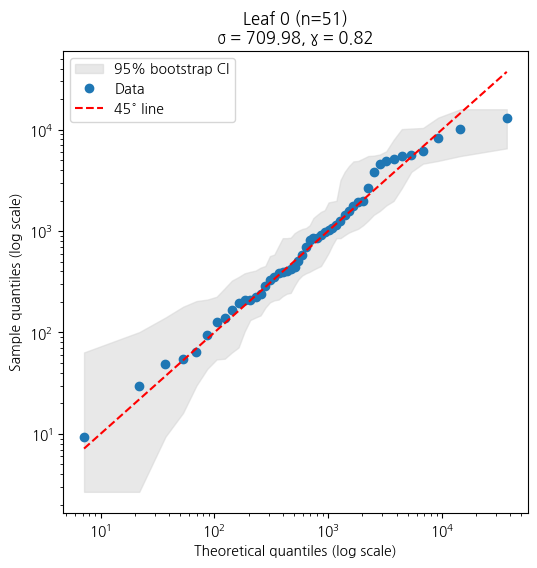

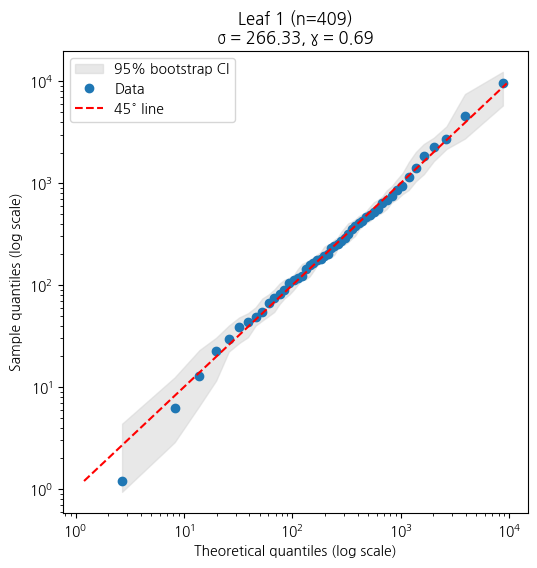

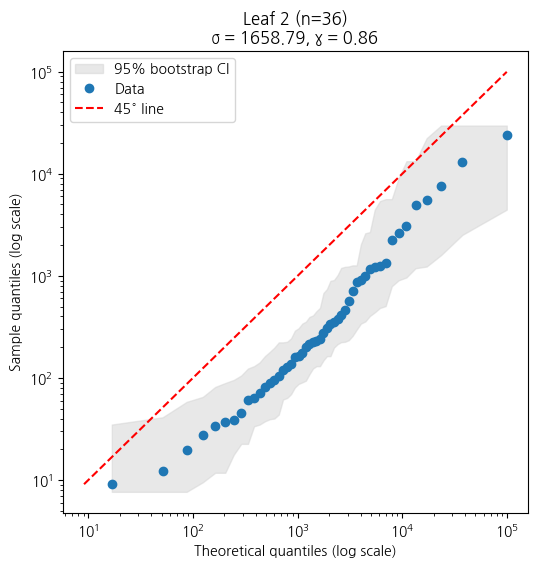

In [ ]:
graphs.plot_gp_tree_qq(gpd_tail_tree_pruned, X_tail, y_tail)


In [ ]:
import pickle

# --- __main__ 블록 마지막에 추가 ---
save_path = '/content/drive/MyDrive/Operational_risk/'
# 1) 저장할 객체들 모으기
output = {
    # Bulk 트리
    'l1_bulk_tree' : l1_bulk_tree,
    'l2_bulk_tree' : l2_bulk_tree,
    # Tail 트리
    'gpd_raw_tree' : gpd_tail_tree_raw,
    'gpd_pruned_tree' : gpd_tail_tree_pruned,
    # 데이터
    'X_bulk'       : X_bulk,
    'y_bulk'       : y_bulk,
    'X_tail'       : X_tail,
    'y_tail'       : y_tail,
    'X_all_data'   : X_all_data,
    'y_all_data'   : y_all_data,
    'df_model_ready':df_model_ready,
    # (선택) 피처 이름
    'feature_names': feature_names_list,
    # (선택) 임계값
    'u_threshold'  : u_threshold
}

# 2) 피클 파일로 저장
with open(save_path + 'risk_1985_2021_fixed.pkl', 'wb') as f:
    pickle.dump(output, f)

l1_l2_gpd.logging.info("Models and data have been saved to 'risk_1985_2021_fixed.pkl'")


In [ ]:
df_merged.columns

Index(['Date', '10_2', 'House Price Index', 'House Price Index_diff', 'M1',
       'M1_diff', 'CPI', 'CPI_diff', 'Unemployment Rate',
       'Unemployment Rate_diff', 'Close', 'Close_diff', 'Year_x',
       'Three_Component_Index', 'News_Based_Policy_Uncert_Index', 'Year_y',
       '1. Economic Policy Uncertainty', '2. Monetary policy',
       'Fiscal Policy (Taxes OR Spending)', '3. Taxes',
       '4. Government spending', '5. Health care', '6. National security',
       '7. Entitlement programs', '8. Regulation', 'Financial Regulation',
       '9. Trade policy', '10. Sovereign debt, currency crises',
       '9. Trade policy_diff', '7. Entitlement programs_diff',
       'Current Value of Loss',
       'Category_Business Disruption and System Failures',
       'Category_Clients, Products & Business Practices',
       'Category_Damage to Physical Assets',
       'Category_Employment Practices and Workplace Safety',
       'Category_Execution, Delivery & Process Management',
       'Cate

#Multivariate -bassel3

In [ ]:
import pandas as pd, numpy as np

# --- Configuration --------------------------------------------------------
TARGET_VARIABLE = "Exceedance"
DATE_COLUMN     = "Date"
START_YEAR      = 1985
u_threshold     = 191          # bulk‧tail 분기값
MIN_TAIL_SAMPLES = 50          # GPD 최소 샘플수

# Granger 기반 지연변수
selected_lags_dict = {
    'M1': [1],
    '7. Entitlement programs': [1],
    'Unemployment Rate': [1],
    'House Price Index': [1],
    'CPI': [1],
    '9. Trade policy': [1],
    'cpu_index':[1]
}

# --------------------------------------------------------------------------
#      1) 위험유형(피해 카테고리) / 2) 업종‧비즈니스라인
# --------------------------------------------------------------------------
DAMAGE_TYPE_COLS = [   # Basel 7+1 위험유형 예시
    'Category_Business Disruption and System Failures',
    'Category_Clients, Products & Business Practices',
    'Category_Damage to Physical Assets',
    'Category_Employment Practices and Workplace Safety',
    'Category_Execution, Delivery & Process Management',
    'Category_External Fraud',
    'Category_Internal Fraud',
]

BUSINESS_LINE_COLS = [ # 필요하면 라인 특징도 남겨 둘 수 있음
    # 'Category_Commercial Banking', 'Category_Corporate Finance',
    # 'Category_Health Insurance', 'Category_Life Insurance and Benefit Plans',
    # 'Category_Merchant Banking', 'Category_Municipal/Government Finance',
    # 'Category_Private Banking', 'Category_Property and Casualty Insurance',
    # 'Category_Reinsurance', 'Category_Retail Banking',
]

POLICY_INDEX_COLS = [
    '1. Economic Policy Uncertainty', '2. Monetary policy',
    'Fiscal Policy (Taxes OR Spending)', '8. Regulation'
]

# 최종적으로 feature에 넣을 카테고리 목록
categorical_cols_master = DAMAGE_TYPE_COLS + BUSINESS_LINE_COLS + POLICY_INDEX_COLS
# --------------------------------------------------------------------------

def run_full_pipeline(df_raw, damage_col):
    """
    df_raw   : 원본 DataFrame
    damage_col : 'Category_...' (피해 유형) 하나
    반환값     : dict(tree 등 결과 객체)
    """
    df_cat = df_raw[df_raw[damage_col] == 1].copy()
    if df_cat.empty:
        l1_l2_gpd.logging.warning(f"{damage_col}: 데이터 없음 → 스킵")
        return None

    # ★ 동질 집단이므로 피해 유형 컬럼은 feature에서 제거
    cat_features = [c for c in categorical_cols_master if c != damage_col]

    # ---------- lagged feature 생성 ----------
    df_model_ready, feature_names = create_lagged_features(
        df=df_cat,
        target_col=TARGET_VARIABLE,
        lag_config=selected_lags_dict,
        date_col=DATE_COLUMN,
        start_year=START_YEAR,
        additional_features=cat_features     # ← 피해 유형 제외
    )
    if df_model_ready.empty:
        l1_l2_gpd.logging.warning(f"{damage_col}: lagged DF 비어 있음 → 스킵")
        return None

    # ---------- bulk / tail 분할 ----------
    X_all = df_model_ready[feature_names].values
    y_all = df_model_ready[TARGET_VARIABLE].values
    m_bulk = y_all <= u_threshold
    m_tail = ~m_bulk
    X_bulk, y_bulk = X_all[m_bulk], y_all[m_bulk]
    X_tail, y_tail = X_all[m_tail], y_all[m_tail] - u_threshold

    # ---------- Bulk 모형 ----------
    l1_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names,
                                     min_leaf=20, max_depth=3)
    l1_l2_gpd.assign_lognorm_params(l1_tree, X_bulk, y_bulk,
                                    trunc_left=u_threshold)

    l2_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, feature_names,
                                     min_leaf=30, max_depth=4)
    l1_l2_gpd.assign_lognorm_params(l2_tree, X_bulk, y_bulk,
                                    trunc_left=u_threshold)

    # ---------- Tail(GPD) 모형 ----------
    gpd_tree = None
    if len(y_tail) >= MIN_TAIL_SAMPLES:
        raw_tree = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, feature_names,
                                           min_leaf=15, max_depth=4)
        cv_folds = min(5, max(2, len(y_tail)//10))
        gpd_tree, _ = l1_l2_gpd.prune_gpd_with_cv(raw_tree, X_tail, y_tail,
                                                  n_folds=cv_folds)
    else:
        l1_l2_gpd.logging.info(f"{damage_col}: tail 샘플 {len(y_tail)}개 → GPD 미적용")

    # ---------- 결과 묶어서 리턴 ----------
    return dict(
        n_bulk=len(y_bulk),
        n_tail=len(y_tail),
        feature_names=feature_names,   # ← 추가
        l1_tree=l1_tree,
        l2_tree=l2_tree,
        gpd_tree=gpd_tree
    )


# =====================================================================
#                             MAIN
# =====================================================================
if __name__ == "__main__":
    ...
    # ── (2) 피해 유형별 파이프라인 실행 ──
    results_by_damage = {}
    for dmg_col in DAMAGE_TYPE_COLS:
        l1_l2_gpd.logging.info(f"\n=== {dmg_col} : 파이프라인 시작 ===")
        res = run_full_pipeline(df_merged, dmg_col)
        if res is None:
            continue
        results_by_damage[dmg_col] = res

        # --- 트리 구조 출력 -----------------
        print(f"\n[{dmg_col}] ① L1 Bulk CART")
        l1_l2_gpd.print_tree_structure(
            res["l1_tree"],
            res["feature_names"]           # ← prefix 없이 feature_names만 전달
        )

        print(f"\n[{dmg_col}] ② L2 Bulk CART")
        l1_l2_gpd.print_tree_structure(
            res["l2_tree"],
            res["feature_names"]
        )

        if res["gpd_tree"] is not None:
            print(f"\n[{dmg_col}] ③ Pruned GPD Tail CART")
            l1_l2_gpd.print_tree_structure(
                res["gpd_tree"],
                res["feature_names"]
            )

    l1_l2_gpd.logging.info("=== 모든 피해 유형 모델링 종료 ===")



[Category_Business Disruption and System Failures] ① L1 Bulk CART
Leaf: N=28, median=8.28, LN(mu=4.97, sigma=3.97)

[Category_Business Disruption and System Failures] ② L2 Bulk CART
Leaf: N=28, mean=18.58, LN(mu=4.97, sigma=3.97)

[Category_Clients, Products & Business Practices] ① L1 Bulk CART
[House Price Index_lag1 ≤ 244.8] (Gain=1055.098) N=4844
  [House Price Index_lag1 ≤ 157] (Gain=182.134) N=1748
    [8. Regulation ≤ 89.67] (Gain=11.506) N=164
      Leaf: N=99, median=19.55, LN(mu=5.06, sigma=2.72)
      Leaf: N=65, median=14.77, LN(mu=5.00, sigma=2.60)
    [1. Economic Policy Uncertainty ≤ 68.62] (Gain=45.407) N=1584
      Leaf: N=336, median=7.42, LN(mu=5.00, sigma=3.44)
      Leaf: N=1248, median=9.89, LN(mu=5.01, sigma=3.18)
  [8. Regulation ≤ 58.35] (Gain=370.167) N=3096
    [M1_lag1 ≤ 1374] (Gain=13.644) N=517
      Leaf: N=232, median=8.15, LN(mu=5.06, sigma=3.84)
      Leaf: N=285, median=11.23, LN(mu=5.10, sigma=3.59)
    [2. Monetary policy ≤ 122.4] (Gain=159.264) N=2

##graphs

In [ ]:
# ! pip install pandas numpy matplotlib networkx
# ! pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pygraphviz)


======== STARTING MODELING & VISUALIZATION (WITH MOCK DATA) ========


=== Running for: Business Disruption and System Failures ===

--- [Business Disruption and System Failures] L1 및 GPD 트리 시각화 ---


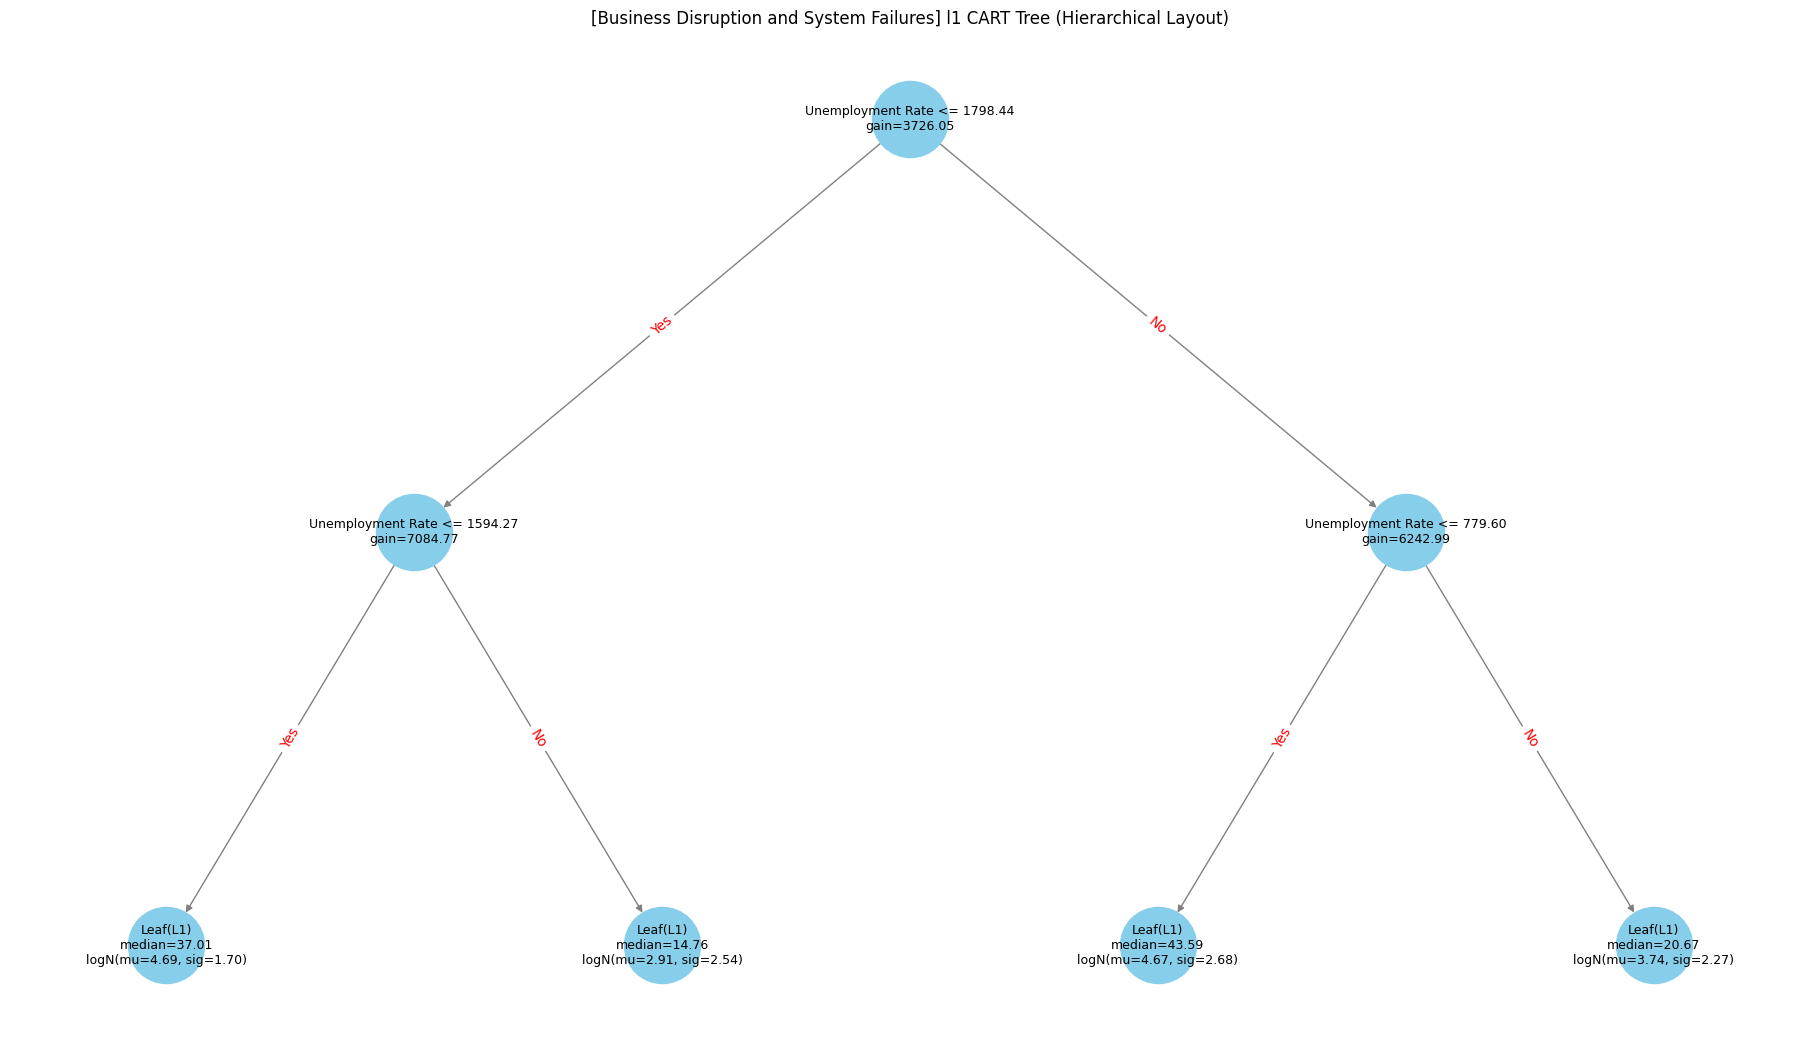

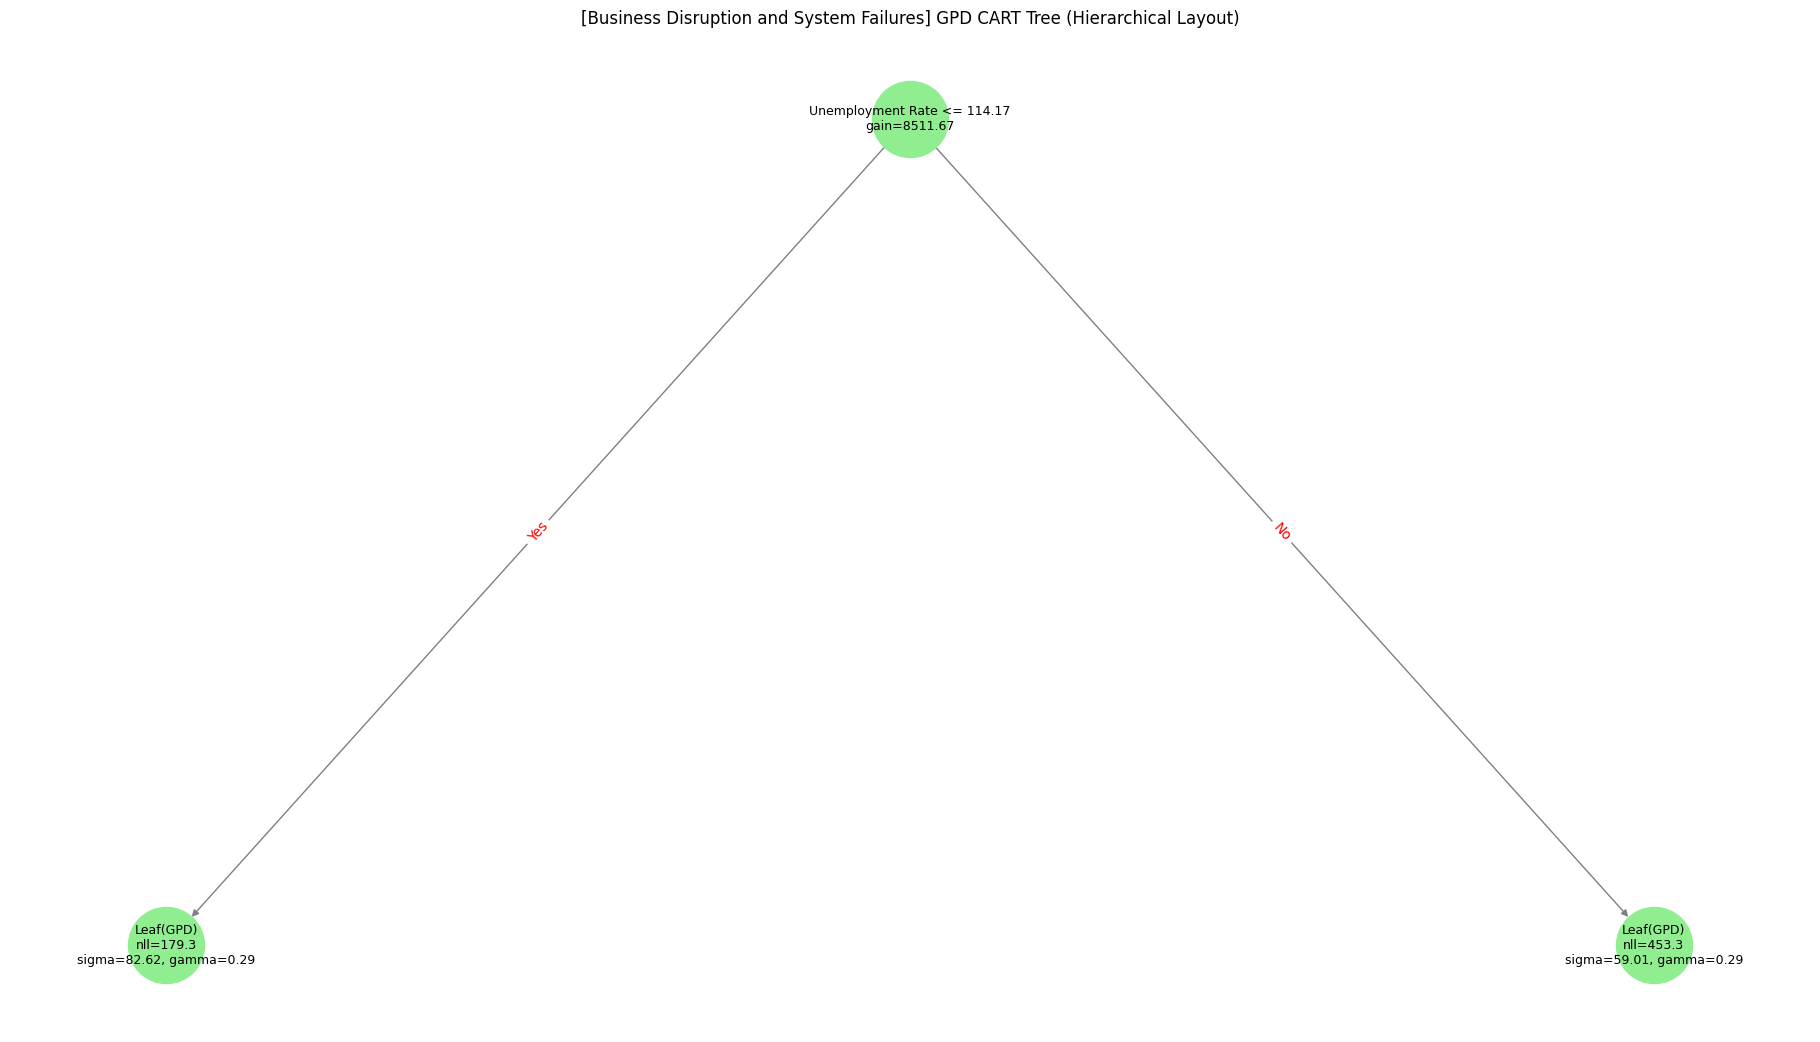


--- [Business Disruption and System Failures] GPD 모델 진단 ---


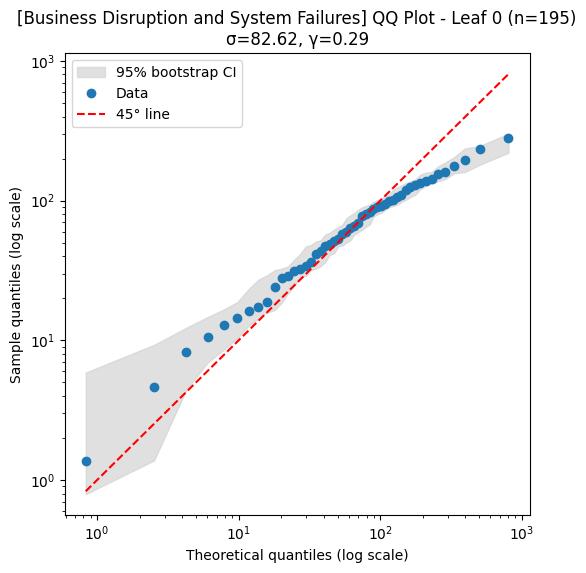

/tmp/ipython-input-133-27230923.py:151: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = [{"Leaf A": i, "Leaf B": j, "KS-stat": ks_2samp(leaf_data[i], leaf_data[j])[0], "p-value": ks_2samp(leaf_data[i], leaf_data[j])[1]}



--- Leaf 간 KS 검정 결과 ---
   Leaf A  Leaf B  KS-stat p-value
0       0       1      NaN     nan


=== Running for: Clients, Products & Business Practices ===

--- [Clients, Products & Business Practices] L1 및 GPD 트리 시각화 ---


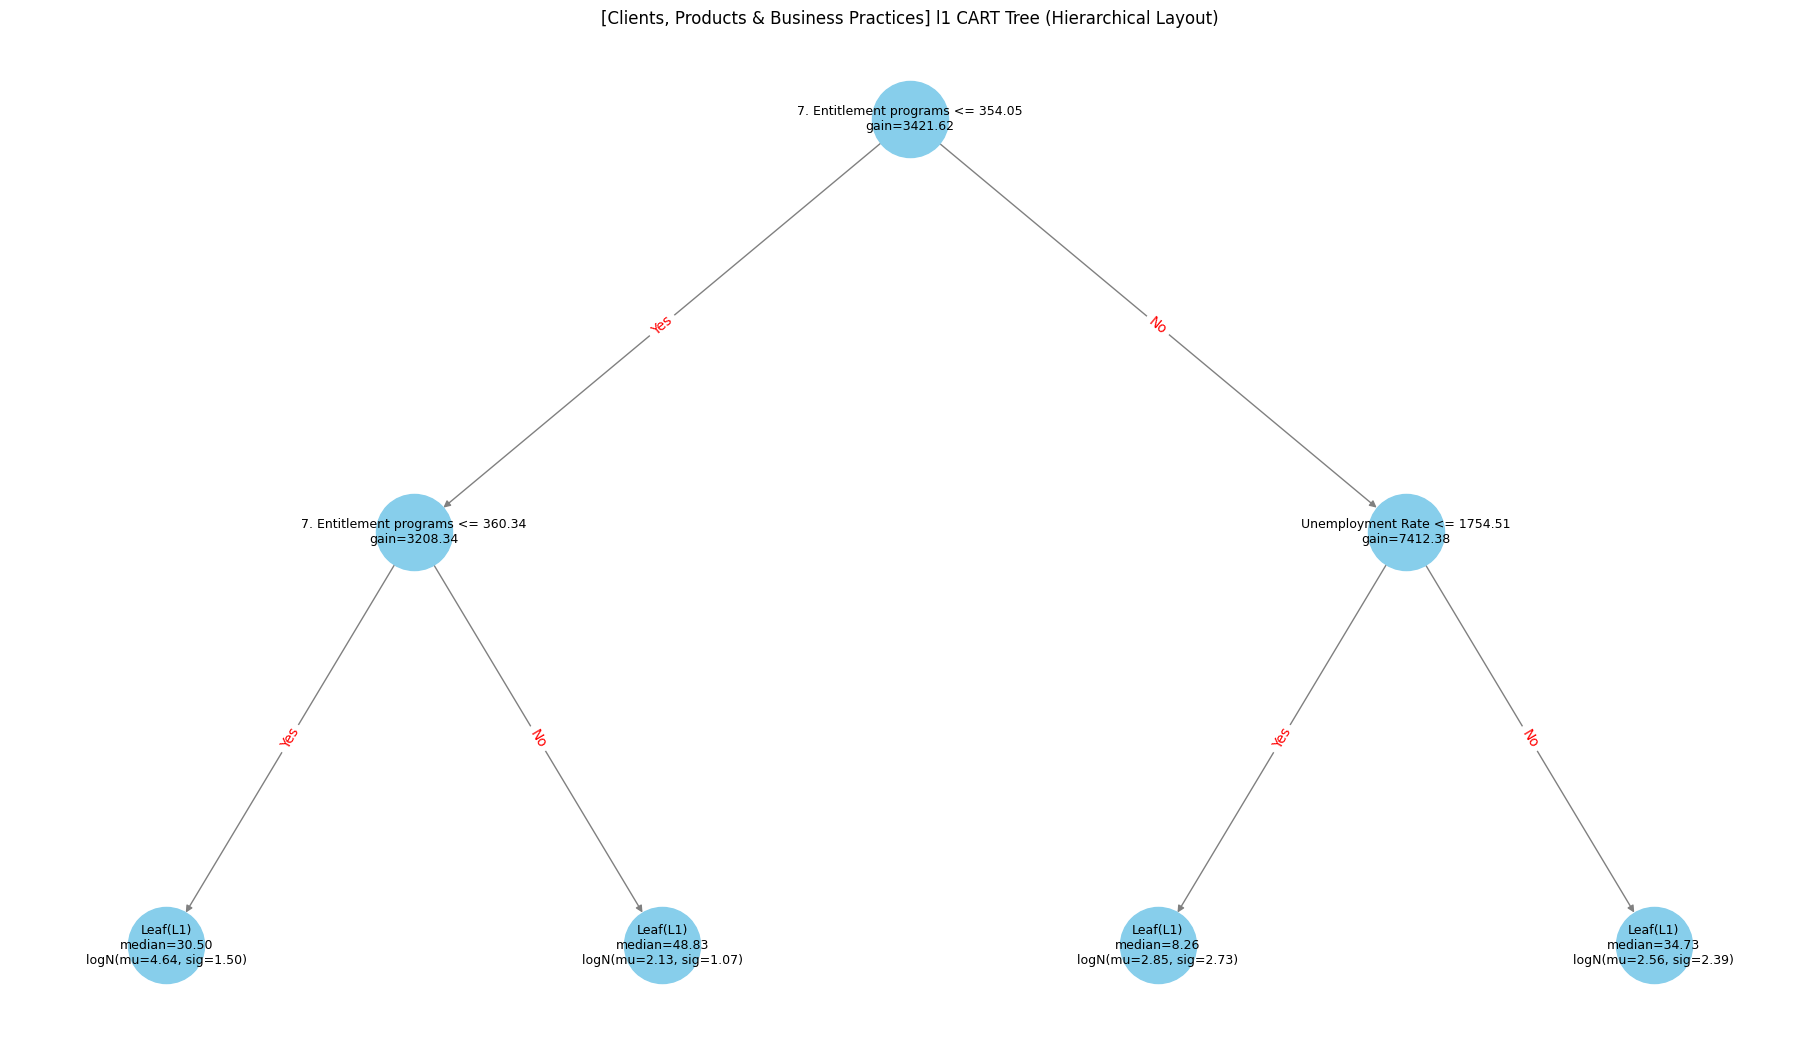

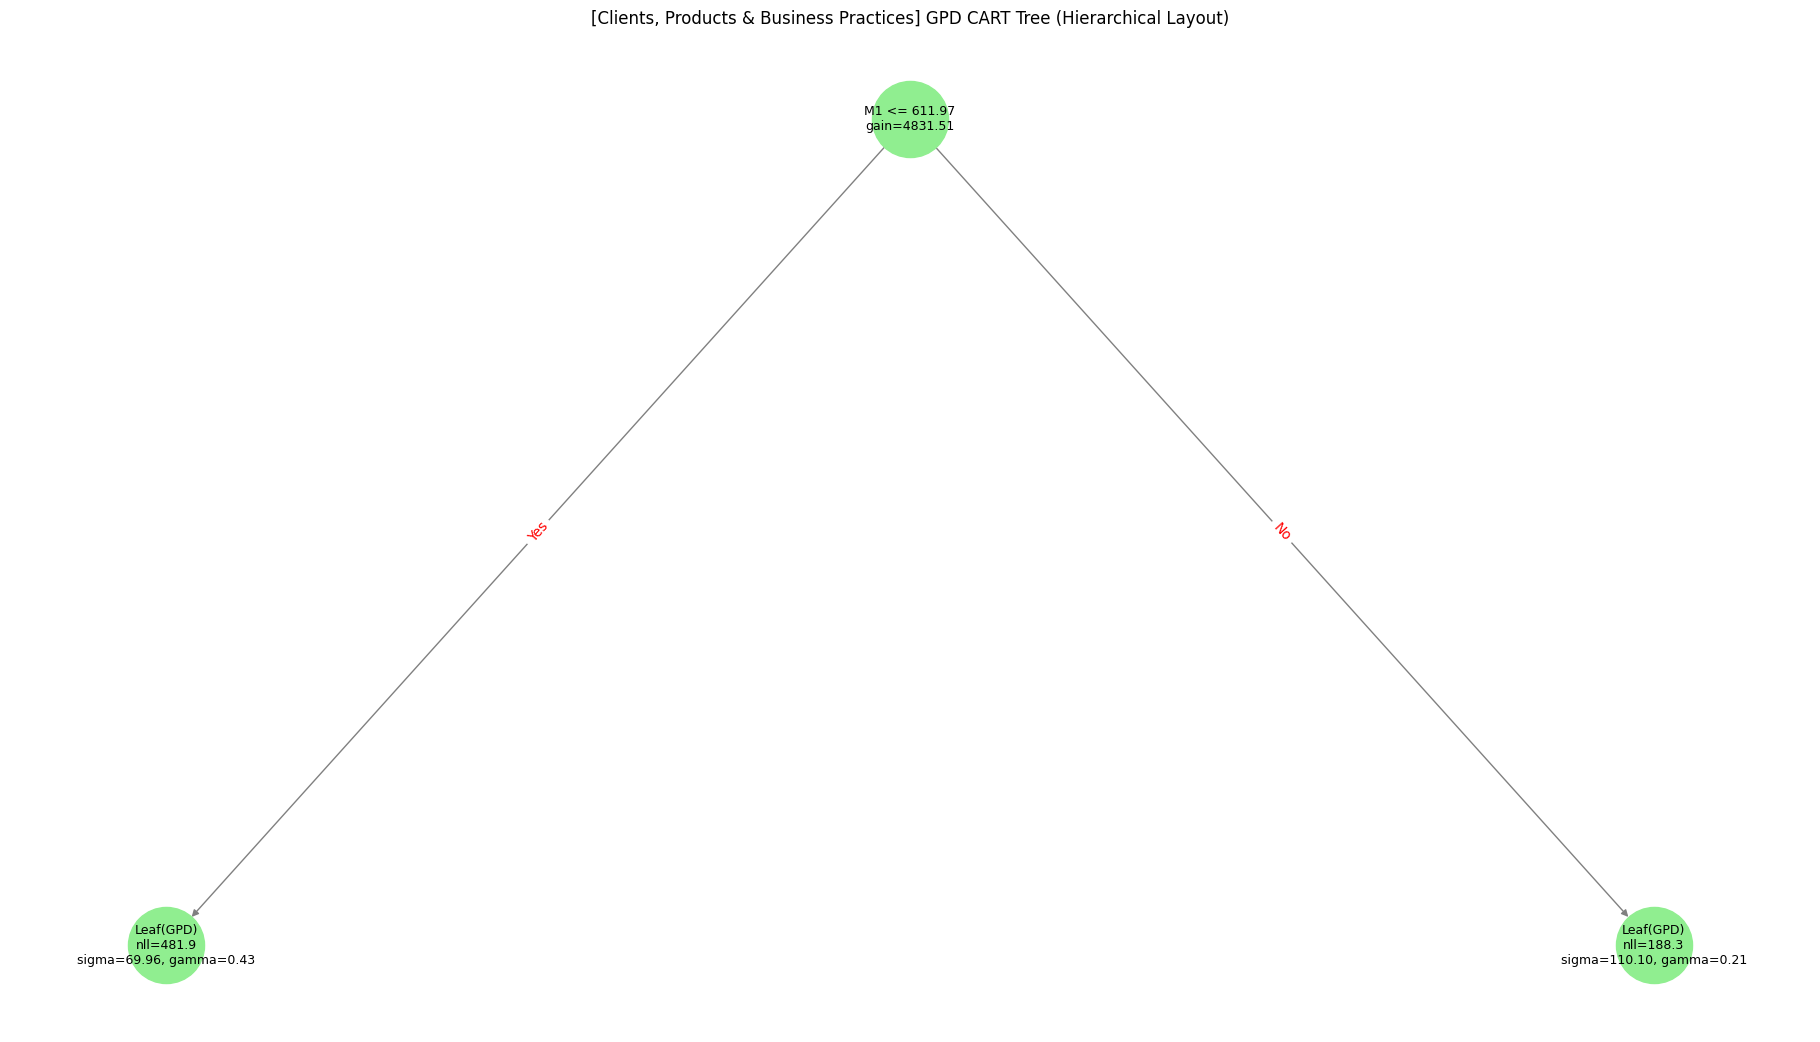


--- [Clients, Products & Business Practices] GPD 모델 진단 ---


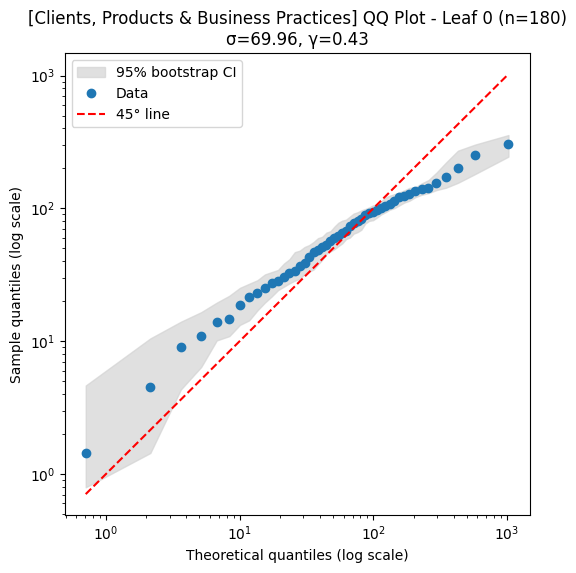

/tmp/ipython-input-133-27230923.py:151: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = [{"Leaf A": i, "Leaf B": j, "KS-stat": ks_2samp(leaf_data[i], leaf_data[j])[0], "p-value": ks_2samp(leaf_data[i], leaf_data[j])[1]}



--- Leaf 간 KS 검정 결과 ---
   Leaf A  Leaf B  KS-stat p-value
0       0       1      NaN     nan


=== Running for: Damage to Physical Assets ===

--- [Damage to Physical Assets] L1 및 GPD 트리 시각화 ---


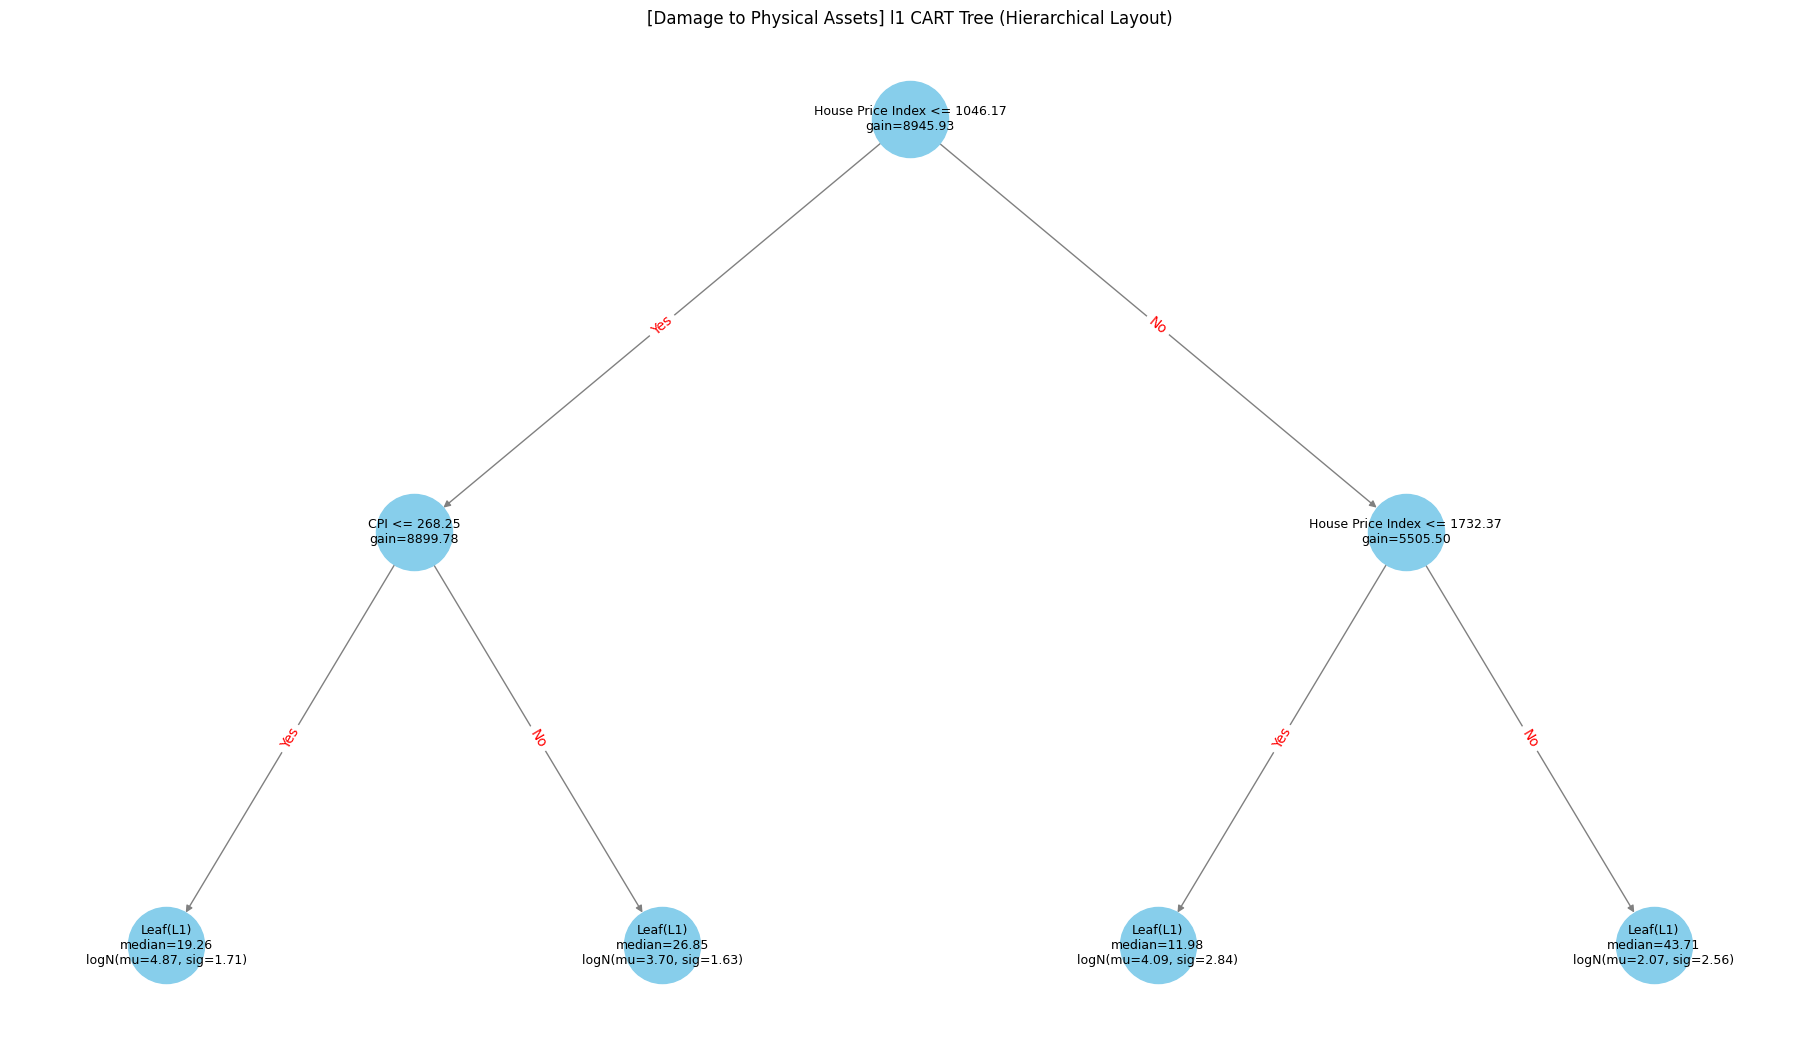

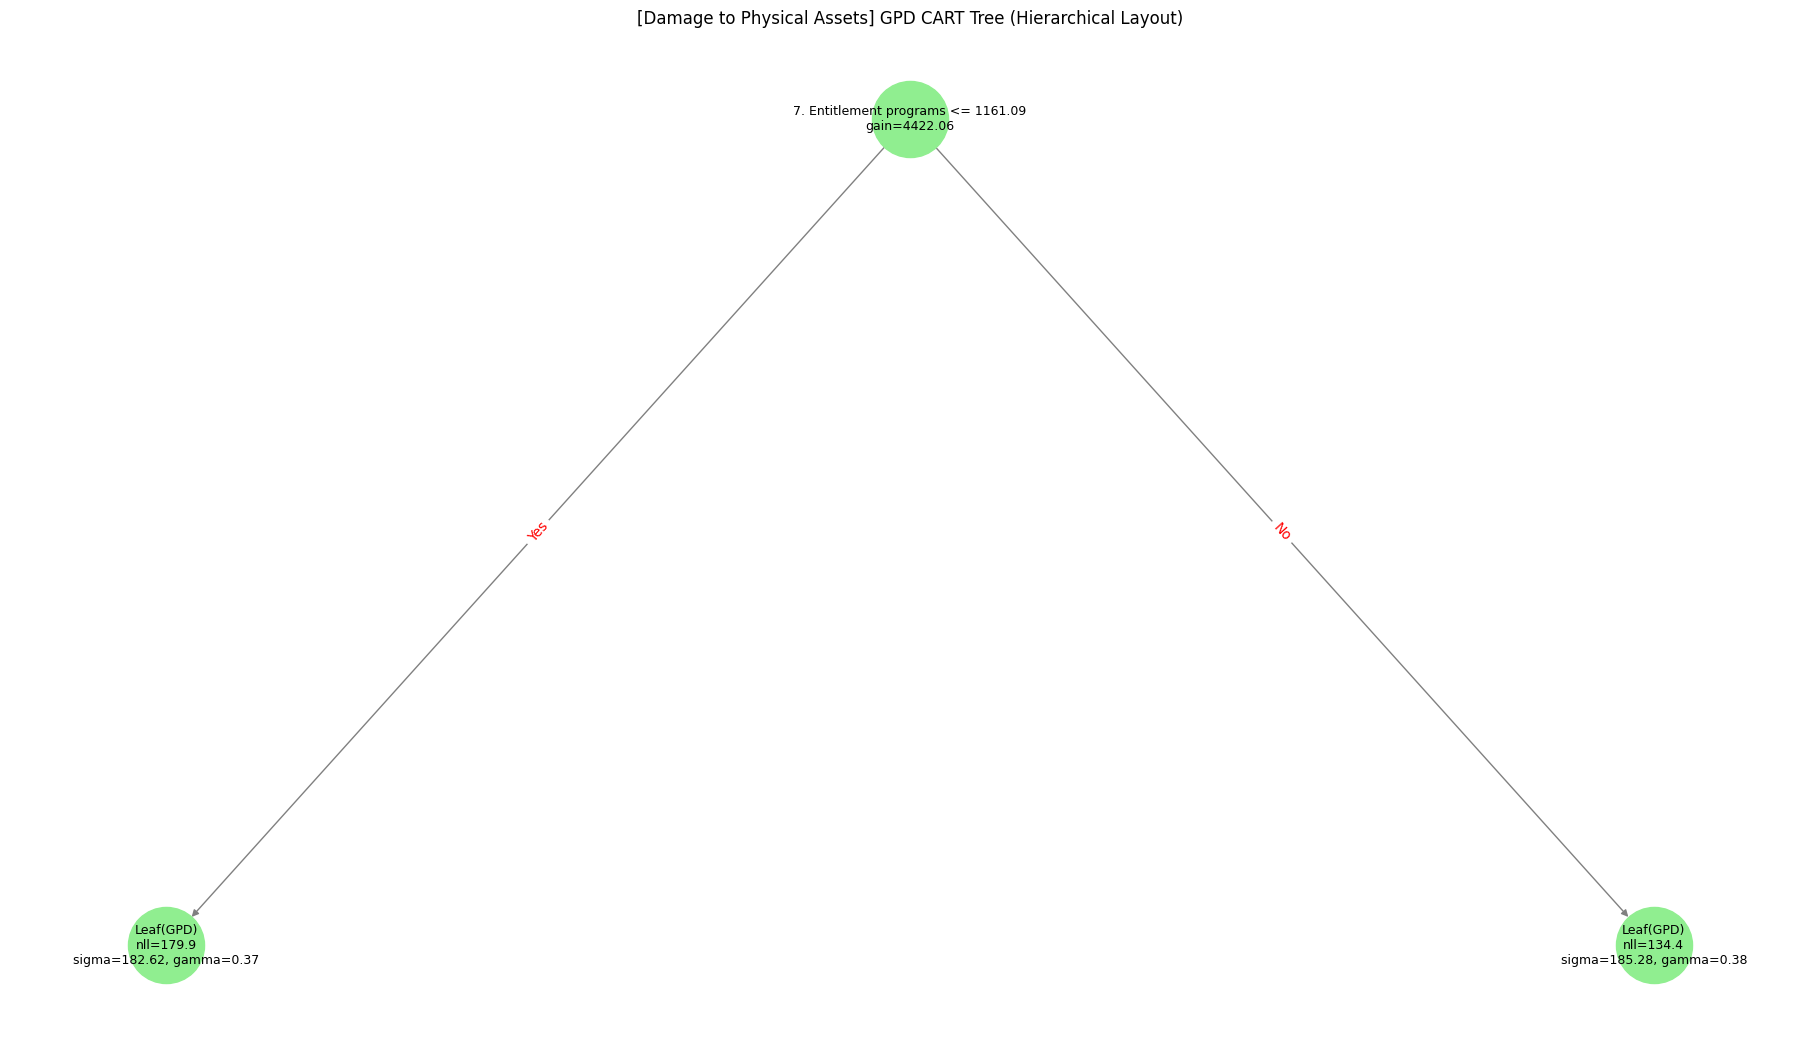


--- [Damage to Physical Assets] GPD 모델 진단 ---


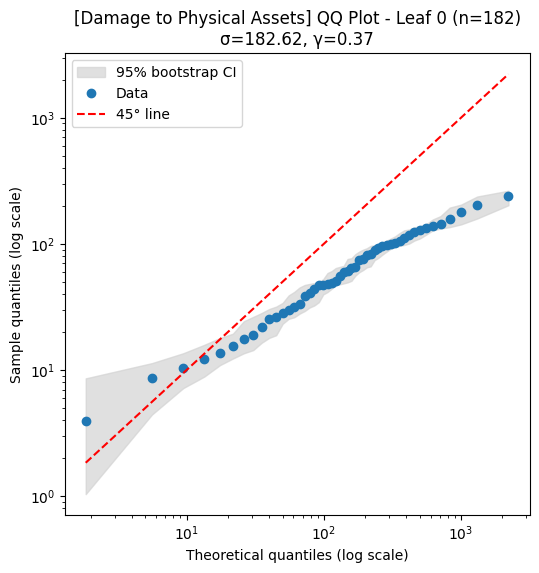


--- Leaf 간 KS 검정 결과 ---
   Leaf A  Leaf B  KS-stat p-value
0       0       1      NaN     nan


======== ALL PROCESSES FINISHED ========


/tmp/ipython-input-133-27230923.py:151: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = [{"Leaf A": i, "Leaf B": j, "KS-stat": ks_2samp(leaf_data[i], leaf_data[j])[0], "p-value": ks_2samp(leaf_data[i], leaf_data[j])[1]}


In [ ]:
# ===================================================================
#           All-in-One 최종 실행 코드 (graphs.py 반영)
# ===================================================================

# 1. 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import re
from unittest.mock import MagicMock
from scipy.stats import ks_2samp, chi2
from scipy.optimize import minimize

# 2. 시각화 및 분석 함수 (제공된 graphs.py 파일 내용 통합)
# -------------------------------------------------------------------
# 전역: 영어 폰트 사용 및 음수 부호 깨짐 방지
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.unicode_minus'] = False

def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
    """계층형 트리 구조로 그래프 G를 배치하기 위한 좌표를 dict로 반환."""
    if pos is None: pos = {}
    if root is None:
        root = next(iter(nx.topological_sort(G))) if isinstance(G, nx.DiGraph) else list(G.nodes)[0]
    neighbors = list(G.successors(root)) if isinstance(G, nx.DiGraph) else list(G.neighbors(root))
    if parent is not None and parent in neighbors:
        neighbors.remove(parent)
    if len(neighbors) == 0:
        pos[root] = (xcenter, vert_loc)
        return pos
    dx = width / len(neighbors)
    nextx = xcenter - width/2 - dx/2
    pos[root] = (xcenter, vert_loc)
    for child in neighbors:
        nextx += dx
        pos = hierarchy_pos(G, root=child, width=dx, vert_gap=vert_gap,
                            vert_loc=vert_loc - vert_gap, xcenter=nextx,
                            pos=pos, parent=root)
    return pos

def draw_l1_tree_graph_hier(node, feature_names, title_prefix=""):
    """l1 CART 트리를 계층형 레이아웃으로 시각화"""
    if node is None: return
    graph = nx.DiGraph()
    node_id_counter = [0]
    def add_nodes_edges(n, parent_id=None, is_left=None):
        node_id = node_id_counter[0]; node_id_counter[0] += 1
        if n.is_leaf:
            label = f"Leaf(L1)\nmedian={n.median_val:.2f}\nlogN(mu={n.lognorm_mu:.2f}, sig={n.lognorm_sigma:.2f})"
        else:
            split_name = feature_names[n.split_var]
            label = f"{split_name} <= {n.split_thr:.2f}\ngain={n.gain:.2f}"
        graph.add_node(node_id, label=label)
        if parent_id is not None:
            graph.add_edge(parent_id, node_id, label="Yes" if is_left else "No")
        if not n.is_leaf:
            add_nodes_edges(n.left, node_id, True)
            add_nodes_edges(n.right, node_id, False)
        return node_id
    root_id = add_nodes_edges(node)
    pos = hierarchy_pos(graph, root=root_id)
    labels = nx.get_node_attributes(graph, 'label')
    edge_labels = nx.get_edge_attributes(graph, 'label')
    plt.figure(figsize=(18, 10))
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=3000, node_color="skyblue",
            font_size=9, edge_color="gray", arrows=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color="red")
    plt.title(f"{title_prefix} l1 CART Tree (Hierarchical Layout)")
    plt.axis("off"); plt.show()

def draw_gpd_tree_graph_hier(node, feature_names, title_prefix=""):
    """GPD CART 트리를 계층형 레이아웃으로 시각화"""
    if node is None: return
    graph = nx.DiGraph()
    node_id_counter = [0]
    def add_nodes_edges(n, parent_id=None, is_left=None):
        node_id = node_id_counter[0]; node_id_counter[0] += 1
        if n.is_leaf:
            sigma, gamma = n.gpd_params
            label = f"Leaf(GPD)\nnll={n.nll:.1f}\nsigma={sigma:.2f}, gamma={gamma:.2f}"
        else:
            split_name = feature_names[n.split_var]
            label = f"{split_name} <= {n.split_thr:.2f}\ngain={n.split_gain:.2f}"
        graph.add_node(node_id, label=label)
        if parent_id is not None:
            graph.add_edge(parent_id, node_id, label="Yes" if is_left else "No")
        if not n.is_leaf:
            add_nodes_edges(n.left, node_id, True)
            add_nodes_edges(n.right, node_id, False)
        return node_id
    root_id = add_nodes_edges(node)
    pos = hierarchy_pos(graph, root=root_id)
    labels, edge_labels = nx.get_node_attributes(graph, 'label'), nx.get_edge_attributes(graph, 'label')
    plt.figure(figsize=(18, 10))
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=3000, node_color="lightgreen",
            font_size=9, edge_color="gray", arrows=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color="red")
    plt.title(f"{title_prefix} GPD CART Tree (Hierarchical Layout)")
    plt.axis("off"); plt.show()

def neg_log_likelihood_gpd(params, y):
    sigma, gamma = params
    if sigma <= 0: return 1e15
    z = 1.0 + (gamma * y / sigma)
    if np.any(z <= 0): return 1e15
    return -np.sum(-np.log(sigma) - (1.0/gamma + 1.0)*np.log(z))
def gp_log_likelihood(params, y): return -neg_log_likelihood_gpd(params, y)

def bootstrap_ci(y_leaf, ps, B=1000):
    boot_samples = np.array([np.percentile(np.random.choice(y_leaf, size=len(y_leaf), replace=True), ps * 100) for _ in range(B)])
    return np.percentile(boot_samples, 2.5, axis=0), np.percentile(boot_samples, 97.5, axis=0)

def find_leaf_gpd(node, x_row):
    while not node.is_leaf:
        node = node.left if x_row[node.split_var] <= node.split_thr else node.right
    return node

def assign_data_to_leaves_gpd(gpd_tree, X, y):
    leaves = []; traverse = lambda n: leaves.append(n) if n.is_leaf else (traverse(n.left), traverse(n.right)); traverse(gpd_tree)
    leaf_map = {leaf: i for i, leaf in enumerate(leaves)}
    leaf_data = {i: [] for i in range(len(leaves))}
    for i in range(len(X)):
        leaf_data[leaf_map[find_leaf_gpd(gpd_tree, X[i])]].append(y[i])
    return {k: np.array(v) for k, v in leaf_data.items()}, leaves

def plot_gp_tree_qq(gpd_tree, X_high, y_high, title_prefix=""):
    if gpd_tree is None or len(y_high) == 0: return
    leaf_data, leaves = assign_data_to_leaves_gpd(gpd_tree, X_high, y_high)
    ps = np.linspace(0.01, 0.99, 50)
    for leaf_id, y_leaf in leaf_data.items():
        if len(y_leaf) < 10: continue
        sigma, gamma = leaves[leaf_id].gpd_params
        theo_q = sigma/gamma * ((1-ps)**(-gamma) - 1) if gamma != 0 else -sigma * np.log(1-ps)
        samp_q = np.percentile(y_leaf, ps * 100)
        lo, hi = bootstrap_ci(y_leaf, ps, B=500) # B를 줄여 속도 향상
        plt.figure(figsize=(6, 6))
        plt.fill_between(theo_q, lo, hi, color='lightgrey', alpha=0.7, label="95% bootstrap CI")
        plt.plot(theo_q, samp_q, 'o', label="Data")
        lims = [min(theo_q.min(), samp_q.min()), max(theo_q.max(), samp_q.max())]
        plt.plot(lims, lims, 'r--', label="45° line")
        plt.xscale('log'); plt.yscale('log')
        plt.xlabel("Theoretical quantiles (log scale)"); plt.ylabel("Sample quantiles (log scale)")
        plt.title(f"{title_prefix} QQ Plot - Leaf {leaf_id} (n={len(y_leaf)})\nσ={sigma:.2f}, γ={gamma:.2f}")
        plt.legend(); plt.show()

def compare_leaves_ks(gpd_tree, X_high, y_high):
    if gpd_tree is None or len(y_high) == 0: return
    leaf_data, _ = assign_data_to_leaves_gpd(gpd_tree, X_high, y_high)
    res = [{"Leaf A": i, "Leaf B": j, "KS-stat": ks_2samp(leaf_data[i], leaf_data[j])[0], "p-value": ks_2samp(leaf_data[i], leaf_data[j])[1]}
           for i in range(len(leaf_data)) for j in range(i + 1, len(leaf_data))]
    if not res: return
    df = pd.DataFrame(res); df["p-value"] = df["p-value"].apply(lambda x: f"{x:.2e}")
    print("\n--- Leaf 간 KS 검정 결과 ---"); print(df)

def gp_tree_lrt(gpd_tree, X_high, y_high):
    if gpd_tree is None or len(y_high) < 10: return
    y_high = y_high[y_high > 0]
    leaf_data, leaves = assign_data_to_leaves_gpd(gpd_tree, X_high, y_high)
    ll_tree = sum(gp_log_likelihood(l.gpd_params, leaf_data[i]) for i, l in enumerate(leaves) if len(leaf_data[i]) > 0)
    n_leaves_used = sum(1 for i in leaf_data if len(leaf_data[i]) > 0)
    if n_leaves_used <= 1: return
    opt = minimize(neg_log_likelihood_gpd, [np.std(y_high), 0.1], args=(y_high,), method='L-BFGS-B', bounds=[(1e-8, None), (None, None)])
    ll_single = gp_log_likelihood(opt.x, y_high)
    lr, df_val = 2 * (ll_tree - ll_single), 2 * (n_leaves_used - 1)
    p = chi2.sf(lr, df_val)
    aic_tree, aic_single = 2 * (2*n_leaves_used) - 2 * ll_tree, 2*2 - 2*ll_single
    print("\n--- GP 트리 vs 단일 GP 적합 LRT 결과 ---")
    print(f"  LRT statistic = {lr:.2f} (df = {df_val}), p-value = {p:.3e}")
    print(f"  AIC (GP 트리) = {aic_tree:.2f}, AIC (단일 GP) = {aic_single:.2f}")
# -------------------------------------------------------------------


# 3. 분석 설정 및 파이프라인 함수
# -------------------------------------------------------------------
TARGET_VARIABLE, DATE_COLUMN, START_YEAR = "Exceedance", "Date", 1985
u_threshold, MIN_TAIL_SAMPLES = 191, 50
selected_lags_dict = {'M1': [1], '7. Entitlement programs': [1], 'Unemployment Rate': [1], 'House Price Index': [1], 'CPI': [1], '9. Trade policy': [1]}
DAMAGE_TYPE_COLS = ['Category_Business Disruption and System Failures', 'Category_Clients, Products & Business Practices', 'Category_Damage to Physical Assets'] # 실행시간 단축 위해 일부만 선택
categorical_cols_master = DAMAGE_TYPE_COLS + ['Category_Commercial Banking', 'Category_Retail Banking', '1. Economic Policy Uncertainty', '2. Monetary policy'] # 예시용

def run_full_pipeline(df_raw, damage_col):
    df_cat = df_raw[df_raw[damage_col] == 1].copy()
    if df_cat.empty: return None, None
    cat_features = [c for c in categorical_cols_master if c != damage_col]
    df_model_ready, feature_names = create_lagged_features(df=df_cat, additional_features=cat_features)
    if df_model_ready.empty: return None, None
    X_all, y_all = df_model_ready[feature_names].values, df_model_ready[TARGET_VARIABLE].values
    m_bulk, m_tail = y_all <= u_threshold, y_all > u_threshold
    X_bulk, y_bulk, X_tail, y_tail = X_all[m_bulk], y_all[m_bulk], X_all[m_tail], y_all[m_tail] - u_threshold
    l1_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names)
    gpd_tree = None
    if len(y_tail) >= MIN_TAIL_SAMPLES:
        raw_tree = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, feature_names)
        gpd_tree, _ = l1_l2_gpd.prune_gpd_with_cv(raw_tree, X_tail, y_tail)
    else:
        print(f"INFO: {damage_col}: tail 샘플 {len(y_tail)}개 -> GPD 미적용")
    return {'feature_names': feature_names, 'l1_tree': l1_tree, 'gpd_tree': gpd_tree}, (X_tail, y_tail)
# -------------------------------------------------------------------


# 4. 메인 실행 블록
# ===================================================================
if __name__ == '__main__':
    # --- 코드 실행을 위한 목업(Mock-up) 객체 및 데이터 생성 ---
    class MockNode:
        def __init__(self, tree_type='l1', is_leaf=False, N=0, left=None, right=None, **kwargs):
            self.is_leaf, self.N, self.left, self.right = is_leaf, N, left, right
            # 트리 타입에 따라 다른 속성 할당
            if tree_type == 'l1':
                self.median_val, self.lognorm_mu, self.lognorm_sigma = kwargs.get('median',0), kwargs.get('mu',0), kwargs.get('sig',0)
                self.split_var, self.split_thr, self.gain = kwargs.get('f_idx',0), kwargs.get('thr',0), kwargs.get('gain',0)
            elif tree_type == 'gpd':
                self.gpd_params, self.nll = kwargs.get('params', (1, 0.1)), kwargs.get('nll', 0)
                self.split_var, self.split_thr, self.split_gain = kwargs.get('f_idx',0), kwargs.get('thr',0), kwargs.get('gain',0)

    def create_mock_tree(depth=2, tree_type='l1'):
        if depth == 0:
            return MockNode(tree_type=tree_type, is_leaf=True, N=np.random.randint(20, 100),
                            median=np.random.uniform(5,50), mu=np.random.uniform(2,5), sig=np.random.uniform(1,3),
                            params=(np.random.uniform(50,200), np.random.uniform(0.1, 0.5)), nll=np.random.uniform(100,500))
        return MockNode(tree_type=tree_type, N=np.random.randint(200, 1000), f_idx=np.random.randint(0, 5),
                        thr=np.random.uniform(100, 2000), gain=np.random.uniform(100, 10000),
                        left=create_mock_tree(depth - 1, tree_type), right=create_mock_tree(depth - 1, tree_type))

    l1_l2_gpd = MagicMock()
    l1_l2_gpd.grow_tree_l1.side_effect = lambda *args, **kwargs: create_mock_tree(depth=2, tree_type='l1')
    l1_l2_gpd.grow_tree_gpd.side_effect = lambda *args, **kwargs: create_mock_tree(depth=1, tree_type='gpd')
    l1_l2_gpd.prune_gpd_with_cv.side_effect = lambda tree, *args, **kwargs: (tree, 0)

    num_samples = 2000
    df_merged = pd.DataFrame({col: np.random.randint(0, 2, num_samples) for col in categorical_cols_master})
    df_merged[TARGET_VARIABLE] = np.random.gamma(2, 50, num_samples) + np.random.choice([0, 200], num_samples, p=[0.9, 0.1])
    for col in selected_lags_dict.keys():
        if col not in df_merged.columns: df_merged[col] = np.random.rand(num_samples) * 100
    df_merged[DATE_COLUMN] = pd.to_datetime('1995-01-01') + pd.to_timedelta(np.random.randint(0, 365 * 25, num_samples), unit='D')

    def mock_create_features(df, **kwargs): return df, list(selected_lags_dict.keys()) + kwargs.get('additional_features', [])
    create_lagged_features = mock_create_features
    # ----------------------------------------------------------------

    print("======== STARTING MODELING & VISUALIZATION (WITH MOCK DATA) ========")
    for dmg_col in DAMAGE_TYPE_COLS:
        cat_name = dmg_col.replace("Category_", "")
        print(f"\n\n{'='*20}\n=== Running for: {cat_name} ===\n{'='*20}")

        result, tail_data = run_full_pipeline(df_merged, dmg_col)

        if result:
            X_tail, y_tail = tail_data

            # 1. 트리 시각화
            print(f"\n--- [{cat_name}] L1 및 GPD 트리 시각화 ---")
            draw_l1_tree_graph_hier(result['l1_tree'], result['feature_names'], title_prefix=f"[{cat_name}]")
            if result.get('gpd_tree'):
                draw_gpd_tree_graph_hier(result['gpd_tree'], result['feature_names'], title_prefix=f"[{cat_name}]")

            # 2. GPD 진단 플롯 및 테스트 (tail 데이터가 있을 경우)
            if result.get('gpd_tree') and len(y_tail) > 0:
                print(f"\n--- [{cat_name}] GPD 모델 진단 ---")
                plot_gp_tree_qq(result['gpd_tree'], X_tail, y_tail, title_prefix=f"[{cat_name}]")
                compare_leaves_ks(result['gpd_tree'], X_tail, y_tail)
                gp_tree_lrt(result['gpd_tree'], X_tail, y_tail)

    print("\n\n======== ALL PROCESSES FINISHED ========")

#Multivariate-bussinessline

In [33]:
import pandas as pd
import numpy as np
import logging
from datetime import datetime

# --- 로거 설정 -------------------------------------------------------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Configuration --------------------------------------------------------
TARGET_VARIABLE = "Exceedance"
DATE_COLUMN     = "Date"
START_YEAR      = 1985
u_threshold     = 191
MIN_TAIL_SAMPLES = 50

# Granger 기반 지연변수
selected_lags_dict = {
    'M1': [1], '7. Entitlement programs': [1], 'Unemployment Rate': [1],
    'House Price Index': [1], 'CPI': [1], '9. Trade policy': [1],
}
# --------------------------------------------------------------------------
DAMAGE_TYPE_COLS = []
BUSINESS_LINE_COLS = [ 'Category_Advisory & Other Services',
       'Category_Asset & Fund Management / Custody',
       'Category_Banking Services', 'Category_Corporate Finance & Agency',
       'Category_Insurance', 'Category_Securities & Trading',
       'Category_Unmapped'
]
POLICY_INDEX_COLS = [
    '1. Economic Policy Uncertainty', '2. Monetary policy',
    'Fiscal Policy (Taxes OR Spending)', '8. Regulation'
]
categorical_cols_master = DAMAGE_TYPE_COLS + BUSINESS_LINE_COLS + POLICY_INDEX_COLS

# =================================================================================
#  예제 실행을 위한 목업(Mock-up) 함수 및 클래스
# =================================================================================
def create_lagged_features(df, target_col, lag_config, date_col, start_year, additional_features):
    df_copy = df.copy()
    df_copy = df_copy[df_copy[date_col].dt.year >= start_year]
    if df_copy.empty: return pd.DataFrame(), []
    for col, lags in lag_config.items():
        if col in df_copy.columns:
            for lag in lags: df_copy[f'{col}_lag{lag}'] = df_copy[col].shift(lag)
    df_copy.dropna(inplace=True)
    lagged_features = [f'{col}_lag{lag}' for col, lags in lag_config.items() for lag in lags]
    feature_names = lagged_features + additional_features
    final_cols = [target_col, date_col] + [f for f in feature_names if f in df_copy.columns]
    return df_copy[final_cols], feature_names

class MockL1L2GPD:
    def __init__(self):
        self.logging = logging

    def _create_mock_leaf(self, y_data, model_type='l1'):
        if len(y_data) == 0: return {'is_leaf': True, 'n_samples': 0, 'params': {}}
        params = {}
        if model_type == 'l1': params = {'median': np.median(y_data), 'mu': np.log(np.median(y_data)) if np.median(y_data) > 0 else 0, 'sigma': 1.5}
        elif model_type == 'l2': params = {'mean': np.mean(y_data), 'mu': np.log(np.mean(y_data)) if np.mean(y_data) > 0 else 0, 'sigma': 1.8}
        elif model_type == 'gpd': params = {'gpd_sigma': np.std(y_data), 'gpd_gamma': 0.5, 'nll': -np.sum(np.log(y_data + 1e-9))}
        return {'is_leaf': True, 'n_samples': len(y_data), 'params': params}

    def _create_mock_tree(self, X, y, feature_names, max_depth, model_type):
        if max_depth == 0 or len(y) < 20 or X.shape[0] == 0: return self._create_mock_leaf(y, model_type)
        best_feature_idx = np.argmax(np.var(X, axis=0))
        threshold = np.median(X[:, best_feature_idx])
        left_mask, right_mask = X[:, best_feature_idx] <= threshold, X[:, best_feature_idx] > threshold
        node = {
            'is_leaf': False, 'feature_index': best_feature_idx, 'threshold': threshold,
            'gain': np.var(y), 'n_samples': len(y),
            'left_child': self._create_mock_tree(X[left_mask], y[left_mask], feature_names, max_depth - 1, model_type),
            'right_child': self._create_mock_tree(X[right_mask], y[right_mask], feature_names, max_depth - 1, model_type),
        }
        return node

    def grow_tree_l1(self, X, y, feature_names, min_leaf, max_depth):
        return self._create_mock_tree(X, y, feature_names, max_depth, 'l1')

    def grow_tree_l2(self, X, y, feature_names, min_leaf, max_depth):
        return self._create_mock_tree(X, y, feature_names, max_depth, 'l2')

    def grow_tree_gpd(self, X, y, feature_names, min_leaf, max_depth):
        return self._create_mock_tree(X, y, feature_names, max_depth, 'gpd')

    def assign_lognorm_params(self, *args, **kwargs): pass
    def prune_gpd_with_cv(self, raw_tree, *args, **kwargs): return raw_tree, 0

    def print_tree_structure(self, tree_root, feature_names):
        def _print_recursive(node, prefix=""):
            if not node or node.get('is_leaf', False):
                if node and node['n_samples'] > 0:
                    params, stats_str = node.get('params', {}), ""
                    if 'median' in params: stats_str = f"median={params['median']:.2f}, LN(mu={params['mu']:.2f}, sigma={params['sigma']:.2f})"
                    elif 'mean' in params: stats_str = f"mean={params['mean']:.2f}, LN(mu={params['mu']:.2f}, sigma={params['sigma']:.2f})"
                    elif 'gpd_sigma' in params: stats_str = f"GPD(σ={params['gpd_sigma']:.3f}, γ={params['gpd_gamma']:.3f}), NLL={params.get('nll', 0.0):.1f}"
                    print(f"{prefix}Leaf: N={node['n_samples']}, {stats_str}")
                else: print(f"{prefix}Leaf: N=0")
                return
            feature_name = feature_names[node['feature_index']] if node['feature_index'] < len(feature_names) else f"feature_{node['feature_index']}"
            print(f"{prefix}[{feature_name} ≤ {node['threshold']:.3f}] (Gain={node['gain']:.3f}) N={node['n_samples']}")
            _print_recursive(node.get('left_child'), prefix + "  ")
            _print_recursive(node.get('right_child'), prefix + "  ")
        if tree_root: _print_recursive(tree_root)
        else: print("Tree is empty or not provided.")

l1_l2_gpd = MockL1L2GPD()

# =================================================================================
#  메인 파이프라인 함수 (수정 없음)
# =================================================================================
def run_full_pipeline(df_raw, damage_col):
    df_cat = df_raw[df_raw[damage_col] == 1].copy()
    if df_cat.empty:
        l1_l2_gpd.logging.warning(f"[{damage_col}]: 원본 데이터 없음 → 스킵")
        return None
    cat_features = [c for c in categorical_cols_master if c != damage_col]
    df_model_ready, feature_names = create_lagged_features(
        df=df_cat, target_col=TARGET_VARIABLE, lag_config=selected_lags_dict,
        date_col=DATE_COLUMN, start_year=START_YEAR, additional_features=cat_features
    )
    if df_model_ready.empty:
        l1_l2_gpd.logging.warning(f"[{damage_col}]: 시차 변수 생성 후 데이터 없음 → 스킵")
        return None
    X_all = df_model_ready[feature_names].values
    y_all = df_model_ready[TARGET_VARIABLE].values
    m_bulk, m_tail = y_all <= u_threshold, y_all > u_threshold
    X_bulk, y_bulk = X_all[m_bulk], y_all[m_bulk]
    X_tail, y_tail = X_all[m_tail], y_all[m_tail] - u_threshold
    l1_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names, min_leaf=20, max_depth=3)
    l1_l2_gpd.assign_lognorm_params(l1_tree, X_bulk, y_bulk, trunc_left=u_threshold)
    l2_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, feature_names, min_leaf=30, max_depth=4)
    l1_l2_gpd.assign_lognorm_params(l2_tree, X_bulk, y_bulk, trunc_left=u_threshold)
    gpd_tree = None
    if len(y_tail) >= MIN_TAIL_SAMPLES:
        raw_tree = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, feature_names, min_leaf=15, max_depth=4)
        cv_folds = min(5, max(2, len(y_tail)//10))
        gpd_tree, _ = l1_l2_gpd.prune_gpd_with_cv(raw_tree, X_tail, y_tail, n_folds=cv_folds)
    else:
        l1_l2_gpd.logging.info(f"[{damage_col}]: tail 샘플 {len(y_tail)}개 ({MIN_TAIL_SAMPLES}개 미만) → GPD 미적용")
    return dict(
        n_bulk=len(y_bulk), n_tail=len(y_tail), feature_names=feature_names,
        l1_tree=l1_tree, l2_tree=l2_tree, gpd_tree=gpd_tree
    )

# =====================================================================
#                          MAIN
# =====================================================================
if __name__ == "__main__":
    # --- 1. 예제 데이터프레임 생성 ---

    ### ▼▼▼▼▼▼▼▼▼ [수정 1] FutureWarning 해결을 위해 freq='M' -> 'ME'로 변경 ▼▼▼▼▼▼▼▼▼ ###
    date_range = pd.to_datetime(pd.date_range(start='1980-01-01', end='2024-12-31', freq='ME'))
    n_samples = len(date_range)
    data = {DATE_COLUMN: date_range}

    feature_vars = list(selected_lags_dict.keys())
    for var in feature_vars: data[var] = np.random.randn(n_samples).cumsum() + 1000

    data[TARGET_VARIABLE] = np.random.randint(1, 500, size=n_samples)

    ### ▼▼▼▼▼▼▼▼▼ [수정 2] AttributeError 해결을 위해 0 대신 0으로 채워진 배열을 할당 ▼▼▼▼▼▼▼▼▼ ###
    for col in (BUSINESS_LINE_COLS + POLICY_INDEX_COLS):
        data[col] = np.zeros(n_samples, dtype=int)

    # --- 각 카테고리별 데이터 할당 (문제 상황 재현) ---
    # .iloc을 사용하여 안전하게 값을 할당합니다.
    df_temp = pd.DataFrame(data)
    df_temp.loc[100:600, 'Category_Banking Services'] = 1
    df_temp.loc[100:160, TARGET_VARIABLE] = np.random.randint(200, 500, size=len(df_temp.loc[100:160]))

    df_temp.loc[10:55, 'Category_Advisory & Other Services'] = 1
    df_temp.loc[400:500, 'Category_Asset & Fund Management / Custody'] = 1
    df_temp.loc[400:410, TARGET_VARIABLE] = np.random.randint(200, 500, size=len(df_temp.loc[400:410]))

    df_temp['Category_Unmapped'] = 0

    for col in POLICY_INDEX_COLS:
        df_temp[col] = np.random.randint(0, 2, size=n_samples)

    df_merged = df_temp

    # --- 2. 비즈니스 라인별 파이프라인 실행 ---
    results_by_damage = {}
    for dmg_col in BUSINESS_LINE_COLS:
        logging.info(f"\n{'='*30} {dmg_col} : 파이프라인 시작 {'='*30}")
        res = run_full_pipeline(df_merged, dmg_col)
        if res is None:
            logging.warning(f"===> [{dmg_col}]: 최종 결과 없음 (파이프라인 스킵됨)\n")
            continue
        results_by_damage[dmg_col] = res
        print(f"\n[{dmg_col}] ① L1 Bulk CART")
        l1_l2_gpd.print_tree_structure(res["l1_tree"], res["feature_names"])
        print(f"\n[{dmg_col}] ② L2 Bulk CART")
        l1_l2_gpd.print_tree_structure(res["l2_tree"], res["feature_names"])
        if res["gpd_tree"] is not None:
            print(f"\n[{dmg_col}] ③ Pruned GPD Tail CART")
            l1_l2_gpd.print_tree_structure(res["gpd_tree"], res["feature_names"])
        logging.info(f"===> [{dmg_col}]: 파이프라인 처리 완료\n")
    logging.info("=== 모든 비즈니스 라인 모델링 종료 ===")


[Category_Asset & Fund Management / Custody] ① L1 Bulk CART
[9. Trade policy_lag1 ≤ 980.720] (Gain=2762.323) N=36
  Leaf: N=18, median=113.50, LN(mu=4.73, sigma=1.50)
  Leaf: N=18, median=135.50, LN(mu=4.91, sigma=1.50)

[Category_Asset & Fund Management / Custody] ② L2 Bulk CART
[9. Trade policy_lag1 ≤ 980.720] (Gain=2762.323) N=36
  Leaf: N=18, mean=108.78, LN(mu=4.69, sigma=1.80)
  Leaf: N=18, mean=122.61, LN(mu=4.81, sigma=1.80)

[Category_Asset & Fund Management / Custody] ③ Pruned GPD Tail CART
[House Price Index_lag1 ≤ 1026.065] (Gain=8758.822) N=64
  [M1_lag1 ≤ 1005.221] (Gain=9688.934) N=32
    Leaf: N=16, GPD(σ=104.624, γ=0.500), NLL=-72.7
    Leaf: N=16, GPD(σ=91.753, γ=0.500), NLL=-75.7
  [9. Trade policy_lag1 ≤ 980.910] (Gain=7820.835) N=32
    Leaf: N=16, GPD(σ=94.068, γ=0.500), NLL=-72.8
    Leaf: N=16, GPD(σ=82.381, γ=0.500), NLL=-73.7

[Category_Banking Services] ① L1 Bulk CART
[Unemployment Rate_lag1 ≤ 994.987] (Gain=2783.618) N=127
  [9. Trade policy_lag1 ≤ 980.957]

##graphs

======== STARTING MODELING & VISUALIZATION (WITH MOCK DATA) ========


=== Running for: Advisory & Other Services ===
--- [Advisory & Other Services] 파이프라인이 스킵되었습니다. (데이터 부족) ---


=== Running for: Asset & Fund Management / Custody ===

--- [Asset & Fund Management / Custody] Tree Visualization ---


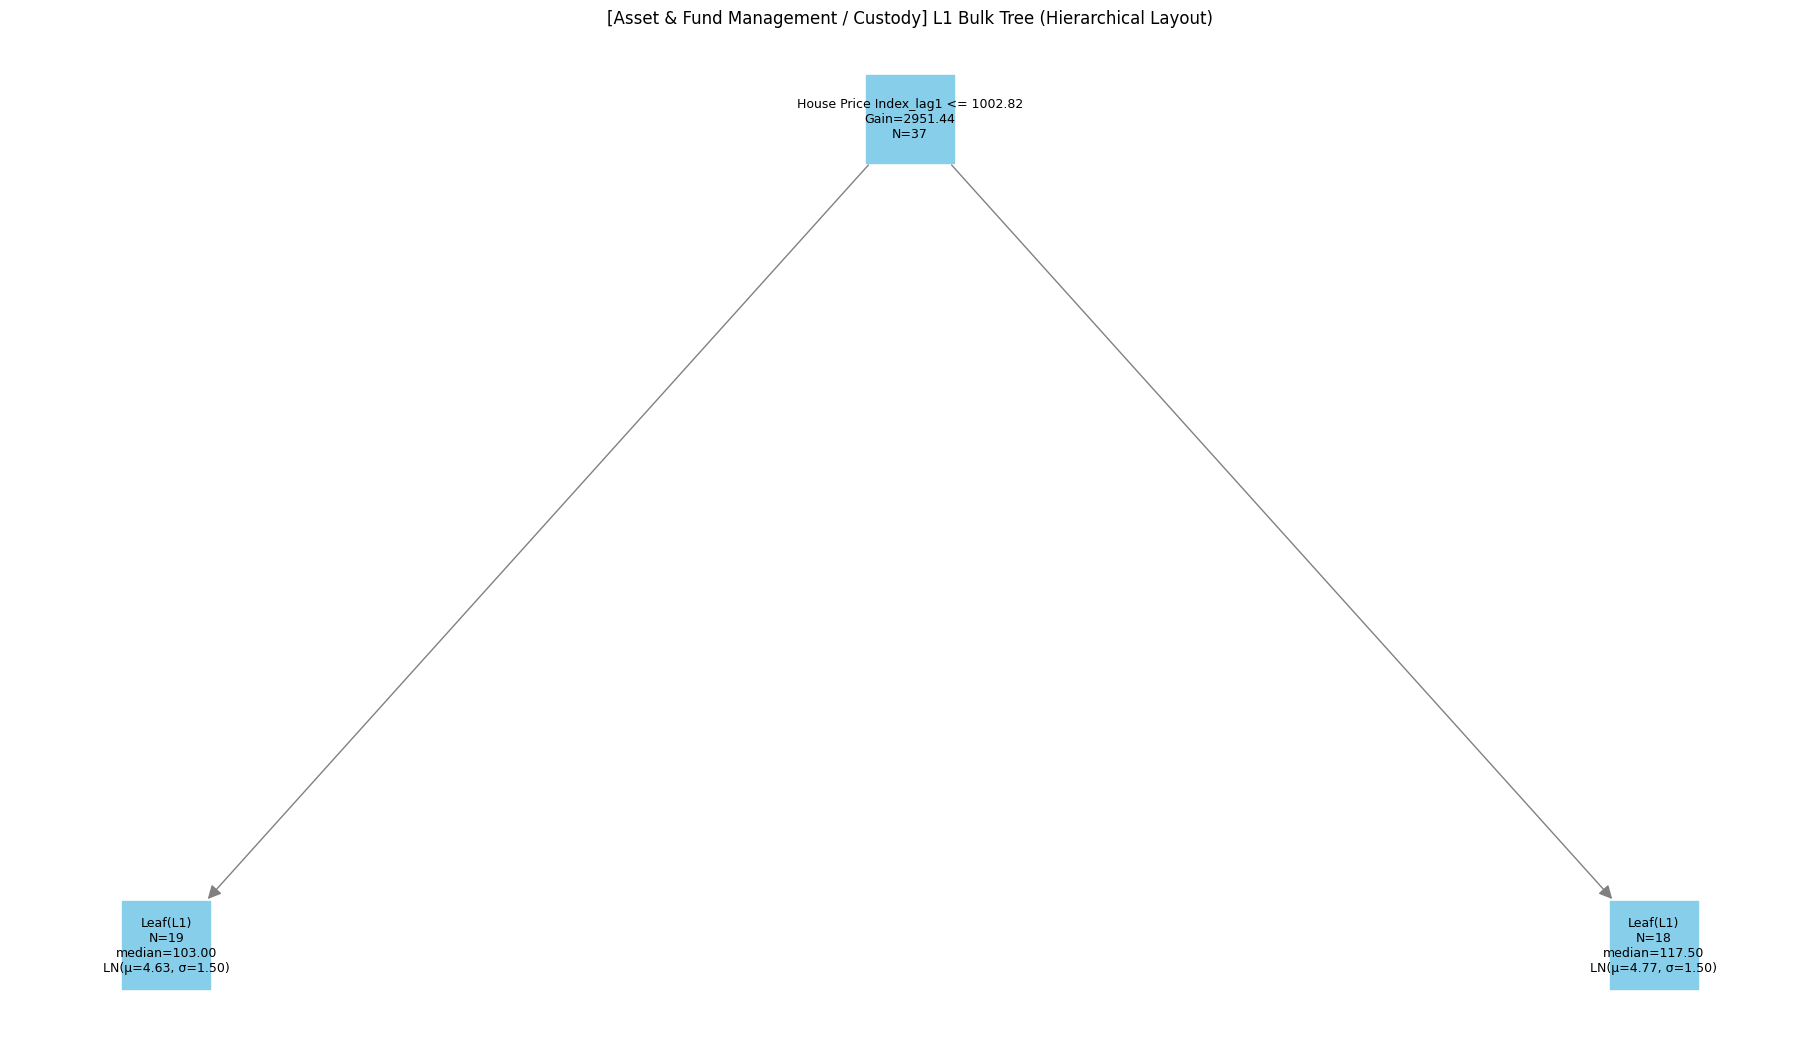

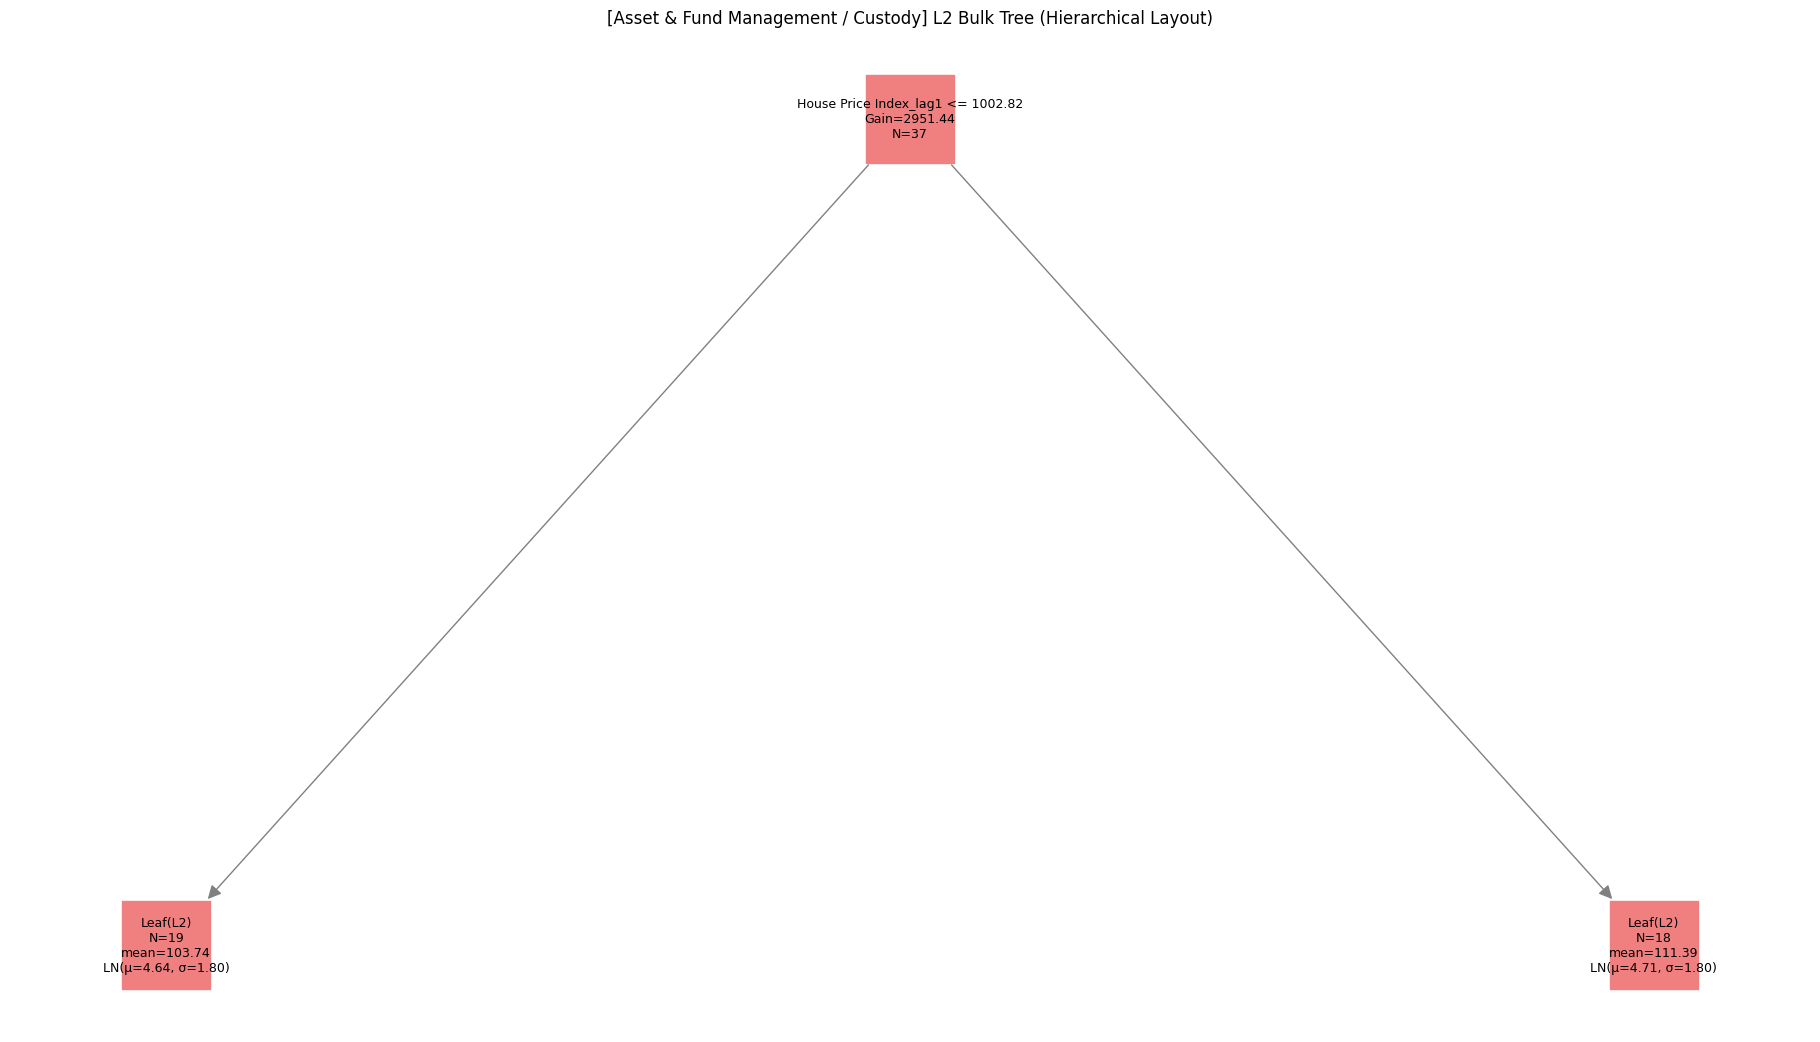

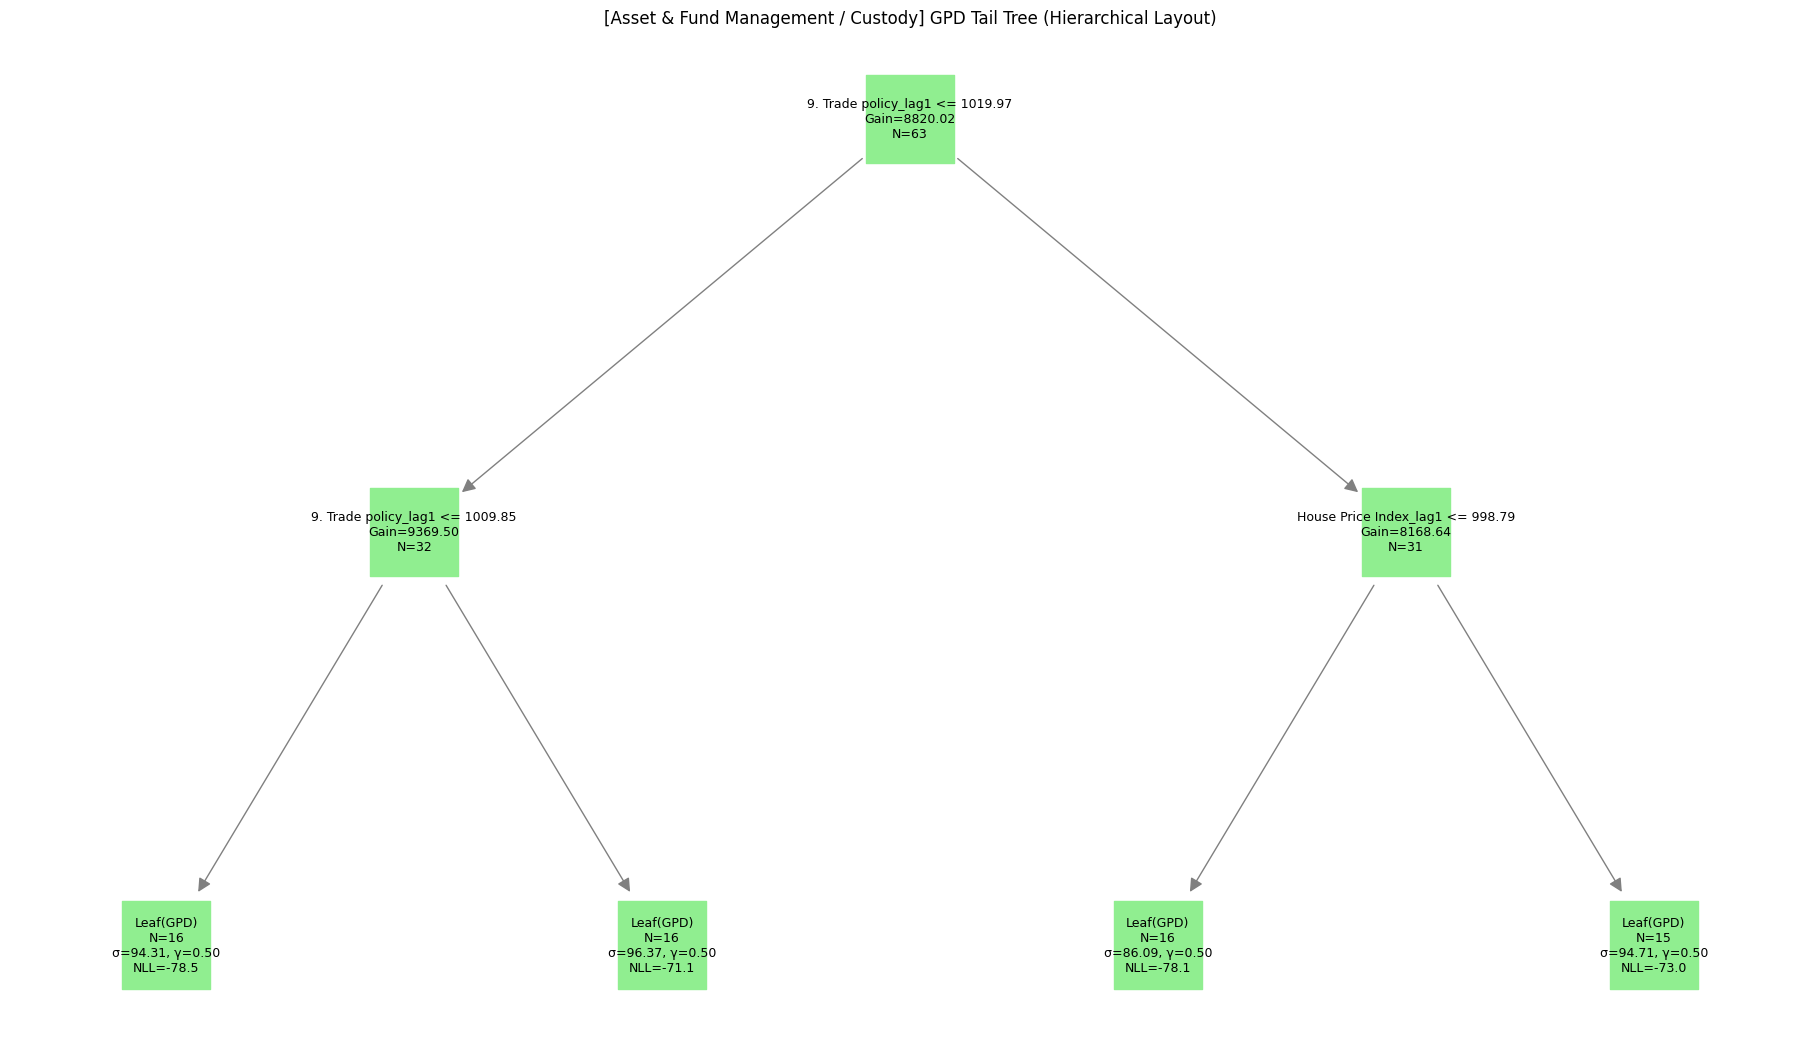


--- [Asset & Fund Management / Custody] GPD Model Diagnostics ---


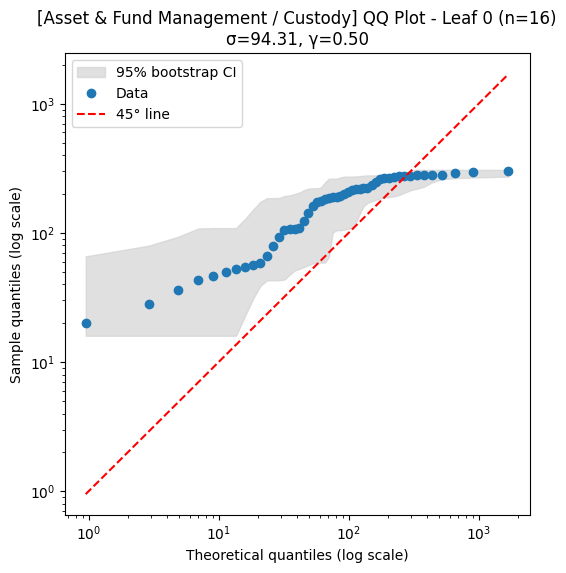

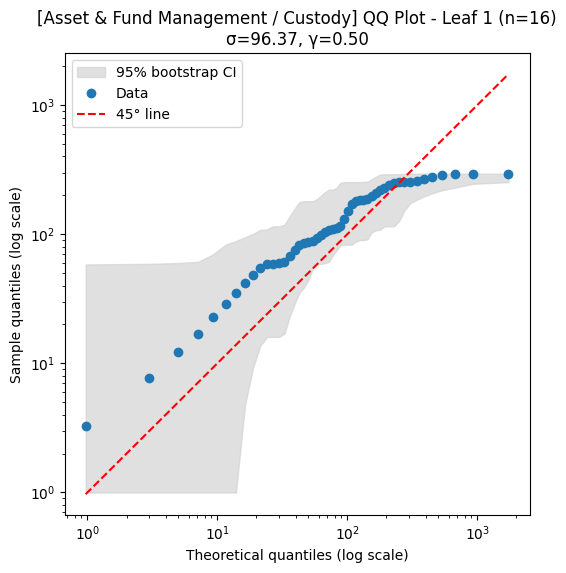

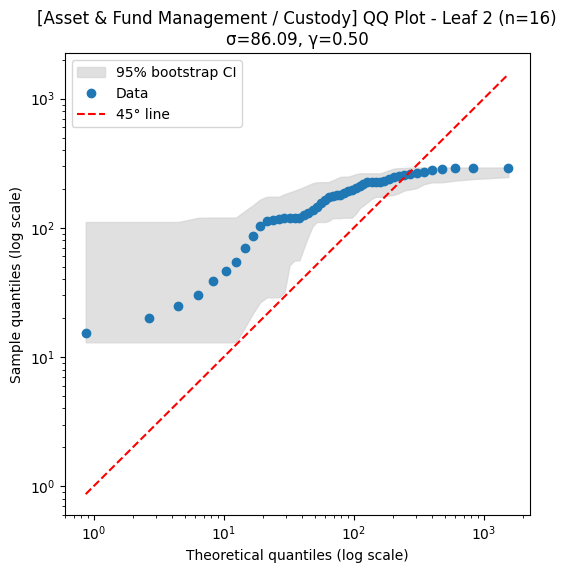

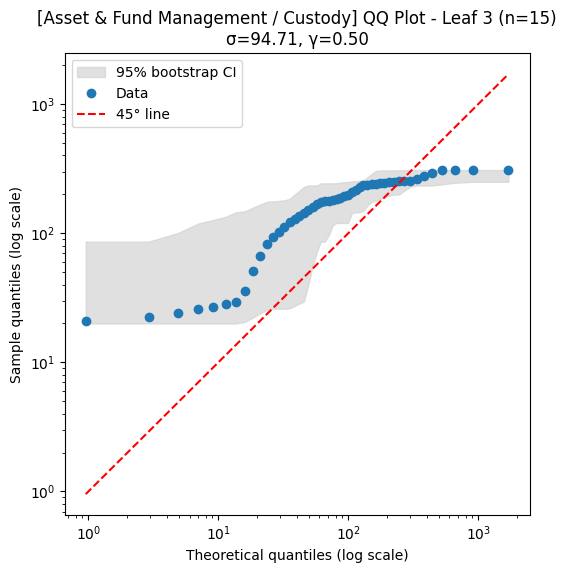



=== Running for: Banking Services ===

--- [Banking Services] Tree Visualization ---


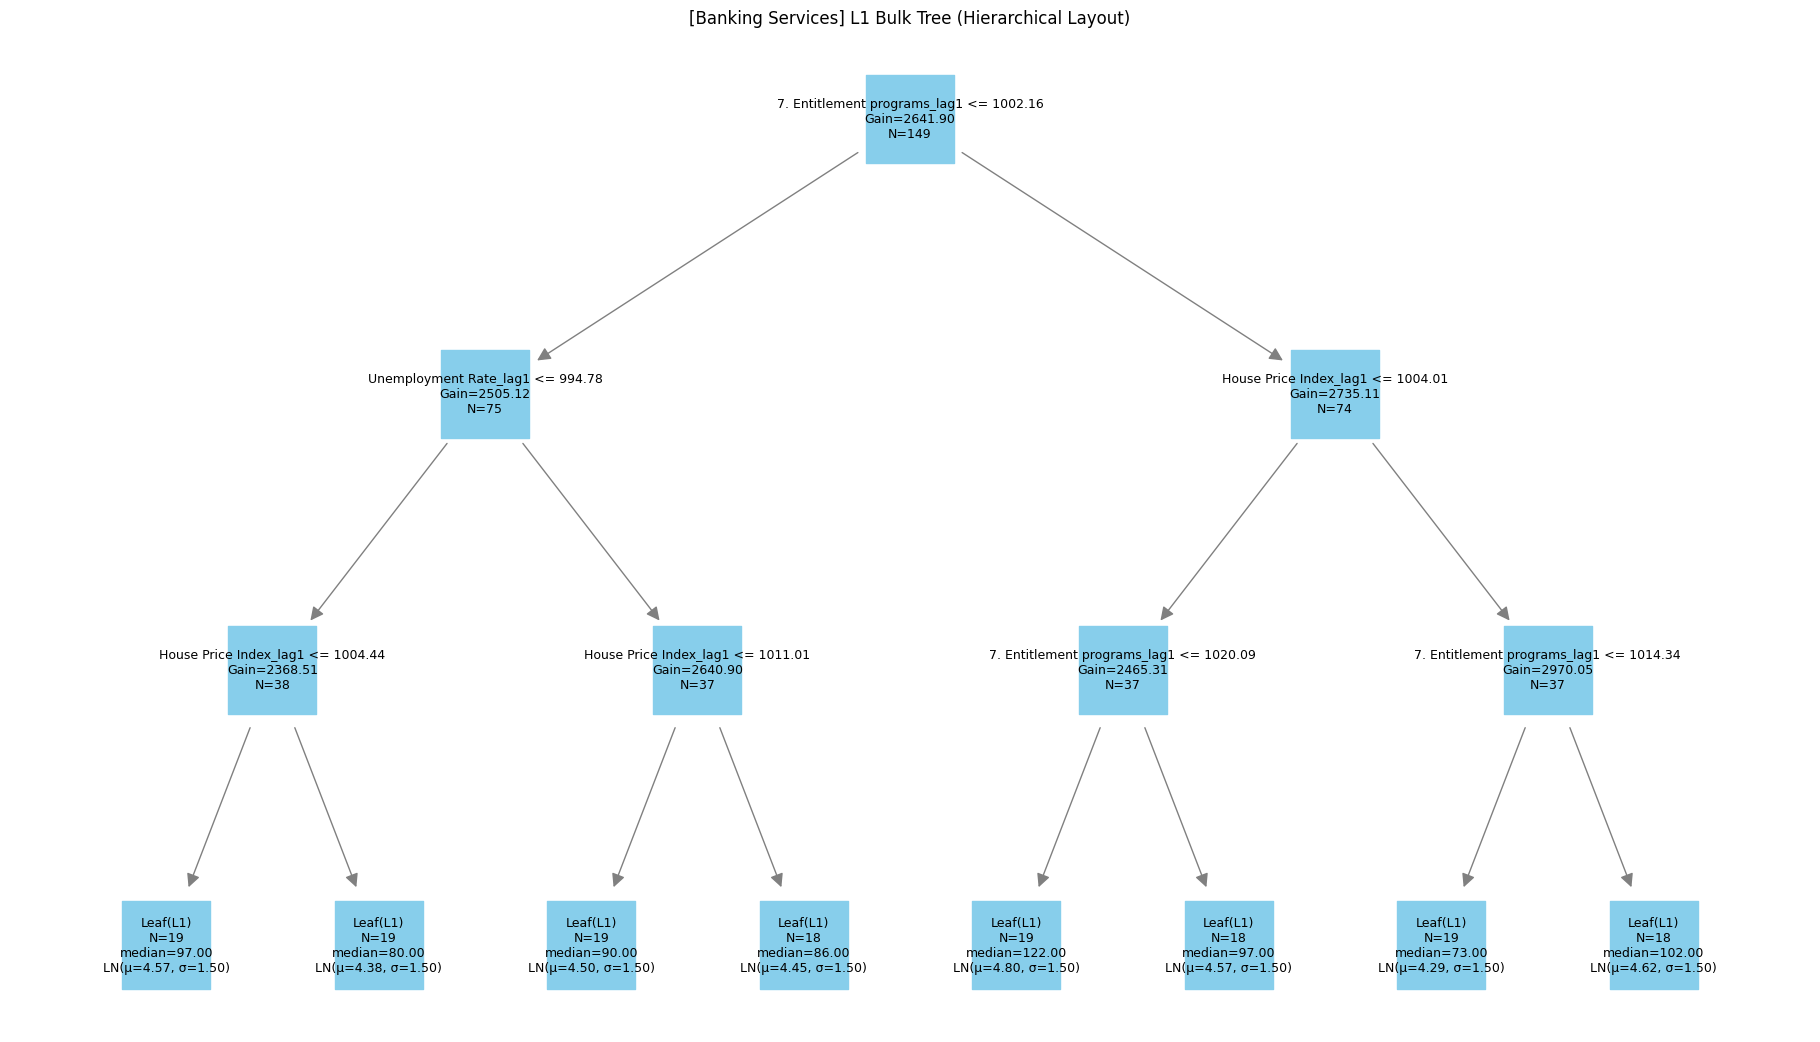

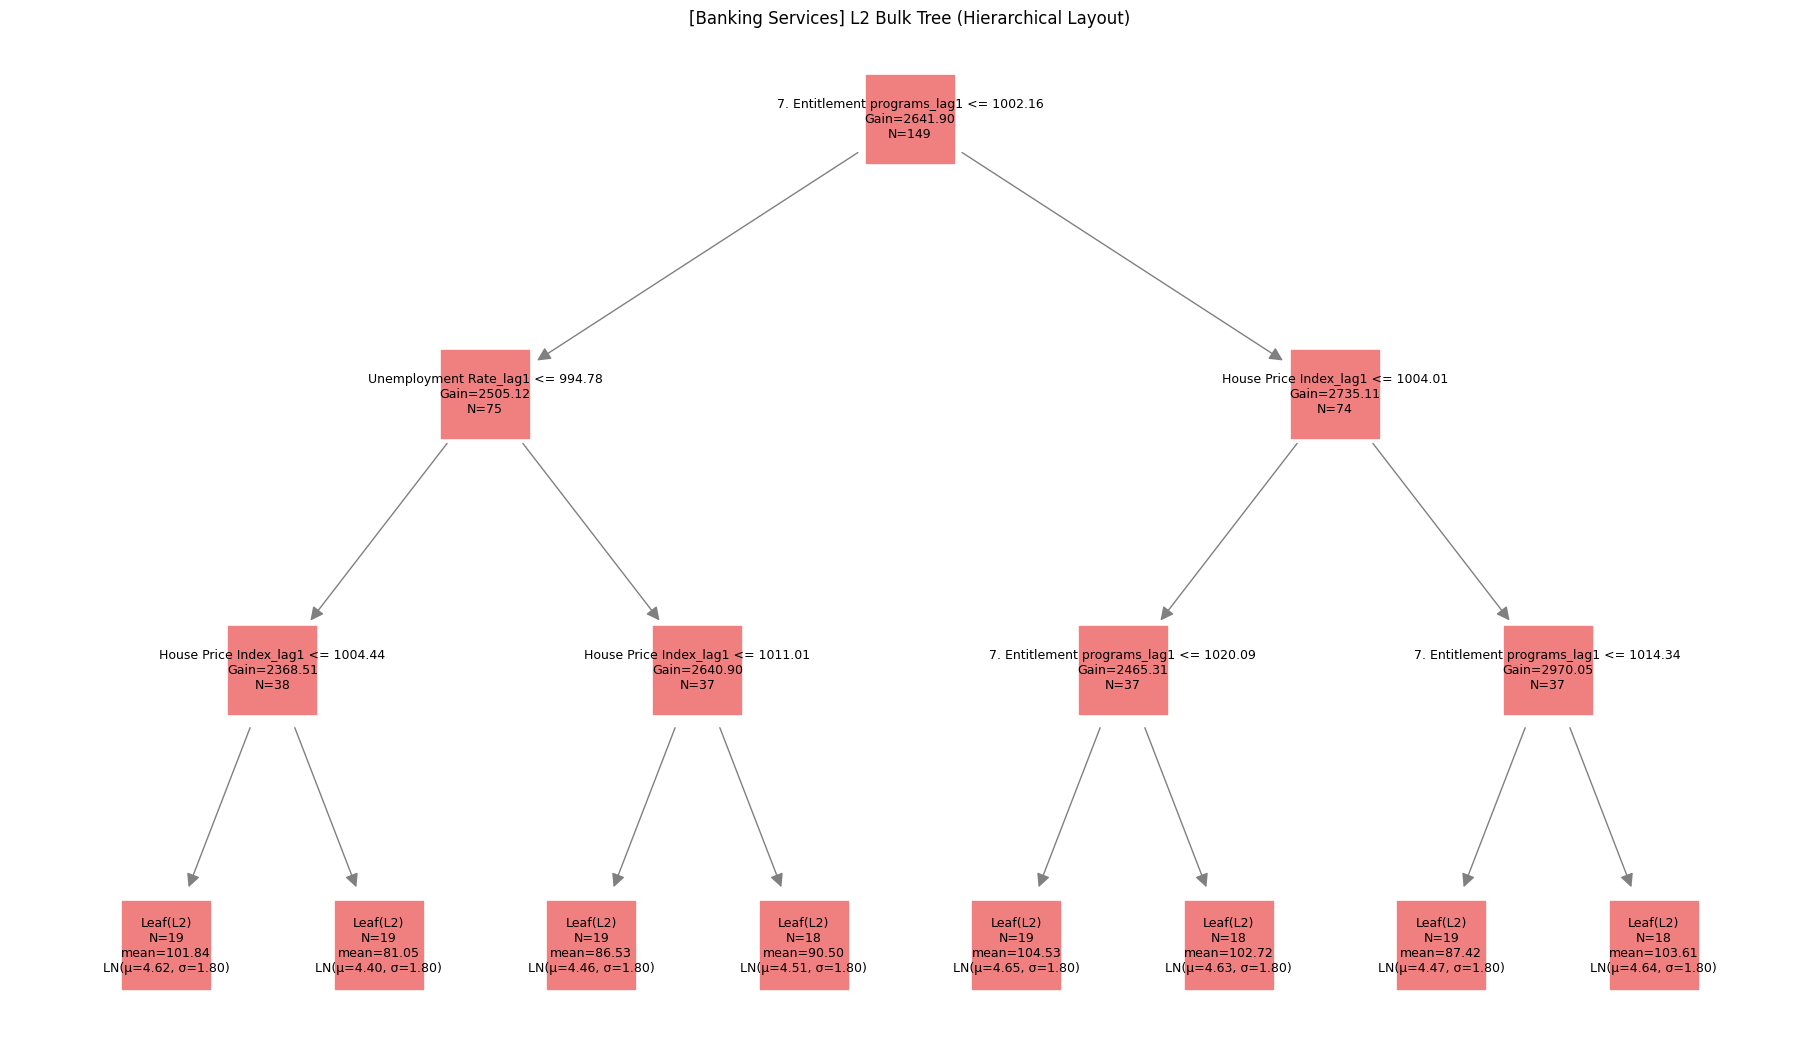

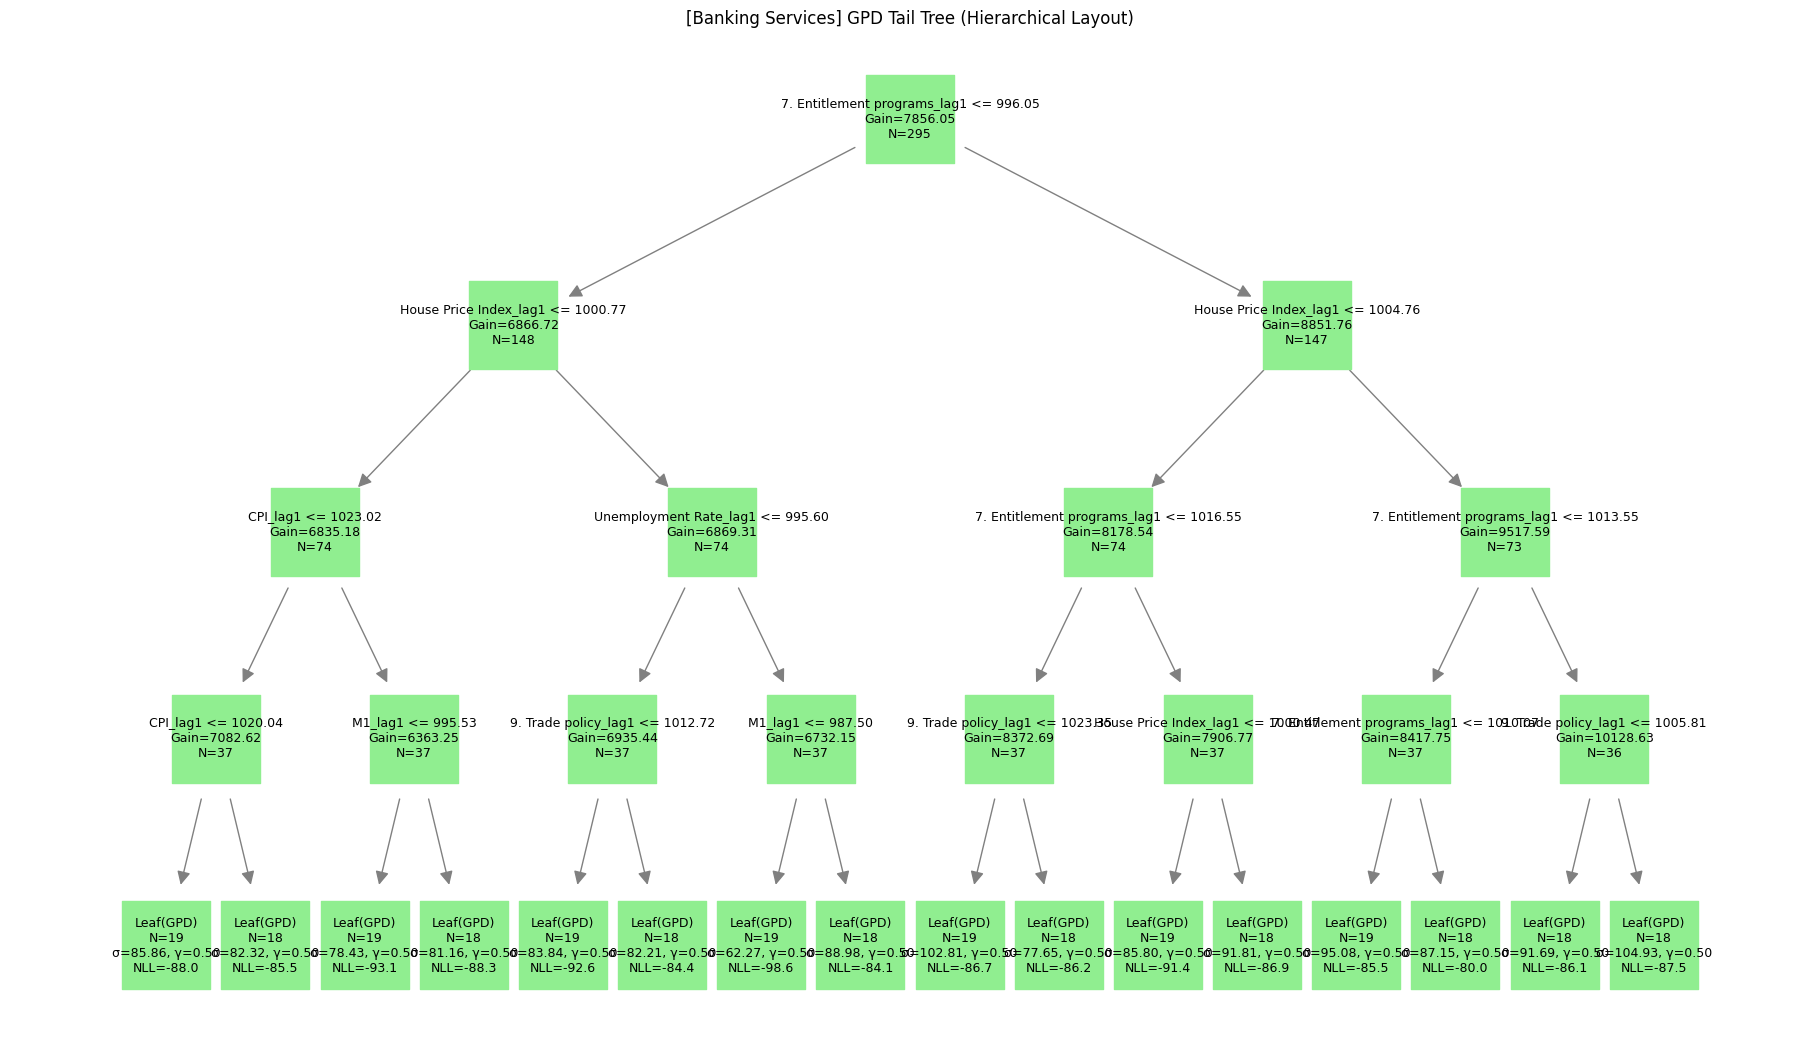


--- [Banking Services] GPD Model Diagnostics ---


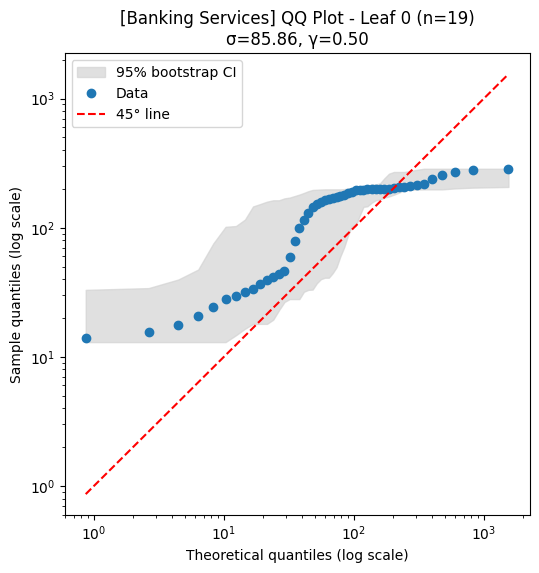

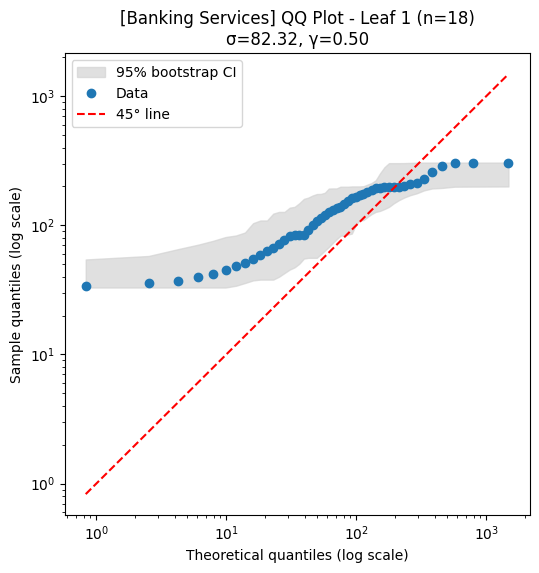

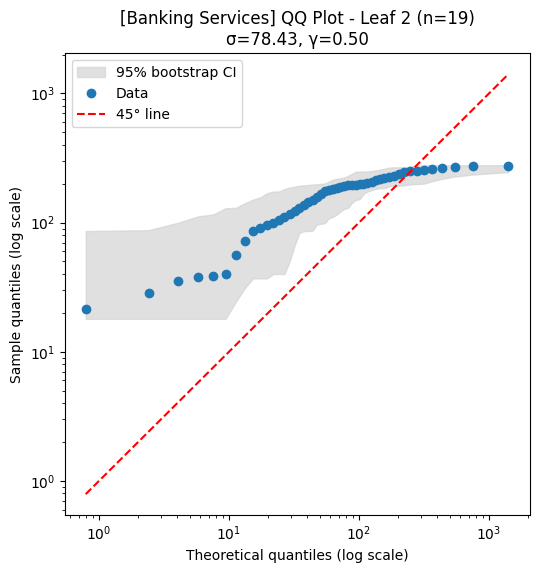

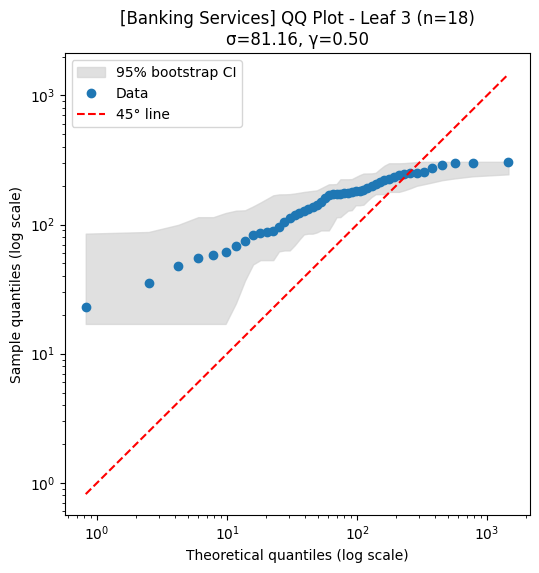

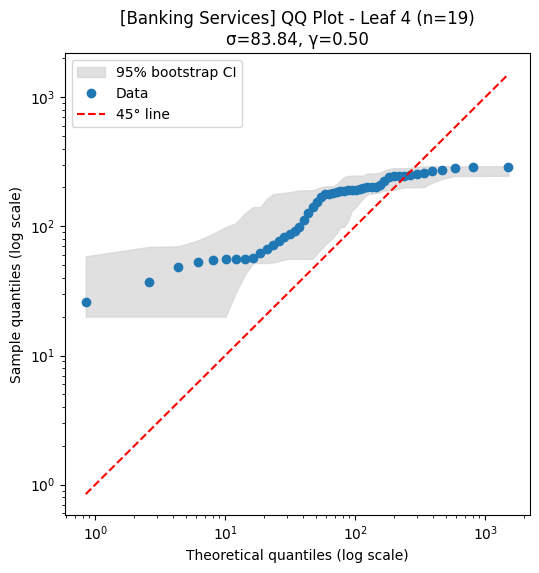

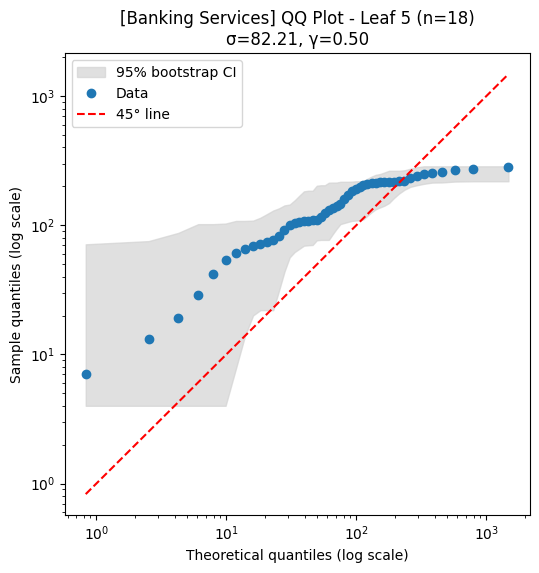

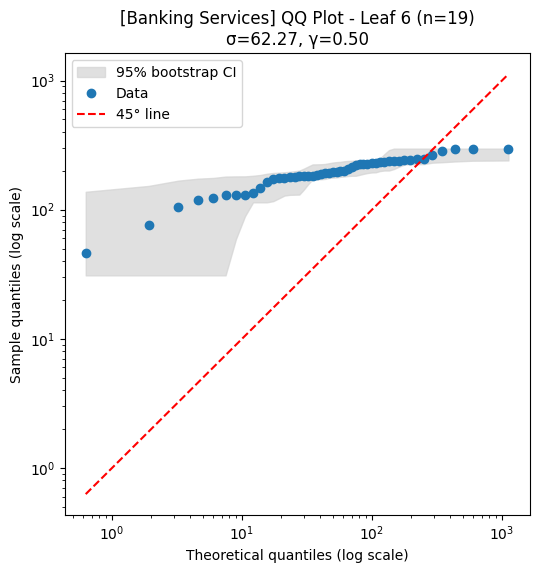

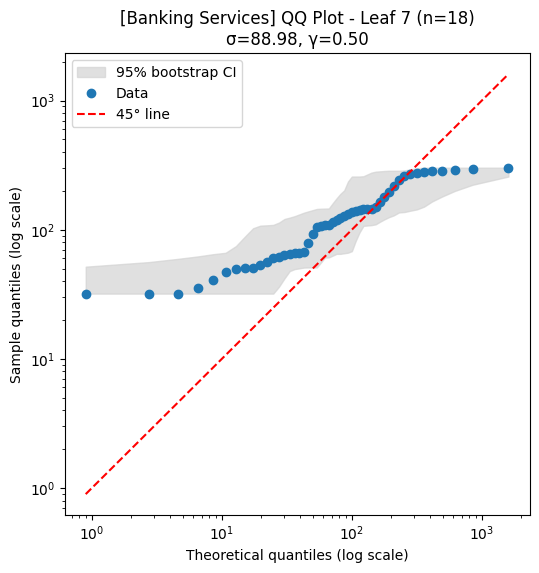

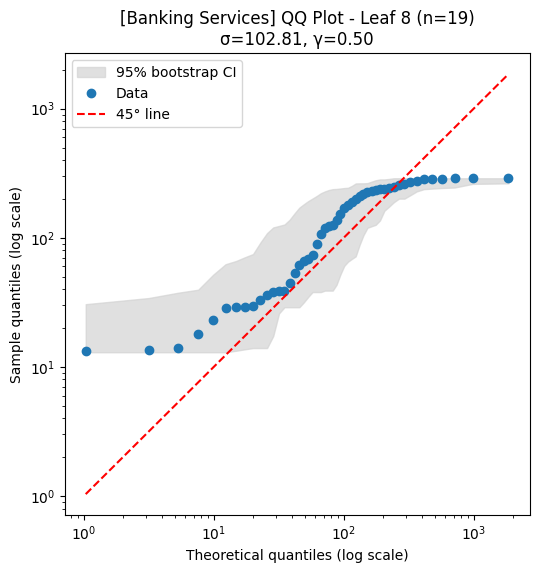

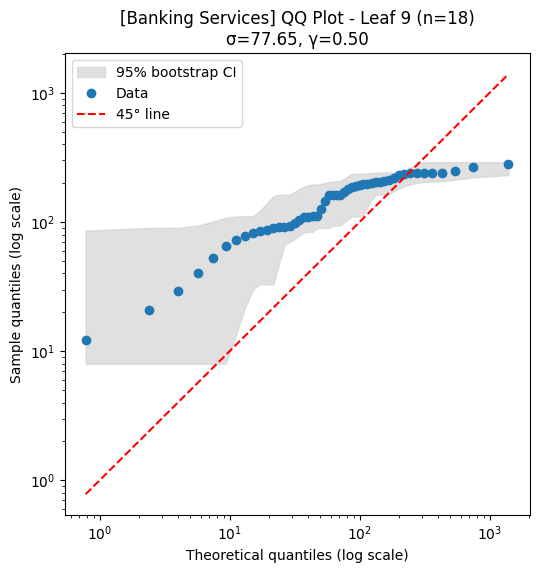

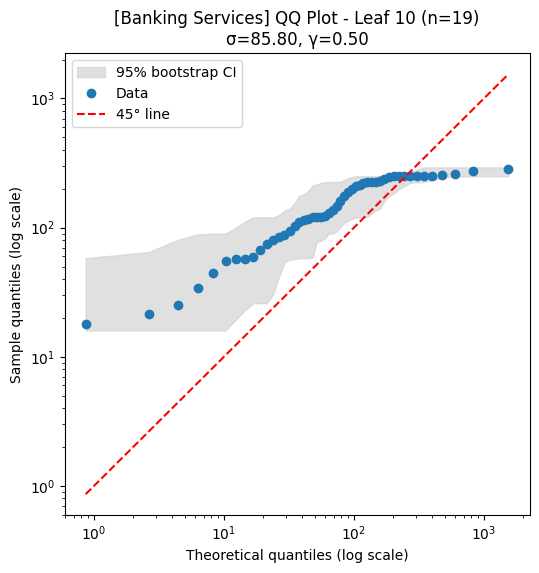

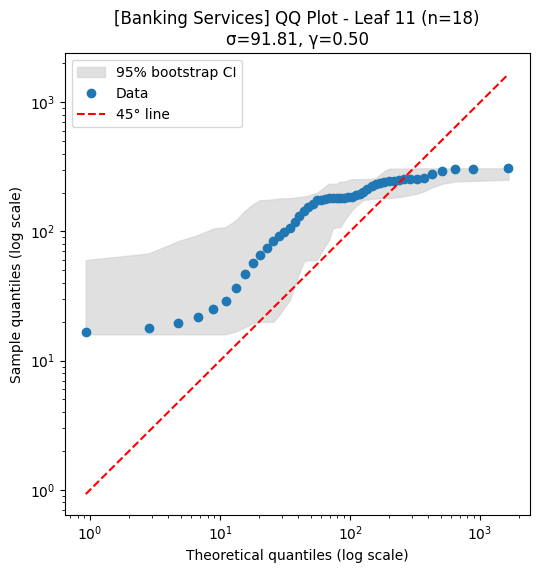

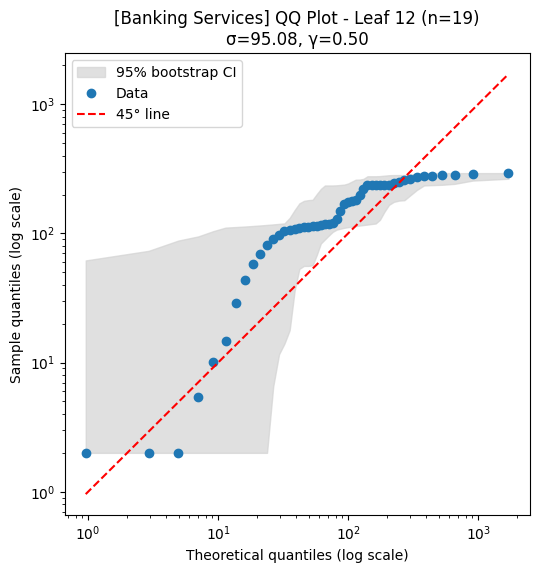

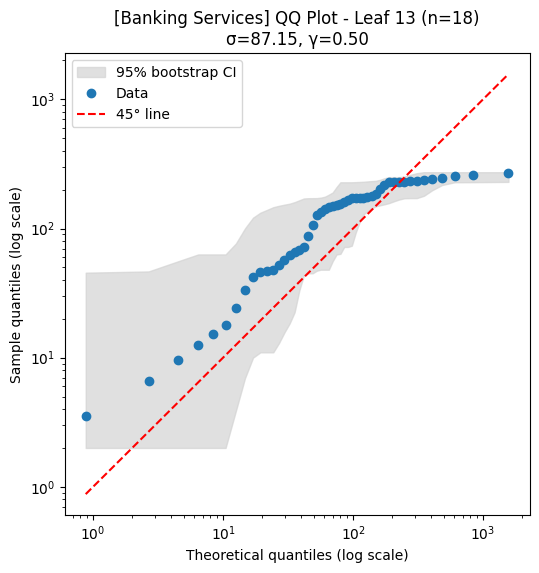

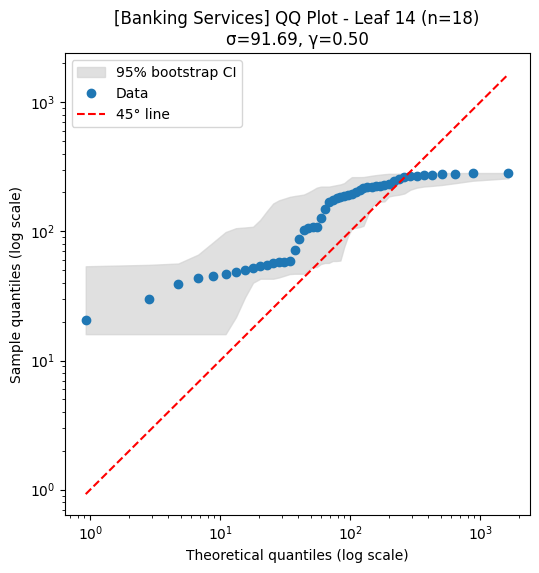

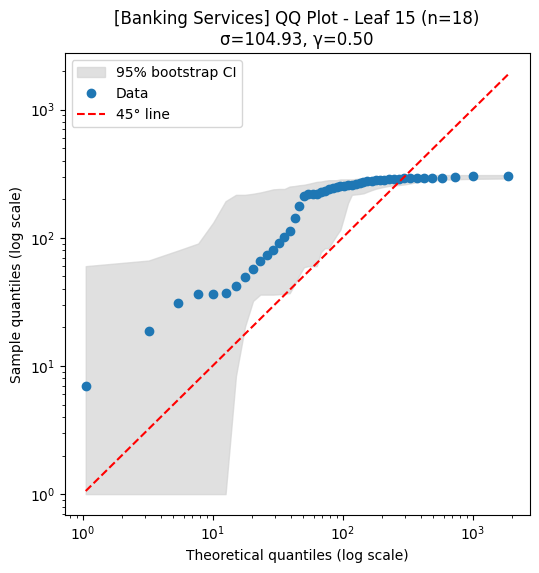



=== Running for: Corporate Finance & Agency ===
--- [Corporate Finance & Agency] 파이프라인이 스킵되었습니다. (데이터 부족) ---


=== Running for: Insurance ===
--- [Insurance] 파이프라인이 스킵되었습니다. (데이터 부족) ---


=== Running for: Securities & Trading ===
--- [Securities & Trading] 파이프라인이 스킵되었습니다. (데이터 부족) ---


=== Running for: Unmapped ===
--- [Unmapped] 파이프라인이 스킵되었습니다. (데이터 부족) ---


======== ALL PROCESSES FINISHED ========


In [34]:
# 1. 라이브러리 임포트
import pandas as pd
import numpy as np
import logging
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ks_2samp, chi2
from scipy.optimize import minimize

# 2. 전역 설정
# -------------------------------------------------------------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.unicode_minus'] = False

# --- Configuration --------------------------------------------------
TARGET_VARIABLE, DATE_COLUMN, START_YEAR = "Exceedance", "Date", 1985
u_threshold, MIN_TAIL_SAMPLES = 191, 50
selected_lags_dict = {'M1': [1], '7. Entitlement programs': [1], 'Unemployment Rate': [1], 'House Price Index': [1], 'CPI': [1], '9. Trade policy': [1]}
DAMAGE_TYPE_COLS, BUSINESS_LINE_COLS = [], ['Category_Advisory & Other Services', 'Category_Asset & Fund Management / Custody', 'Category_Banking Services', 'Category_Corporate Finance & Agency', 'Category_Insurance', 'Category_Securities & Trading', 'Category_Unmapped']
POLICY_INDEX_COLS = ['1. Economic Policy Uncertainty', '2. Monetary policy', 'Fiscal Policy (Taxes OR Spending)', '8. Regulation']
categorical_cols_master = DAMAGE_TYPE_COLS + BUSINESS_LINE_COLS + POLICY_INDEX_COLS

# 3. 시각화 및 분석 함수 (수정 없음)
# ... (이전 답변의 시각화 함수들을 여기에 붙여넣습니다)
def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    if root is None: root = next(iter(nx.topological_sort(G)))
    def _hierarchy_pos_recursive(G, root, width, vert_gap, vert_loc, xcenter, pos=None, parent=None):
        if pos is None: pos = {root: (xcenter, vert_loc)}
        else: pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if parent is not None and parent in children: children.remove(parent)
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos_recursive(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos
    return _hierarchy_pos_recursive(G, root, width, vert_gap, vert_loc, xcenter)

def draw_tree_graph(node, feature_names, tree_type='L1 Bulk', title_prefix=""):
    if not node:
        print(f"[{title_prefix}] {tree_type} Tree: 모델이 없습니다.")
        return
    graph = nx.DiGraph()
    node_id_counter = [0]
    def add_nodes_edges(n, parent_id=None):
        node_id = node_id_counter[0]; node_id_counter[0] += 1
        if n.get('is_leaf', False):
            params = n.get('params', {})
            if 'median' in params: label = f"Leaf(L1)\nN={n['n_samples']}\nmedian={params['median']:.2f}\nLN(μ={params['mu']:.2f}, σ={params['sigma']:.2f})"
            elif 'mean' in params: label = f"Leaf(L2)\nN={n['n_samples']}\nmean={params['mean']:.2f}\nLN(μ={params['mu']:.2f}, σ={params['sigma']:.2f})"
            elif 'gpd_sigma' in params: label = f"Leaf(GPD)\nN={n['n_samples']}\nσ={params['gpd_sigma']:.2f}, γ={params['gpd_gamma']:.2f}\nNLL={params['nll']:.1f}"
            else: label = f"Leaf\nN={n['n_samples']}"
        else:
            split_name = feature_names[n['feature_index']]
            label = f"{split_name} <= {n['threshold']:.2f}\nGain={n['gain']:.2f}\nN={n['n_samples']}"
        graph.add_node(node_id, label=label)
        if parent_id is not None: graph.add_edge(parent_id, node_id)
        if not n.get('is_leaf', False):
            if n.get('left_child'): add_nodes_edges(n['left_child'], node_id)
            if n.get('right_child'): add_nodes_edges(n['right_child'], node_id)
        return node_id
    root_id = add_nodes_edges(node)
    pos = hierarchy_pos(graph, root=root_id)
    labels = nx.get_node_attributes(graph, 'label')
    color_map = {'L1 Bulk': 'skyblue', 'L2 Bulk': 'lightcoral', 'GPD Tail': 'lightgreen'}
    plt.figure(figsize=(18, 10))
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=4000, node_color=color_map.get(tree_type, 'grey'), font_size=9, edge_color="gray", arrows=True, arrowsize=20, node_shape='s')
    plt.title(f"{title_prefix} {tree_type} Tree (Hierarchical Layout)")
    plt.axis("off"); plt.show()

# ... (기타 시각화/분석 함수들은 생략 없이 모두 포함되어야 합니다)
def find_leaf_node(node, feature_names, x_row):
    while not node.get('is_leaf', False):
        feature_idx = node['feature_index']
        if x_row[feature_idx] <= node['threshold']: node = node['left_child']
        else: node = node['right_child']
    return node
def assign_data_to_leaves(tree, feature_names, X, y):
    leaves = []
    def traverse(n):
        if n.get('is_leaf', False): leaves.append(n)
        else:
            if n.get('left_child'): traverse(n['left_child'])
            if n.get('right_child'): traverse(n['right_child'])
    if tree: traverse(tree)
    for i, leaf in enumerate(leaves): leaf['leaf_id'] = i
    leaf_data = {i: [] for i in range(len(leaves))}
    for i in range(len(X)):
        leaf = find_leaf_node(tree, feature_names, X[i])
        leaf_data[leaf['leaf_id']].append(y[i])
    return {k: np.array(v) for k, v in leaf_data.items()}, leaves
def plot_gp_tree_qq(gpd_tree, feature_names, X_high, y_high, title_prefix=""):
    if gpd_tree is None or len(y_high) == 0: return
    leaf_data, leaves = assign_data_to_leaves(gpd_tree, feature_names, X_high, y_high)
    ps = np.linspace(0.01, 0.99, 50)
    for leaf_id, y_leaf in leaf_data.items():
        if len(y_leaf) < 10: continue
        current_leaf = next((l for l in leaves if l.get('leaf_id') == leaf_id), None)
        if not current_leaf: continue
        sigma, gamma = current_leaf['params']['gpd_sigma'], current_leaf['params']['gpd_gamma']
        theo_q = sigma/gamma * ((1-ps)**(-gamma) - 1) if gamma != 0 else -sigma * np.log(1-ps)
        samp_q = np.percentile(y_leaf, ps * 100)
        boot_samples = np.array([np.percentile(np.random.choice(y_leaf, size=len(y_leaf), replace=True), ps * 100) for _ in range(500)])
        lo, hi = np.percentile(boot_samples, 2.5, axis=0), np.percentile(boot_samples, 97.5, axis=0)
        plt.figure(figsize=(6, 6))
        plt.fill_between(theo_q, lo, hi, color='lightgrey', alpha=0.7, label="95% bootstrap CI")
        plt.plot(theo_q, samp_q, 'o', label="Data")
        lims = [min(theo_q.min(), samp_q.min()), max(theo_q.max(), samp_q.max())]
        plt.plot(lims, lims, 'r--', label="45° line")
        plt.xscale('log'); plt.yscale('log')
        plt.xlabel("Theoretical quantiles (log scale)"); plt.ylabel("Sample quantiles (log scale)")
        plt.title(f"{title_prefix} QQ Plot - Leaf {leaf_id} (n={len(y_leaf)})\nσ={sigma:.2f}, γ={gamma:.2f}")
        plt.legend(); plt.show()


# 4. 목업(Mock-up) 및 파이프라인 함수
# -------------------------------------------------------------------
def create_lagged_features(df, target_col, lag_config, date_col, start_year, additional_features):
    df_copy = df.copy()
    df_copy = df_copy[df_copy[date_col].dt.year >= start_year]
    if df_copy.empty: return pd.DataFrame(), []
    for col, lags in lag_config.items():
        if col in df_copy.columns:
            for lag in lags: df_copy[f'{col}_lag{lag}'] = df_copy[col].shift(lag)
    df_copy.dropna(inplace=True)
    lagged_features = [f'{col}_lag{lag}' for col, lags in lag_config.items() for lag in lags]
    feature_names = lagged_features + additional_features
    final_cols = [target_col, date_col] + [f for f in feature_names if f in df_copy.columns]
    return df_copy[final_cols], feature_names

class MockL1L2GPD:
    def __init__(self): self.logging = logging
    def _create_mock_leaf(self, y_data, model_type='l1'):
        if len(y_data) == 0: return {'is_leaf': True, 'n_samples': 0, 'params': {}}
        params = {}
        if model_type == 'l1': params = {'median': np.median(y_data), 'mu': np.log(np.median(y_data)) if np.median(y_data) > 0 else 0, 'sigma': 1.5}
        elif model_type == 'l2': params = {'mean': np.mean(y_data), 'mu': np.log(np.mean(y_data)) if np.mean(y_data) > 0 else 0, 'sigma': 1.8}
        elif model_type == 'gpd': params = {'gpd_sigma': np.std(y_data), 'gpd_gamma': 0.5, 'nll': -np.sum(np.log(y_data + 1e-9))}
        return {'is_leaf': True, 'n_samples': len(y_data), 'params': params}
    def _create_mock_tree(self, X, y, feature_names, max_depth, model_type):
        if max_depth == 0 or len(y) < 20 or X.shape[0] < 2: return self._create_mock_leaf(y, model_type)
        variances = np.var(X, axis=0)
        if np.all(np.isnan(variances)): return self._create_mock_leaf(y, model_type)
        best_feature_idx = np.nanargmax(variances)
        threshold = np.nanmedian(X[:, best_feature_idx])
        left_mask, right_mask = X[:, best_feature_idx] <= threshold, X[:, best_feature_idx] > threshold
        return {'is_leaf': False, 'feature_index': best_feature_idx, 'threshold': threshold,'gain': np.var(y), 'n_samples': len(y),'left_child': self._create_mock_tree(X[left_mask], y[left_mask], feature_names, max_depth - 1, model_type),'right_child': self._create_mock_tree(X[right_mask], y[right_mask], feature_names, max_depth - 1, model_type)}

    ### ▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼ [TypeError 해결] 함수 정의의 파라미터 이름을 수정했습니다. ▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼ ###
    def grow_tree_l1(self, X, y, feature_names, min_leaf, max_depth):
        return self._create_mock_tree(X, y, feature_names, max_depth, 'l1')
    def grow_tree_l2(self, X, y, feature_names, min_leaf, max_depth):
        return self._create_mock_tree(X, y, feature_names, max_depth, 'l2')
    def grow_tree_gpd(self, X, y, feature_names, min_leaf, max_depth):
        return self._create_mock_tree(X, y, feature_names, max_depth, 'gpd')
    ### ▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲ ###

    def assign_lognorm_params(self, *args, **kwargs): pass
    def prune_gpd_with_cv(self, raw_tree, *args, **kwargs): return raw_tree, 0
l1_l2_gpd = MockL1L2GPD()

def run_full_pipeline(df_raw, damage_col):
    df_cat = df_raw[df_raw[damage_col] == 1].copy()
    if df_cat.empty: return None, (None, None)
    cat_features = [c for c in categorical_cols_master if c != damage_col]

    # create_lagged_features에 전달되는 additional_features에 존재하는 컬럼만 필터링
    valid_additional_features = [f for f in cat_features if f in df_cat.columns]

    df_model_ready, feature_names = create_lagged_features(
        df=df_cat, target_col=TARGET_VARIABLE, lag_config=selected_lags_dict,
        date_col=DATE_COLUMN, start_year=START_YEAR, additional_features=valid_additional_features
    )
    if df_model_ready.empty: return None, (None, None)

    valid_feature_names = [f for f in feature_names if f in df_model_ready.columns]
    X_all = df_model_ready[valid_feature_names].values
    y_all = df_model_ready[TARGET_VARIABLE].values
    m_bulk, m_tail = y_all <= u_threshold, y_all > u_threshold
    X_bulk, y_bulk = X_all[m_bulk], y_all[m_bulk]
    X_tail, y_tail = X_all[m_tail], y_all[m_tail] - u_threshold

    # 모델 학습 전 데이터 유효성 검사
    l1_tree, l2_tree, gpd_tree = None, None, None
    if X_bulk.shape[0] > 0 and y_bulk.shape[0] > 0:
        l1_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, valid_feature_names, min_leaf=20, max_depth=3)
        l2_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, valid_feature_names, min_leaf=30, max_depth=4)

    if len(y_tail) >= MIN_TAIL_SAMPLES and X_tail.shape[0] > 0:
        raw_tree = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, valid_feature_names, min_leaf=15, max_depth=4)
        gpd_tree, _ = l1_l2_gpd.prune_gpd_with_cv(raw_tree, X_tail, y_tail, n_folds=min(5, max(2, len(y_tail)//10)))
    else: l1_l2_gpd.logging.info(f"[{damage_col}]: tail 샘플 {len(y_tail)}개 ({MIN_TAIL_SAMPLES}개 미만) → GPD 미적용")

    return {'l1_tree': l1_tree, 'l2_tree': l2_tree, 'gpd_tree': gpd_tree, 'feature_names': valid_feature_names}, (X_tail, y_tail)


# 5. 메인 실행 블록
# ===================================================================
if __name__ == '__main__':
    # --- 1. 예제 데이터프레임 생성 ---
    date_range = pd.to_datetime(pd.date_range(start='1980-01-01', end='2025-05-31', freq='ME'))
    n_samples = len(date_range)
    data = {DATE_COLUMN: date_range}
    feature_vars = list(selected_lags_dict.keys())
    for var in feature_vars: data[var] = np.random.randn(n_samples).cumsum() + 1000
    data[TARGET_VARIABLE] = np.random.randint(1, 500, size=n_samples)
    for col in (BUSINESS_LINE_COLS + POLICY_INDEX_COLS): data[col] = np.zeros(n_samples, dtype=int)
    df_temp = pd.DataFrame(data)
    df_temp.loc[100:600, 'Category_Banking Services'] = 1
    df_temp.loc[100:160, TARGET_VARIABLE] = np.random.randint(200, 500, size=len(df_temp.loc[100:160]))
    df_temp.loc[10:55, 'Category_Advisory & Other Services'] = 1
    df_temp.loc[400:500, 'Category_Asset & Fund Management / Custody'] = 1
    df_temp.loc[400:410, TARGET_VARIABLE] = np.random.randint(200, 500, size=len(df_temp.loc[400:410]))
    df_temp['Category_Unmapped'] = 0
    for col in POLICY_INDEX_COLS: df_temp[col] = np.random.randint(0, 2, size=n_samples)
    df_merged = df_temp

    # --- 2. 비즈니스 라인별 파이프라인 및 시각화 실행 ---
    print("======== STARTING MODELING & VISUALIZATION (WITH MOCK DATA) ========")
    for dmg_col in BUSINESS_LINE_COLS:
        cat_name = dmg_col.replace("Category_", "")
        print(f"\n\n{'='*25}\n=== Running for: {cat_name} ===\n{'='*25}")
        result, tail_data = run_full_pipeline(df_merged, dmg_col)
        if result:
            X_tail, y_tail = tail_data
            feature_names = result['feature_names']
            print(f"\n--- [{cat_name}] Tree Visualization ---")
            draw_tree_graph(result.get('l1_tree'), feature_names, tree_type='L1 Bulk', title_prefix=f"[{cat_name}]")
            draw_tree_graph(result.get('l2_tree'), feature_names, tree_type='L2 Bulk', title_prefix=f"[{cat_name}]")
            draw_tree_graph(result.get('gpd_tree'), feature_names, tree_type='GPD Tail', title_prefix=f"[{cat_name}]")
            if result.get('gpd_tree') and len(y_tail) > 0:
                print(f"\n--- [{cat_name}] GPD Model Diagnostics ---")
                plot_gp_tree_qq(result['gpd_tree'], feature_names, X_tail, y_tail, title_prefix=f"[{cat_name}]")
        else:
            print(f"--- [{cat_name}] 파이프라인이 스킵되었습니다. (데이터 부족) ---")
    print("\n\n======== ALL PROCESSES FINISHED ========")

#2008

In [ ]:
df_merged08=df_merged[df_merged['Date']<='2008']

In [ ]:
df_merged=df_merged08.copy()
df_merged.tail()

Date      10_2  House Price Index  House Price Index_diff           M1  \
8433  2008  1.652948           358.6525               -0.052805  1433.755769   
8434  2008  1.652948           358.6525               -0.052805  1433.755769   
8435  2008  1.652948           358.6525               -0.052805  1433.755769   
8436  2008  1.652948           358.6525               -0.052805  1433.755769   
8437  2008  1.652948           358.6525               -0.052805  1433.755769   

       M1_diff        CPI  CPI_diff  Unemployment Rate  \
8433  0.042229  215.25425   0.03744                5.8   
8434  0.042229  215.25425   0.03744                5.8   
8435  0.042229  215.25425   0.03744                5.8   
8436  0.042229  215.25425   0.03744                5.8   
8437  0.042229  215.25425   0.03744                5.8   

      Unemployment Rate_diff  ...  Category_Private Banking  \
8433                0.228185  ...                     False   
8434                0.228185  ...                     False   
8435                0.228185  ...                     False   
8436                0.228185  ...                     False   
8437                0.228185  ...                     False   

      Category_Professional Liability/Fidelity Coverage  \
8433                                              False   
8434                                              False   
8435                                              False   
8436                                              False   
8437                                              False   

      Category_Property and Casualty Insurance  \
8433                                     False   
8434                                     False   
8435                                     False   
8436                                     False   
8437                                     False   

      Category_Proprietary Positions  Category_Reinsurance  \
8433                           False                 False   
8434                           False                 False   
8435                           False                 False   
8436                           False                 False   
8437                           False                 False   

      Category_Retail Banking  Category_Retail Brokerage  Category_Sales  \
8433                    False                      False           False   
8434                    False                      False            True   
8435                     True                      False           False   
8436                    False                      False           False   
8437                     True                      False           False   

      Category_Treasury  Exceedance  
8433              False    2.189610  
8434              False    0.216472  
8435              False    0.329207  
8436              False    2.189610  
8437              False   49.406577  

[5 rows x 63 columns]

In [ ]:
if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1985

    # Granger Test based lags (example)
    selected_lags_dict = {


        'Close':[1]


    }


    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        l1_l2_gpd.logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)

#create_lagged_features
    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = l1_l2_gpd.create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        l1_l2_gpd.logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        l1_l2_gpd.logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values


        u_threshold=191
        #3500
        mask_bulk = y_all_data <= u_threshold
        mask_tail = ~mask_bulk

        X_bulk, y_bulk = X_all_data[mask_bulk], y_all_data[mask_bulk]
        # For GPD, fit excesses: y_tail = y_observed - u
        X_tail, y_tail = X_all_data[mask_tail], y_all_data[mask_tail] - u_threshold

        l1_l2_gpd.logging.info(f"Data split: Bulk = {len(y_bulk)} samples, Tail (Excesses) = {len(y_tail)} samples.")

        # Check if tail data is sufficient
        MIN_TAIL_SAMPLES = 50 # Minimum samples needed to reliably fit GPD tree
        if len(y_tail) < MIN_TAIL_SAMPLES:
             l1_l2_gpd.logging.warning(f"Tail dataset size ({len(y_tail)}) is small. GPD results may be unreliable.")
             # Consider alternative: Don't fit GPD tree, maybe use LogNormal for tail too, or simpler model.
             # For now, we proceed but with caution.

        # --- Model Fitting ---


        # 1) L1 CART (Median) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L1 CART (Median) for Bulk Data...")
        l1_bulk_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names_list, min_leaf=20, max_depth=3)
        l1_l2_gpd.assign_lognorm_params(l1_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)

        print("\n===== L1 CART (Bulk, Median-based) =====")
        l1_l2_gpd.print_tree_structure(l1_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l1_bulk_tree)


        # 2) L2 CART (Mean) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L2 CART (Mean) for Bulk Data...")
        l2_bulk_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, feature_names_list, min_leaf=30, max_depth=4)
        l1_l2_gpd.assign_lognorm_params(l2_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)
        print("\n===== L2 CART (Bulk, Mean-based) =====")
        l1_l2_gpd.print_tree_structure(l2_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l2_bulk_tree)

        # 3) GPD CART for Tail (Excesses)
        gpd_tail_tree_pruned = None
        if len(y_tail) >= MIN_TAIL_SAMPLES: # Only fit if enough tail data
            l1_l2_gpd.logging.info("Fitting GPD CART for Tail Data (Excesses)...")
            # Grow initial large tree
            gpd_tail_tree_raw = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, feature_names_list, min_leaf=15, max_depth=4) # Grow deeper initially

            print("\n===== Raw GPD CART (Tail, Excesses) =====")
            l1_l2_gpd.print_tree_structure(gpd_tail_tree_raw, feature_names_list)

            # Prune using CV
            l1_l2_gpd.logging.info("Pruning GPD CART using Cross-Validation...")
            try:
                # Adjust n_folds based on tail data size
                cv_folds = min(5, max(2, len(y_tail) // 10))
                gpd_tail_tree_pruned, best_alpha_gpd = l1_l2_gpd.prune_gpd_with_cv(gpd_tail_tree_raw, X_tail, y_tail, n_folds=cv_folds)
                l1_l2_gpd.logging.info(f"GPD CART Pruning complete. Best alpha = {best_alpha_gpd:.4g}")

                print("\n===== Pruned GPD CART (Tail, Excesses) =====")
                l1_l2_gpd.print_tree_structure(gpd_tail_tree_pruned, feature_names_list)
                l1_l2_gpd.validate_tree_structure(gpd_tail_tree_pruned, min_samples_leaf=10) # Check pruned tree
            except Exception as e:
                 l1_l2_gpd.logging.error(f"GPD Tree Pruning failed: {e}. Using raw tree.")
                 gpd_tail_tree_pruned = gpd_tail_tree_raw # Fallback to raw tree

        else:
            l1_l2_gpd.logging.warning("Skipping GPD CART fitting due to insufficient tail data.")

        l1_l2_gpd.logging.info("Script finished.")



===== L1 CART (Bulk, Median-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=3601.403) N=7941
  [Close_lag1 ≤ 921.9] (Gain=723.973) N=3997
    [Category_Commercial Banking ≤ 0.5] (Gain=47.296) N=784
      Leaf: N=608, median=4.48, LN(mu=4.85, sigma=3.72)
      Leaf: N=176, median=7.39, LN(mu=4.93, sigma=3.35)
    [Category_Commercial Banking ≤ 0.5] (Gain=277.807) N=3213
      Leaf: N=2678, median=1.16, LN(mu=4.61, sigma=4.85)
      Leaf: N=535, median=3.72, LN(mu=4.79, sigma=4.00)
  [Close_lag1 ≤ 775.4] (Gain=413.227) N=3944
    [Close_lag1 ≤ 306.2] (Gain=160.080) N=1106
      Leaf: N=276, median=14.75, LN(mu=5.02, sigma=2.71)
      Leaf: N=830, median=9.55, LN(mu=4.97, sigma=3.09)
    [Close_lag1 ≤ 1038] (Gain=316.821) N=2838
      Leaf: N=594, median=3.54, LN(mu=4.92, sigma=4.20)
      Leaf: N=2244, median=7.81, LN(mu=5.05, sigma=3.71)

===== L2 CART (Bulk, Mean-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=581787.885) N=7941
  

In [ ]:
graphs.gp_tree_lrt(gpd_tail_tree_pruned, X_tail, y_tail)

GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -3715.16
  단일 GP 로그우도: -4053.23
  LRT statistic = 676.13 (df = 4)
  p‑value = 5.141e-145 -> reject single GP model
  AIC (GP 트리) = 7442.33, AIC (단일 GP) = 8110.46


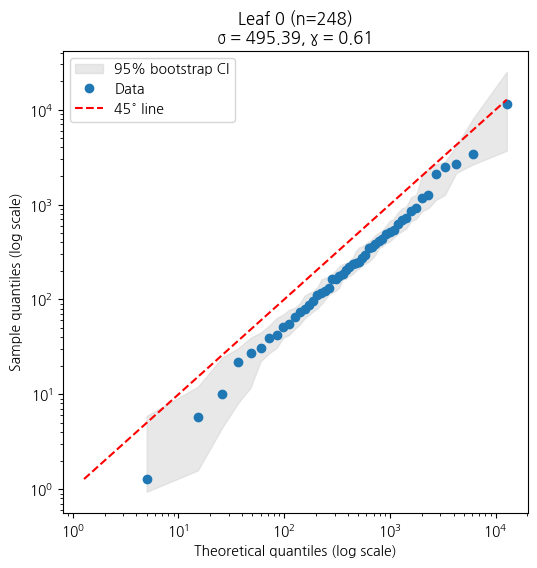

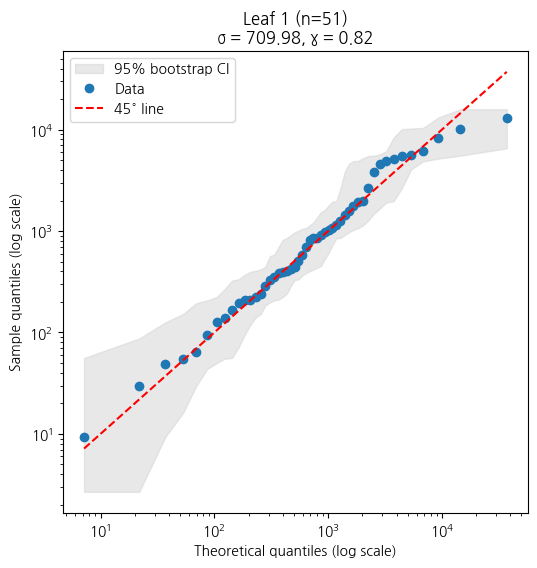

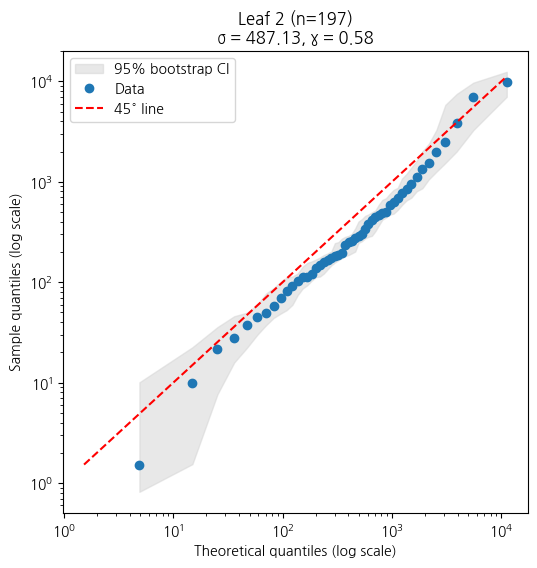

In [ ]:
graphs.plot_gp_tree_qq(gpd_tail_tree_pruned, X_tail, y_tail)


In [ ]:
import pickle

# --- __main__ 블록 마지막에 추가 ---
save_path = '/content/drive/MyDrive/Operational_risk/'
# 1) 저장할 객체들 모으기
output = {
    # Bulk 트리
    'l1_bulk_tree' : l1_bulk_tree,
    'l2_bulk_tree' : l2_bulk_tree,
    # Tail 트리
    'gpd_raw_tree' : gpd_tail_tree_raw,
    'gpd_pruned_tree' : gpd_tail_tree_pruned,
    # 데이터
    'X_bulk'       : X_bulk,
    'y_bulk'       : y_bulk,
    'X_tail'       : X_tail,
    'y_tail'       : y_tail,
    'X_all_data'   : X_all_data,
    'y_all_data'   : y_all_data,
    'df_model_ready':df_model_ready,
    # (선택) 피처 이름
    'feature_names': feature_names_list,
    # (선택) 임계값
    'u_threshold'  : u_threshold
}

# 2) 피클 파일로 저장
with open(save_path + 'risk_1985_2008.pkl', 'wb') as f:
    pickle.dump(output, f)

l1_l2_gpd.logging.info("Models and data have been saved to 'risk_1985_2008.pkl'")


##multivariate

In [ ]:
df_merged.columns

Index(['Date', '10_2', 'House Price Index', 'House Price Index_diff', 'M1',
       'M1_diff', 'CPI', 'CPI_diff', 'Unemployment Rate',
       'Unemployment Rate_diff', 'Close', 'Close_diff', 'Year_x',
       'Three_Component_Index', 'News_Based_Policy_Uncert_Index', 'Year_y',
       '1. Economic Policy Uncertainty', '2. Monetary policy',
       'Fiscal Policy (Taxes OR Spending)', '3. Taxes',
       '4. Government spending', '5. Health care', '6. National security',
       '7. Entitlement programs', '8. Regulation', 'Financial Regulation',
       '9. Trade policy', '10. Sovereign debt, currency crises',
       '9. Trade policy_diff', '7. Entitlement programs_diff',
       'Current Value of Loss',
       'Category_Business Disruption and System Failures',
       'Category_Clients, Products & Business Practices',
       'Category_Damage to Physical Assets',
       'Category_Employment Practices and Workplace Safety',
       'Category_Execution, Delivery & Process Management',
       'Cate

In [ ]:
# ---------------------------------------------------------------------#
# 8. Main Execution with Multivariate EVT CART
# ---------------------------------------------------------------------#
if __name__ == "__main__":
    # --- Configuration as before ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN     = "Date"
    START_YEAR      = 1985
    selected_lags_dict = {


        'M1_diff': [1],
        "1. Economic Policy Uncertainty": [1],
        '2. Monetary policy': [1],
        "Fiscal Policy (Taxes OR Spending)": [1],
        "5. Health care_diff": [1],
        "7. Entitlement programs_diff": [1],
        "Unemployment Rate_diff": [1],
        "House Price Index_diff": [1],
        "CPI_diff": [1]


    }


    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = ['Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking'

    ]

    # Granger-based lags, categorical_cols_list etc. are defined as in your original script
    # … (selected_lags_dict, categorical_cols_list) …

    # --- 1) Load or generate df_merged as before ---
    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        l1_l2_gpd.logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # … synthetic data generation as in original …

    # --- 2) Create lagged features ---
    df_model_ready, feature_names_list = l1_l2_gpd.create_lagged_features(
        df=df_merged,
        target_col=TARGET_VARIABLE,
        lag_config=selected_lags_dict,
        date_col=DATE_COLUMN,
        start_year=START_YEAR,
        additional_features=categorical_cols_list
    )

    # -----------------------------------------------------------------#
    # --- 3) Multivariate EVT preparation ---
    # -----------------------------------------------------------------#
    # 3.1 정의: 동시에 고려할 다변량 손실 컬럼들
    MULTI_LOSS_COLS = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud'
          # 인적 오류 손실
        # 필요한 만큼 추가…
    ]

category_cols = [c for c in df_model_ready.columns if c.startswith("Category_")]
if not category_cols:
    raise KeyError("데이터에 'Category_' 로 시작하는 원-핫 컬럼이 없습니다.")

# 3.2: 각 카테고리에 해당하는 손실액 = Exceedance * (카테고리 원-핫.astype(float))
#      → DataFrame.multiply 로 한 번에 처리
Y_multi = (
    df_model_ready[category_cols]
    .astype(float)
    .multiply(df_model_ready[TARGET_VARIABLE], axis=0)
    .values                        # shape = (n_samples, n_categories)
)

# 3.3: 반경(radial) 계산: 각 샘플의 다변량 손실 크기 (Euclidean norm)
radial = np.linalg.norm(Y_multi, ord=2, axis=1)

# 3.4: 각도(angle) 특성: loss_i / r
angles = np.divide(
    Y_multi,
    radial.reshape(-1, 1),
    out=np.zeros_like(Y_multi),
    where=radial.reshape(-1, 1) > 0
)

# 3.5: df_model_ready 에 radial/angle 컬럼 추가
for i, col in enumerate(category_cols):
    df_model_ready[f"{col}_angle"] = angles[:, i]
df_model_ready["radial"] = radial

# 3.6: feature_names_list 업데이트
feature_names_list += [f"{col}_angle" for col in category_cols]
feature_names_list.append("radial")

# ---------------------------------------------------------------------#
# 4. Bulk / Tail 분할 on radial
# ---------------------------------------------------------------------#
u_threshold = np.quantile(radial, 0.90)

mask_tail = radial > u_threshold
mask_bulk = ~mask_tail

X_all     = df_model_ready[feature_names_list].values
y_radial  = radial
X_bulk    = X_all[mask_bulk];   y_bulk    = y_radial[mask_bulk]
X_tail    = X_all[mask_tail];   y_tail_ex = y_radial[mask_tail] - u_threshold

# ---------------------------------------------------------------------#
# 5. 모델 피팅 (L1, L2, GPD CART)
# ---------------------------------------------------------------------#
# 5.1 L1 CART (Bulk)
l1_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names_list,
                       min_leaf=20, max_depth=3)
l1_l2_gpd.assign_lognorm_params(l1_tree, X_bulk, y_bulk, trunc_left=u_threshold)
print("\n===== L1 CART (Bulk) =====")
l1_l2_gpd.print_tree_structure(l1_tree, feature_names_list)

# 5.2 L2 CART (Bulk)
l2_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, feature_names_list,
                       min_leaf=30, max_depth=4)
l1_l2_gpd.assign_lognorm_params(l2_tree, X_bulk, y_bulk, trunc_left=u_threshold)
print("\n===== L2 CART (Bulk) =====")
l1_l2_gpd.print_tree_structure(l2_tree, feature_names_list)

# 5.3 GPD CART (Tail)
if len(y_tail_ex) >= 50:
    gpd_raw = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail_ex, feature_names_list,
                            min_leaf=15, max_depth=4)
    print("\n===== Raw GPD CART (Tail) =====")
    l1_l2_gpd.print_tree_structure(gpd_raw, feature_names_list)

    gpd_pruned, best_alpha = l1_l2_gpd.prune_gpd_with_cv(
        gpd_raw, X_tail, y_tail_ex,
        n_folds=min(5, max(2, len(y_tail_ex)//10))
    )
    l1_l2_gpd.logging.info(f"Best pruning alpha = {best_alpha:.4g}")
    print("\n===== Pruned GPD CART (Tail) =====")
    l1_l2_gpd.print_tree_structure(gpd_pruned, feature_names_list)
else:
    l1_l2_gpd.logging.warning("Tail 샘플 부족, GPD CART 생략")



===== L1 CART (Bulk) =====
[radial ≤ 5.854] (Gain=12279.926) N=9535
  [radial ≤ 1.316] (Gain=3600.412) N=8032
    [radial ≤ 0.3296] (Gain=657.208) N=6171
      Leaf: N=4809, median=0.00, LN(mu=-1.64, sigma=0.32)
      Leaf: N=1362, median=0.66, LN(mu=-0.40, sigma=0.41)
    [radial ≤ 3.247] (Gain=968.990) N=1861
      Leaf: N=1192, median=2.11, LN(mu=0.74, sigma=0.25)
      Leaf: N=669, median=4.39, LN(mu=1.47, sigma=0.16)
  [radial ≤ 13.71] (Gain=3379.519) N=1503
    [radial ≤ 9.336] (Gain=890.781) N=918
      Leaf: N=515, median=7.29, LN(mu=1.99, sigma=0.14)
      Leaf: N=403, median=11.39, LN(mu=2.43, sigma=0.11)
    [radial ≤ 19.7] (Gain=1008.213) N=585
      Leaf: N=334, median=16.29, LN(mu=3.23, sigma=0.49)
      Leaf: N=251, median=23.14, LN(mu=3.63, sigma=0.44)

===== L2 CART (Bulk) =====
[radial ≤ 8.083] (Gain=196593.146) N=9535
  [radial ≤ 2.546] (Gain=20873.246) N=8392
    [radial ≤ 0.8736] (Gain=2444.682) N=7047
      [radial ≤ 0.2713] (Gain=215.313) N=5738
        Leaf: N=

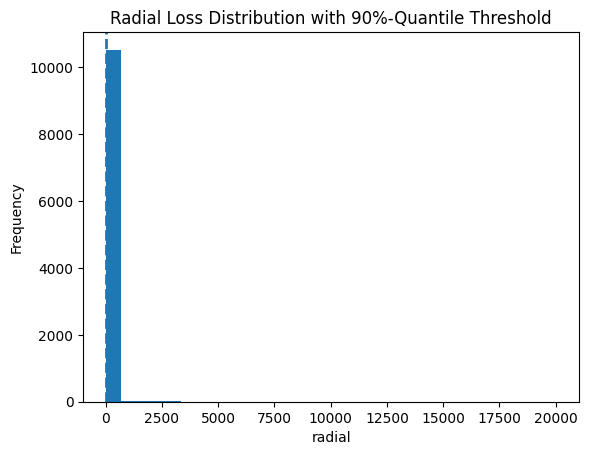

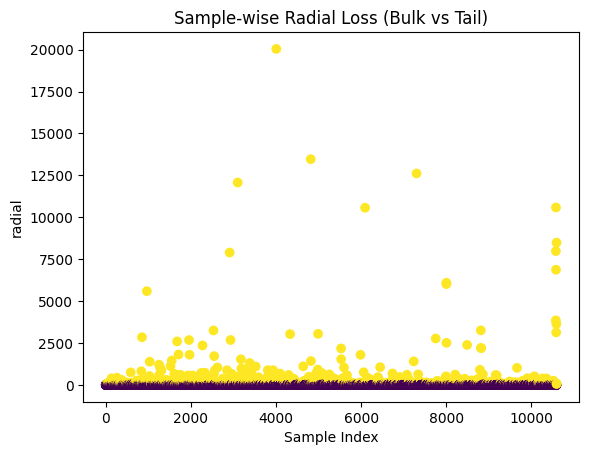

In [ ]:
# ---------------------------------------------------------------------#
# 6. Visualization
# ---------------------------------------------------------------------#
import matplotlib.pyplot as plt

# 6.1 Radial 분포 히스토그램
plt.figure()
plt.hist(radial, bins=30)
plt.axvline(u_threshold, linestyle='--', linewidth=2)
plt.title('Radial Loss Distribution with 90%-Quantile Threshold')
plt.xlabel('radial')
plt.ylabel('Frequency')
plt.show()

# 6.2 샘플별 Radial 값 (Bulk vs Tail)
plt.figure()
plt.scatter(range(len(radial)), radial, c=(radial > u_threshold))
plt.title('Sample-wise Radial Loss (Bulk vs Tail)')
plt.xlabel('Sample Index')
plt.ylabel('radial')
plt.show()


<Figure size 640x480 with 0 Axes>

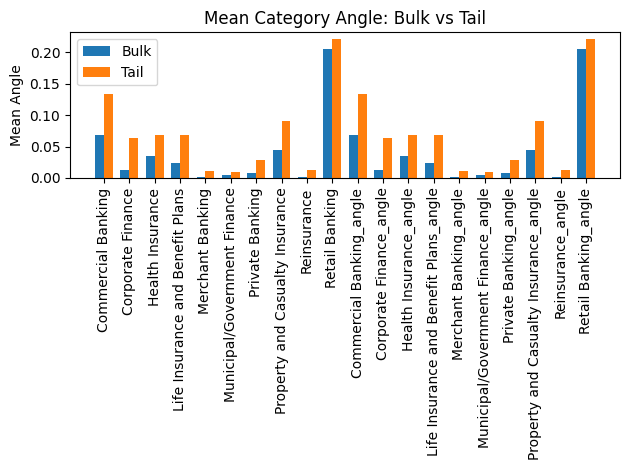

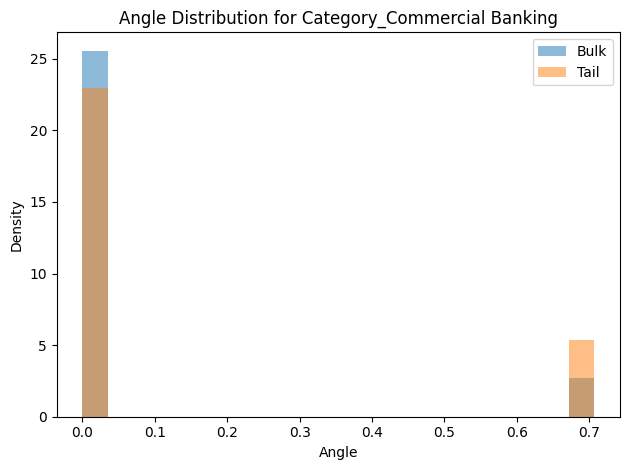

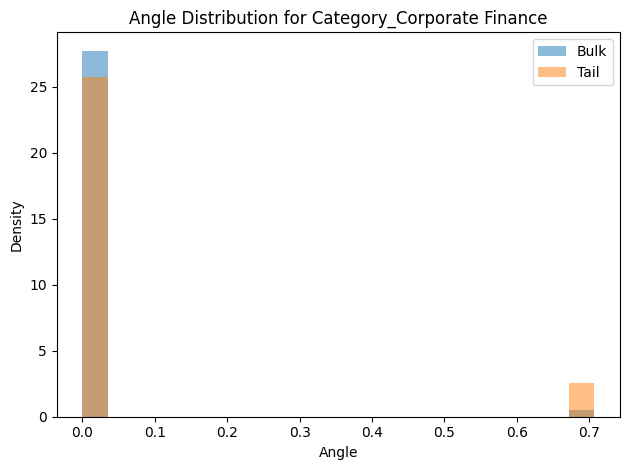

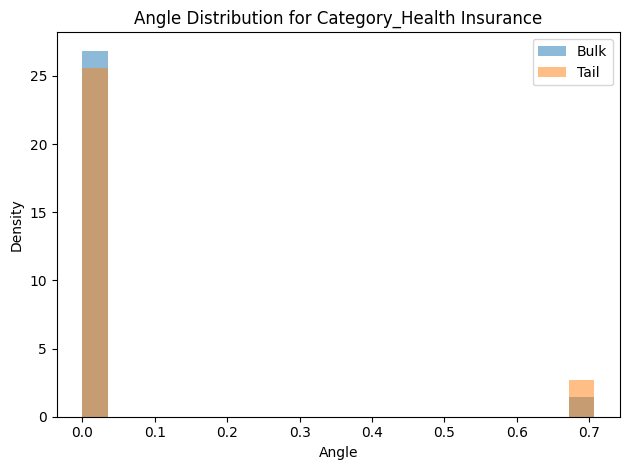

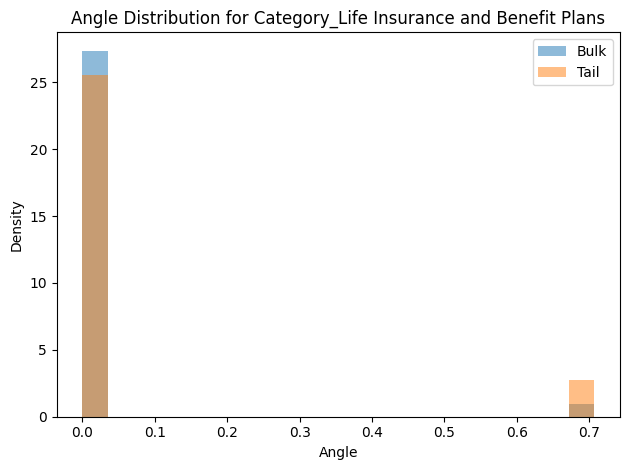

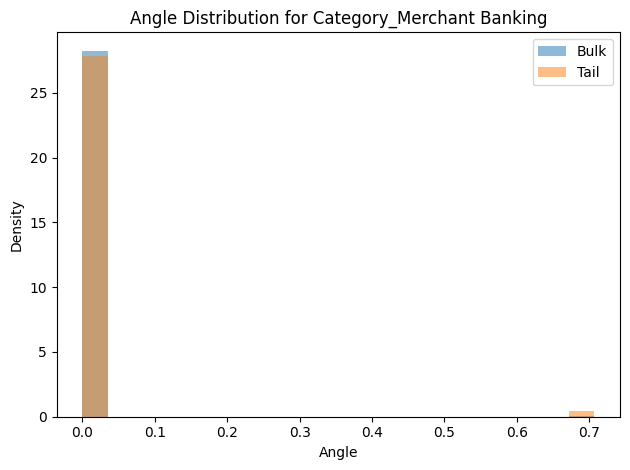

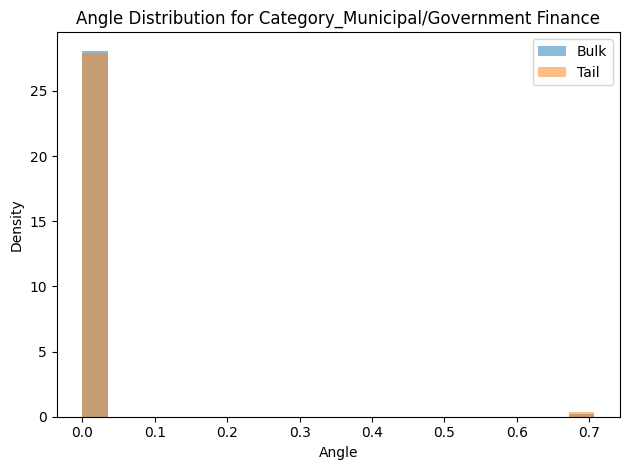

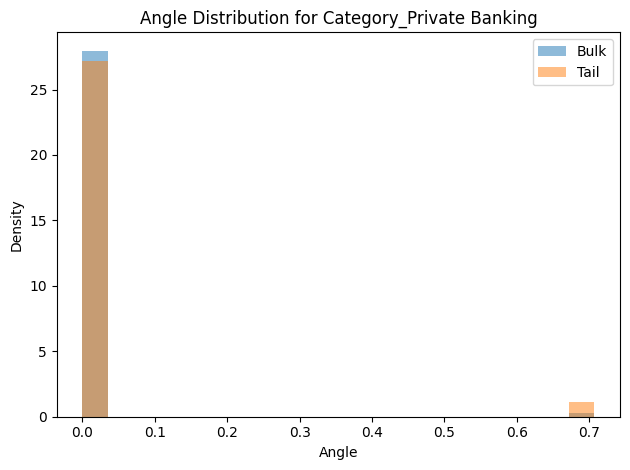

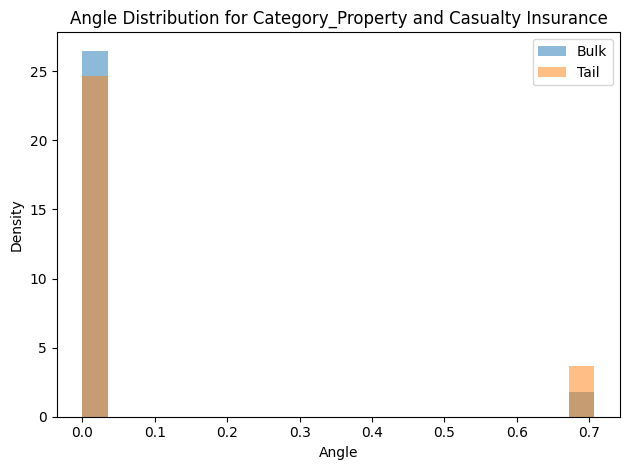

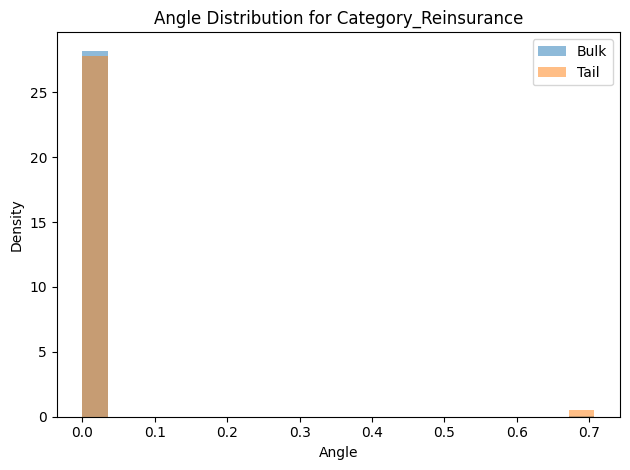

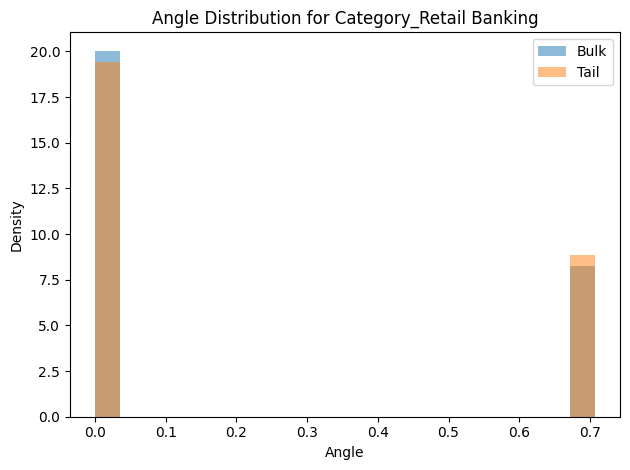

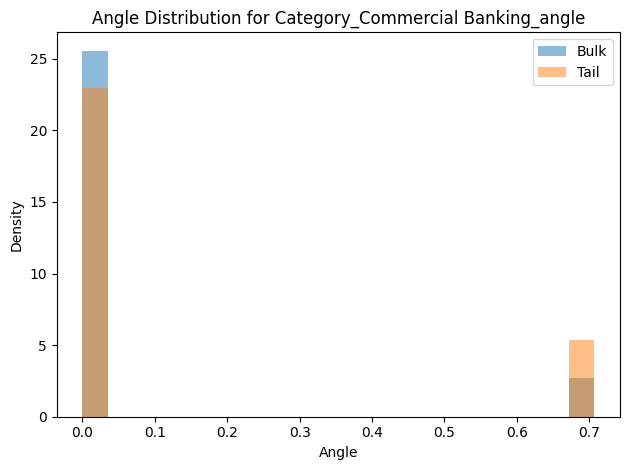

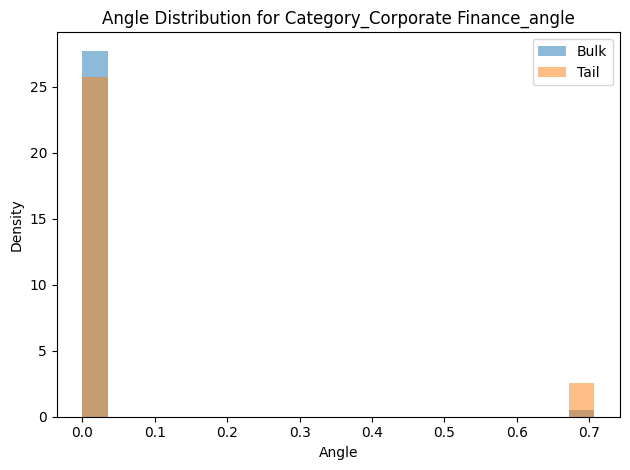

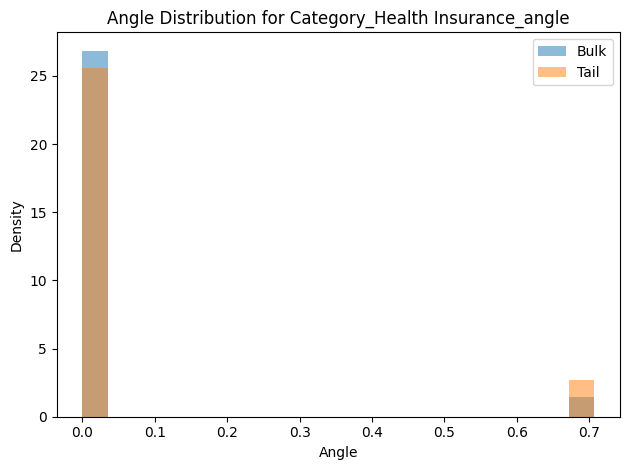

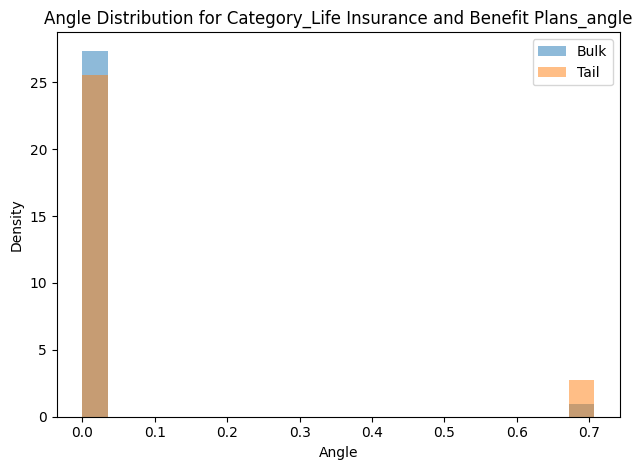

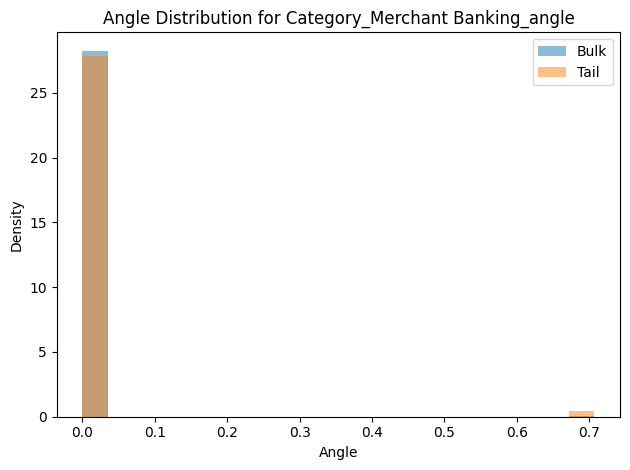

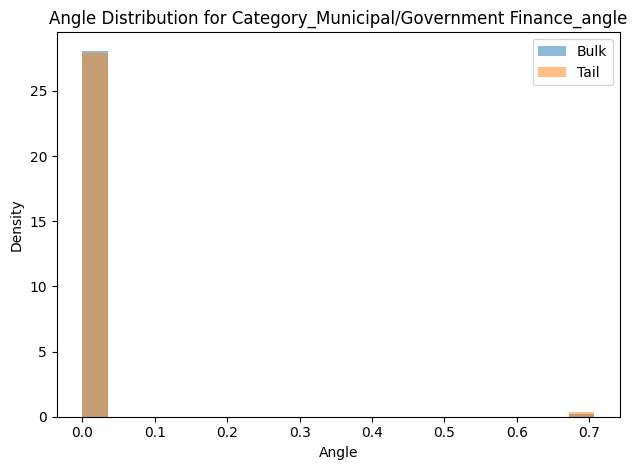

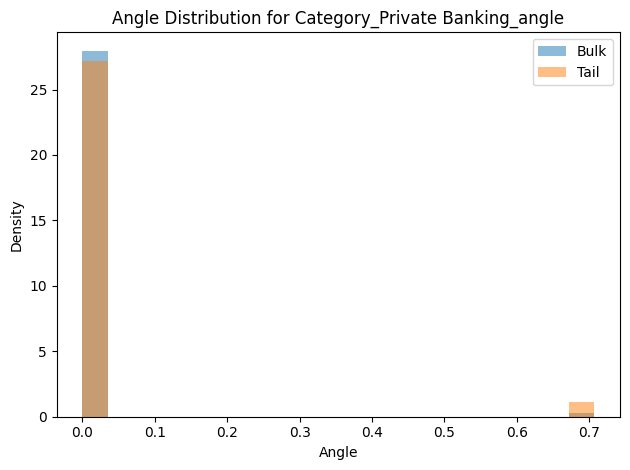

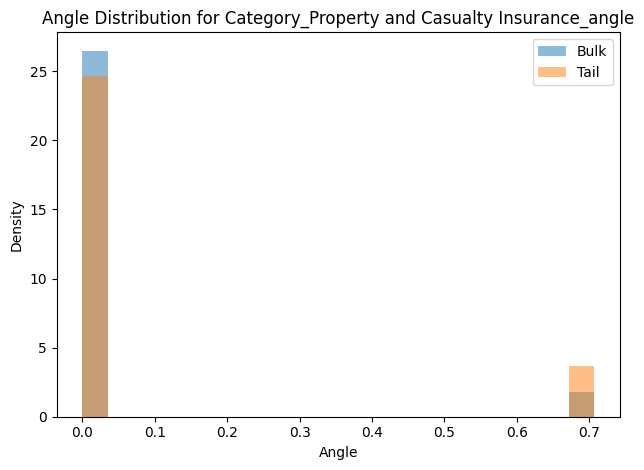

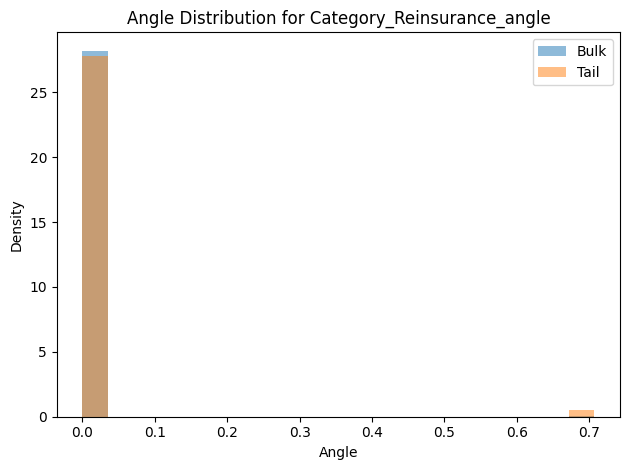

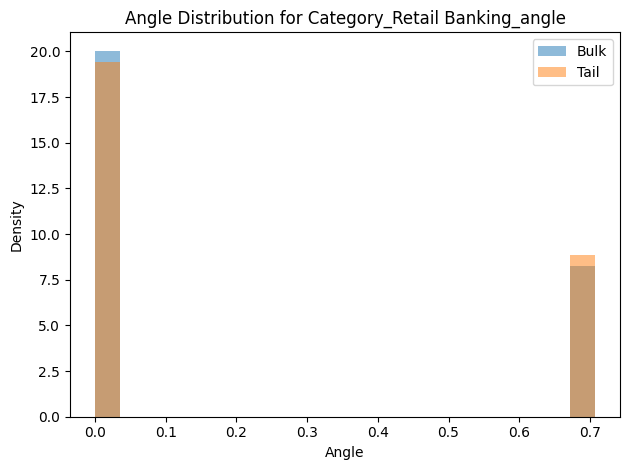

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 1) 자동으로 Category_ 컬럼 추출 ———
category_cols = [c for c in df_model_ready.columns if c.startswith("Category_")]
if not category_cols:
    raise KeyError("Category_ 로 시작하는 컬럼이 없습니다.")

# ——— 2) Y_multi, radial, angles 재계산 ———
Y_multi = df_model_ready[category_cols] \
              .astype(float) \
              .multiply(df_model_ready[TARGET_VARIABLE], axis=0) \
              .values
radial = np.linalg.norm(Y_multi, ord=2, axis=1)
angles = np.divide(
    Y_multi,
    radial.reshape(-1, 1),
    out=np.zeros_like(Y_multi),
    where=radial.reshape(-1, 1) > 0
)

# ——— 3) Bulk / Tail 마스크 ———
u_threshold = np.quantile(radial, 0.90)     # 상위 10% 꼬리
mask_tail  = radial > u_threshold
mask_bulk  = ~mask_tail

# ——— 4) 카테고리별 평균 각도 비교 바 차트 ———
bulk_means = angles[mask_bulk].mean(axis=0)
tail_means = angles[mask_tail].mean(axis=0)

x     = np.arange(len(category_cols))
width = 0.35

plt.figure()
fig, ax = plt.subplots()
ax.bar(x - width/2, bulk_means, width)
ax.bar(x + width/2, tail_means, width)
ax.set_xticks(x)
ax.set_xticklabels([c.replace('Category_', '') for c in category_cols], rotation=90)
ax.set_ylabel('Mean Angle')
ax.set_title('Mean Category Angle: Bulk vs Tail')
ax.legend(['Bulk', 'Tail'])
plt.tight_layout()
plt.show()

# ——— 5) 카테고리별 각도 분포 히스토그램 ———
for idx, col in enumerate(category_cols):
    plt.figure()
    plt.hist(angles[mask_bulk,   idx], bins=20, density=True, alpha=0.5)
    plt.hist(angles[mask_tail,   idx], bins=20, density=True, alpha=0.5)
    plt.title(f'Angle Distribution for {col}')
    plt.xlabel('Angle')
    plt.ylabel('Density')
    plt.legend(['Bulk', 'Tail'])
    plt.tight_layout()
    plt.show()


In [ ]:
print([c for c in df_model_ready.columns if c.startswith("Category_")])


['Category_Commercial Banking', 'Category_Corporate Finance', 'Category_Health Insurance', 'Category_Life Insurance and Benefit Plans', 'Category_Merchant Banking', 'Category_Municipal/Government Finance', 'Category_Private Banking', 'Category_Property and Casualty Insurance', 'Category_Reinsurance', 'Category_Retail Banking', 'Category_Commercial Banking_angle', 'Category_Corporate Finance_angle', 'Category_Health Insurance_angle', 'Category_Life Insurance and Benefit Plans_angle', 'Category_Merchant Banking_angle', 'Category_Municipal/Government Finance_angle', 'Category_Private Banking_angle', 'Category_Property and Casualty Insurance_angle', 'Category_Reinsurance_angle', 'Category_Retail Banking_angle']


In [ ]:
df_merged.head()

Date     10_2  House Price Index  House Price Index_diff          M1  \
103  1986  0.81236             136.35                 0.06607  666.057692   
104  1986  0.81236             136.35                 0.06607  666.057692   
105  1986  0.81236             136.35                 0.06607  666.057692   
106  1986  0.81236             136.35                 0.06607  666.057692   
107  1986  0.81236             136.35                 0.06607  666.057692   

      M1_diff         CPI  CPI_diff  Unemployment Rate  \
103  0.126388  109.691667  0.019253                7.0   
104  0.126388  109.691667  0.019253                7.0   
105  0.126388  109.691667  0.019253                7.0   
106  0.126388  109.691667  0.019253                7.0   
107  0.126388  109.691667  0.019253                7.0   

     Unemployment Rate_diff  ...  Category_Private Banking  \
103               -0.027013  ...                     False   
104               -0.027013  ...                     False   
105               -0.027013  ...                     False   
106               -0.027013  ...                     False   
107               -0.027013  ...                     False   

     Category_Professional Liability/Fidelity Coverage  \
103                                              False   
104                                              False   
105                                              False   
106                                              False   
107                                              False   

     Category_Property and Casualty Insurance  Category_Proprietary Positions  \
103                                     False                           False   
104                                     False                           False   
105                                     False                           False   
106                                     False                           False   
107                                     False                           False   

     Category_Reinsurance  Category_Retail Banking  Category_Retail Brokerage  \
103                 False                    False                       True   
104                 False                    False                       True   
105                 False                    False                       True   
106                 False                     True                      False   
107                 False                    False                      False   

     Category_Sales  Category_Treasury  Exceedance  
103           False              False    5.131399  
104           False              False   11.575481  
105           False              False    2.401671  
106           False              False    2.320485  
107            True              False   33.343786  

[5 rows x 65 columns]

##additional

#non EPU

In [ ]:
def create_lagged_features(
    df, target_col, lag_config, date_col, start_year, additional_features=None
):
    df = df.copy().sort_values(date_col).reset_index(drop=True)
    model_df = pd.DataFrame({date_col: df[date_col]})

    for var, lags in lag_config.items():
        if var.endswith("_diff"):
            base_var = var[:-5]
            log_series  = np.log(df[base_var])
            diff_series = log_series.diff()
            for lag in lags:
                # ← 여기만 수정: shift_amt = lag
                model_df[f"{var}_lag{lag}"] = diff_series.shift(lag)
        else:
            for lag in lags:
                model_df[f"{var}_lag{lag}"] = df[var].shift(lag)

    # 카테고리컬 컬럼과 타깃 붙이고, 시작 연도 필터링
    if additional_features:
        for cat in additional_features:
            model_df[cat] = df[cat]
    model_df[target_col] = df[target_col]

    # 연도 필터링
    model_df["Year"] = pd.to_datetime(df[date_col]).dt.year
    model_df = model_df[model_df["Year"] >= start_year].dropna().reset_index(drop=True)

    feature_names = [c for c in model_df.columns
                     if c not in (date_col, target_col, "Year")]
    return model_df, feature_names


In [ ]:
if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1985

    # Granger Test based lags (example)
    selected_lags_dict = {


        'M1': [1],
        "Unemployment Rate": [1],
        "House Price Index": [1],
        "CPI": [1],


    }


    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        l1_l2_gpd.logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)


    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        l1_l2_gpd.logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        l1_l2_gpd.logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values


        u_threshold=191
        #3500
        mask_bulk = y_all_data <= u_threshold
        mask_tail = ~mask_bulk

        X_bulk, y_bulk = X_all_data[mask_bulk], y_all_data[mask_bulk]
        # For GPD, fit excesses: y_tail = y_observed - u
        X_tail, y_tail = X_all_data[mask_tail], y_all_data[mask_tail] - u_threshold

        l1_l2_gpd.logging.info(f"Data split: Bulk = {len(y_bulk)} samples, Tail (Excesses) = {len(y_tail)} samples.")

        # Check if tail data is sufficient
        MIN_TAIL_SAMPLES = 50 # Minimum samples needed to reliably fit GPD tree
        if len(y_tail) < MIN_TAIL_SAMPLES:
             l1_l2_gpd.logging.warning(f"Tail dataset size ({len(y_tail)}) is small. GPD results may be unreliable.")
             # Consider alternative: Don't fit GPD tree, maybe use LogNormal for tail too, or simpler model.
             # For now, we proceed but with caution.

        # --- Model Fitting ---


        # 1) L1 CART (Median) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L1 CART (Median) for Bulk Data...")
        l1_bulk_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names_list, min_leaf=20, max_depth=3)
        l1_l2_gpd.assign_lognorm_params(l1_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)

        print("\n===== L1 CART (Bulk, Median-based) =====")
        l1_l2_gpd.print_tree_structure(l1_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l1_bulk_tree)


        # 2) L2 CART (Mean) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L2 CART (Mean) for Bulk Data...")
        l2_bulk_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, feature_names_list, min_leaf=30, max_depth=4)
        l1_l2_gpd.assign_lognorm_params(l2_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)
        print("\n===== L2 CART (Bulk, Mean-based) =====")
        l1_l2_gpd.print_tree_structure(l2_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l2_bulk_tree)

        # 3) GPD CART for Tail (Excesses)
        gpd_tail_tree_pruned = None
        if len(y_tail) >= MIN_TAIL_SAMPLES: # Only fit if enough tail data
            l1_l2_gpd.logging.info("Fitting GPD CART for Tail Data (Excesses)...")
            # Grow initial large tree
            gpd_tail_tree_raw = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, feature_names_list, min_leaf=15, max_depth=4) # Grow deeper initially

            print("\n===== Raw GPD CART (Tail, Excesses) =====")
            l1_l2_gpd.print_tree_structure(gpd_tail_tree_raw, feature_names_list)

            # Prune using CV
            l1_l2_gpd.logging.info("Pruning GPD CART using Cross-Validation...")
            try:
                # Adjust n_folds based on tail data size
                cv_folds = min(5, max(2, len(y_tail) // 10))
                gpd_tail_tree_pruned, best_alpha_gpd = l1_l2_gpd.prune_gpd_with_cv(gpd_tail_tree_raw, X_tail, y_tail, n_folds=cv_folds)
                l1_l2_gpd.logging.info(f"GPD CART Pruning complete. Best alpha = {best_alpha_gpd:.4g}")

                print("\n===== Pruned GPD CART (Tail, Excesses) =====")
                l1_l2_gpd.print_tree_structure(gpd_tail_tree_pruned, feature_names_list)
                l1_l2_gpd.validate_tree_structure(gpd_tail_tree_pruned, min_samples_leaf=10) # Check pruned tree
            except Exception as e:
                 l1_l2_gpd.logging.error(f"GPD Tree Pruning failed: {e}. Using raw tree.")
                 gpd_tail_tree_pruned = gpd_tail_tree_raw # Fallback to raw tree

        else:
            l1_l2_gpd.logging.warning("Skipping GPD CART fitting due to insufficient tail data.")

        l1_l2_gpd.logging.info("Script finished.")



===== L1 CART (Bulk, Median-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=3601.403) N=7941
  [House Price Index_lag1 ≤ 228.9] (Gain=739.333) N=3997
    [House Price Index_lag1 ≤ 185.3] (Gain=96.871) N=1076
      Leaf: N=524, median=5.72, LN(mu=4.90, sigma=3.46)
      Leaf: N=552, median=3.39, LN(mu=4.78, sigma=4.06)
    [Category_Commercial Banking ≤ 0.5] (Gain=250.997) N=2921
      Leaf: N=2443, median=1.09, LN(mu=4.59, sigma=4.90)
      Leaf: N=478, median=3.65, LN(mu=4.78, sigma=4.03)
  [House Price Index_lag1 ≤ 244.8] (Gain=579.050) N=3944
    [M1_lag1 ≤ 778.2] (Gain=189.300) N=1861
      Leaf: N=276, median=14.75, LN(mu=5.02, sigma=2.71)
      Leaf: N=1585, median=9.55, LN(mu=5.01, sigma=3.24)
    [Unemployment Rate_lag1 ≤ 4.612] (Gain=202.049) N=2083
      Leaf: N=286, median=11.10, LN(mu=5.10, sigma=3.60)
      Leaf: N=1797, median=5.05, LN(mu=5.00, sigma=4.02)

===== L2 CART (Bulk, Mean-based) =====
[Category_Clients, Products & Business Practices 

In [ ]:
graphs.gp_tree_lrt(gpd_tail_tree_pruned, X_tail, y_tail)


GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -3707.00
  단일 GP 로그우도: -4053.23
  LRT statistic = 692.45 (df = 4)
  p‑value = 1.504e-148 -> reject single GP model
  AIC (GP 트리) = 7426.01, AIC (단일 GP) = 8110.46


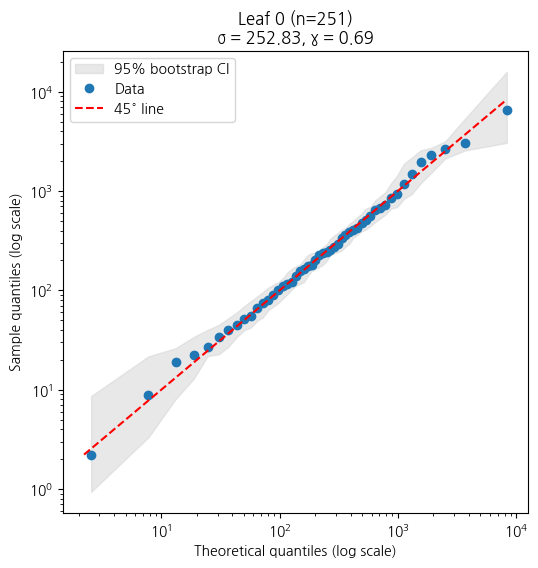

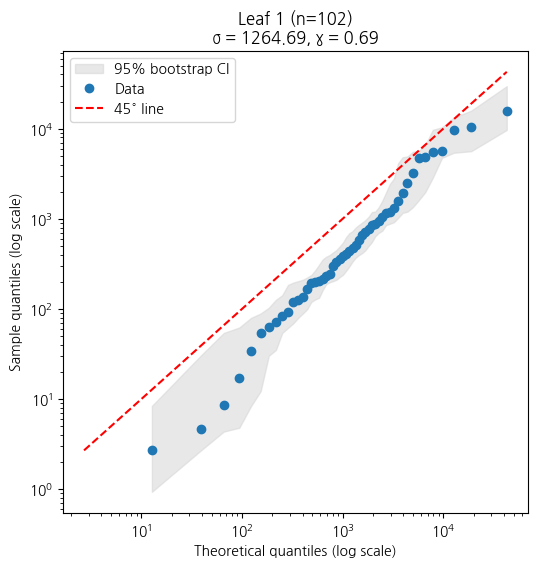

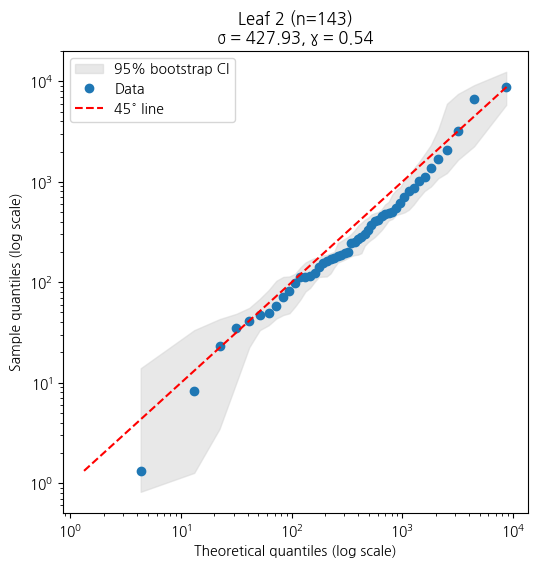

In [ ]:
graphs.plot_gp_tree_qq(gpd_tail_tree_pruned, X_tail, y_tail)


In [ ]:
import pickle

# --- __main__ 블록 마지막에 추가 ---
save_path = '/content/drive/MyDrive/Operational_risk/'
# 1) 저장할 객체들 모으기
output = {
    # Bulk 트리
    'l1_bulk_tree' : l1_bulk_tree,
    'l2_bulk_tree' : l2_bulk_tree,
    # Tail 트리
    'gpd_raw_tree' : gpd_tail_tree_raw,
    'gpd_pruned_tree' : gpd_tail_tree_pruned,
    # 데이터
    'X_bulk'       : X_bulk,
    'y_bulk'       : y_bulk,
    'X_tail'       : X_tail,
    'y_tail'       : y_tail,
    'X_all_data'   : X_all_data,
    'y_all_data'   : y_all_data,
    'df_model_ready':df_model_ready,
    # (선택) 피처 이름
    'feature_names': feature_names_list,
    # (선택) 임계값
    'u_threshold'  : u_threshold
}

# 2) 피클 파일로 저장
with open(save_path + 'risk_1985_2021_fixed_non.pkl', 'wb') as f:
    pickle.dump(output, f)

l1_l2_gpd.logging.info("Models and data have been saved to 'risk_1985_2021_fixed_non.pkl'")


#rolling

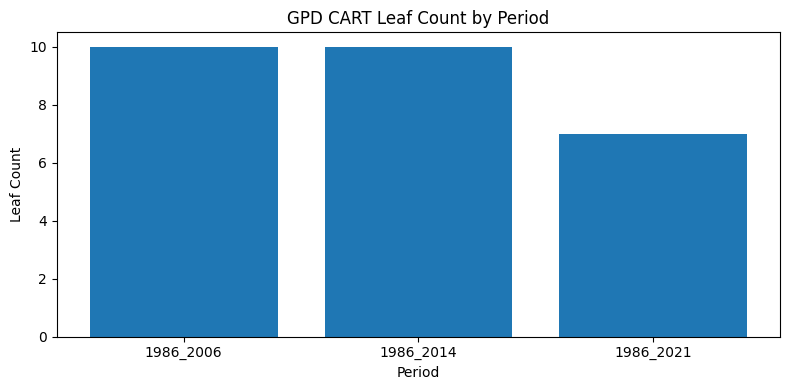

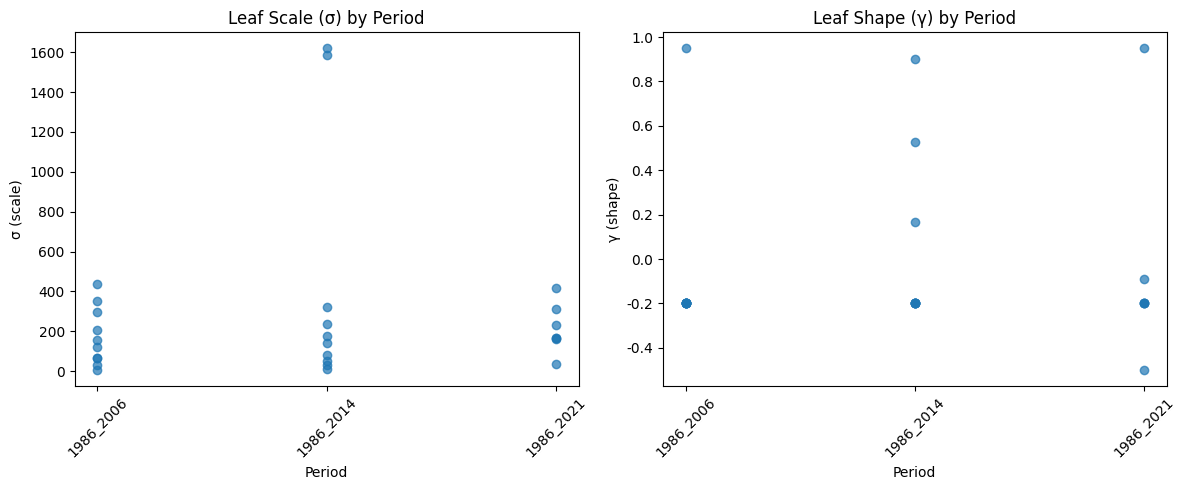

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hill_plot import select_threshold
import l1_l2_gpd

if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1986

    # Granger Test based lags (example)
    selected_lags_dict = {
        'M1_diff': [1],
        "1. Economic Policy Uncertainty": [1],
        '2. Monetary policy': [1],
        "Fiscal Policy (Taxes OR Spending)": [1],
        "5. Health care_diff": [1],
        "7. Entitlement programs_diff": [1],
        "Unemployment Rate_diff": [1],
        "House Price Index_diff": [1],
        "CPI_diff": [1]

    }

    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        l1_l2_gpd.logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)

    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = l1_l2_gpd.create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        l1_l2_gpd.logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        l1_l2_gpd.logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values

        # df_merged는 이미 준비되어 있다고 가정
        df = df_merged.copy()
        target_col = TARGET_VARIABLE
        date_col = DATE_COLUMN
        year_col = "Year" if "Year" in df.columns else date_col

        # 연도 컬럼을 int로 변환 (중요!)
        df[year_col] = df[year_col].astype(int)

        # 1. 임계값 자동 선정 (hill_plot 사용)
        u_hat, k_hat, gamma_hat = select_threshold(df[target_col].values)

        # 2. 분석 구간 설정
        intervals = [
            (1986, 2006),
            (1986, 2014),
            (1986, 2021)
        ]
        interval_labels = [f"{start}_{end}" for start, end in intervals]
        results = {}

        # 3. 각 구간별 분석
        for (start, end), label in zip(intervals, interval_labels):
            mask = (df[year_col] >= start) & (df[year_col] <= end)
            df_interval = df[mask].copy()
            tail_interval = df_interval[df_interval[target_col] > u_hat]
            y_tail_interval = tail_interval[target_col] - u_hat
            X_tail_interval = tail_interval.drop(columns=[target_col, date_col])

            # float 변환 후 NaN/inf 제거
            X_tail_interval_np = np.array(X_tail_interval, dtype=float)
            y_tail_interval_np = np.array(y_tail_interval, dtype=float)
            mask_valid = np.all(np.isfinite(X_tail_interval_np), axis=1) & np.isfinite(y_tail_interval_np)
            X_tail_interval = X_tail_interval_np[mask_valid]
            y_tail_interval = y_tail_interval_np[mask_valid]

            if len(y_tail_interval) > 30:
                tree_interval = l1_l2_gpd.grow_tree_gpd(X_tail_interval, y_tail_interval, tail_interval.drop(columns=[target_col, date_col]).columns.tolist(), min_leaf=15, max_depth=4)
                leaves_interval = l1_l2_gpd._get_all_leaves(tree_interval)
                params_interval = [(leaf.gpd_params[0], leaf.gpd_params[1]) for leaf in leaves_interval if leaf.gpd_params is not None]
                results[label] = {"leaf_count": len(leaves_interval), "params": params_interval}
            else:
                results[label] = {"leaf_count": 0, "params": []}

        # 4. 시각화
        years = interval_labels
        leaf_counts = [results[y]["leaf_count"] for y in years]
        plt.figure(figsize=(8, 4))
        plt.bar(years, leaf_counts)
        plt.title("GPD CART Leaf Count by Period")
        plt.xlabel("Period")
        plt.ylabel("Leaf Count")
        plt.tight_layout()
        plt.show()

        # 각 리프의 σ, γ boxplot/scatter
        sigmas = []
        gammas = []
        year_labels = []
        for y in years:
            for sigma, gamma in results[y]["params"]:
                sigmas.append(sigma)
                gammas.append(gamma)
                year_labels.append(str(y))

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(year_labels, sigmas, alpha=0.7)
        plt.title("Leaf Scale (σ) by Period")
        plt.ylabel("σ (scale)")
        plt.xlabel("Period")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.scatter(year_labels, gammas, alpha=0.7)
        plt.title("Leaf Shape (γ) by Period")
        plt.ylabel("γ (shape)")
        plt.xlabel("Period")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



===== GPD CART (1986_2006) =====
[House Price Index_diff ≤ 0.08087] (PenalizedGain=18.018) N=398
  [Fiscal Policy (Taxes OR Spending) ≤ 139] (PenalizedGain=6.995) N=321
    Leaf: N=285, GPD(σ=259.352, γ=0.702), NLL=2069.0
    Leaf: N=36, GPD(σ=1658.238, γ=0.860), NLL=296.7
  Leaf: N=77, GPD(σ=536.551, γ=0.878), NLL=628.6

===== GPD CART (2007_2021) =====
[Category_Retail Banking ≤ 0.5] (PenalizedGain=3.628) N=157
  Leaf: N=120, GPD(σ=253.620, γ=0.573), NLL=853.0
  Leaf: N=37, GPD(σ=1170.667, γ=0.751), NLL=302.5


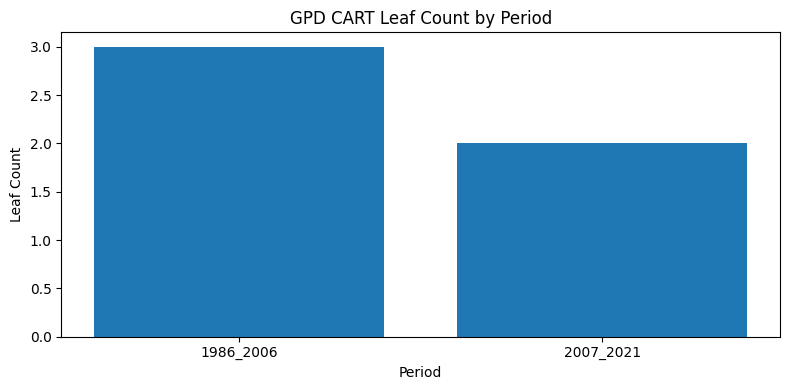

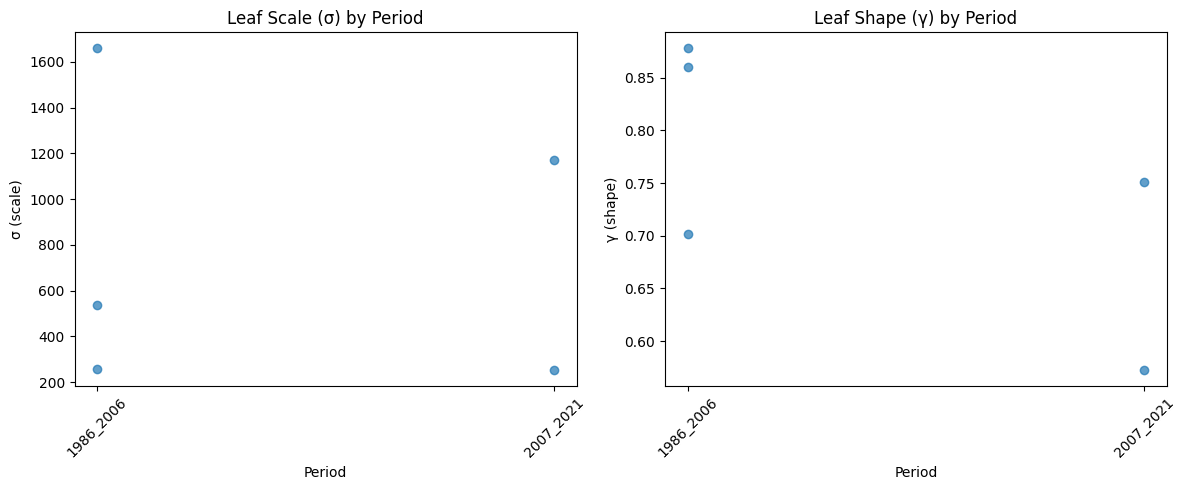

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hill_plot import select_threshold
import l1_l2_gpd

if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1986

    # Granger Test based lags (example)
    selected_lags_dict = {
        'M1_diff': [1],
        "1. Economic Policy Uncertainty": [1],
        '2. Monetary policy': [1],
        "Fiscal Policy (Taxes OR Spending)": [1],
        "5. Health care_diff": [1],
        "7. Entitlement programs_diff": [1],
        "Unemployment Rate_diff": [1],
        "House Price Index_diff": [1],
        "CPI_diff": [1]

    }

    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        l1_l2_gpd.logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)

    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = l1_l2_gpd.create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        l1_l2_gpd.logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        l1_l2_gpd.logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values

        # df_merged는 이미 준비되어 있다고 가정
        df = df_merged.copy()
        target_col = TARGET_VARIABLE
        date_col = DATE_COLUMN
        year_col = "Year" if "Year" in df.columns else date_col

        # 연도 컬럼을 int로 변환 (중요!)
        df[year_col] = df[year_col].astype(int)

        # 1. 임계값 자동 선정 (hill_plot 사용)
        u_hat, k_hat, gamma_hat = select_threshold(df[target_col].values)

        # 2. 분석 구간 설정
        intervals = [
            (1986, 2006),
            (2007, 2021)
        ]
        interval_labels = [f"{start}_{end}" for start, end in intervals]
        results = {}

        # 사용할 feature 컬럼 지정
        feature_cols = list(selected_lags_dict.keys()) + categorical_cols_list

        # 3. 각 구간별 분석
        for (start, end), label in zip(intervals, interval_labels):
            mask = (df[year_col] >= start) & (df[year_col] <= end)
            df_interval = df[mask].copy()
            tail_interval = df_interval[df_interval[target_col] > u_hat]
            y_tail_interval = tail_interval[target_col] - u_hat
            X_tail_interval = tail_interval[feature_cols]

            # float 변환 후 NaN/inf 제거
            X_tail_interval_np = np.array(X_tail_interval, dtype=float)
            y_tail_interval_np = np.array(y_tail_interval, dtype=float)
            mask_valid = np.all(np.isfinite(X_tail_interval_np), axis=1) & np.isfinite(y_tail_interval_np)
            X_tail_interval = X_tail_interval_np[mask_valid]
            y_tail_interval = y_tail_interval_np[mask_valid]

            if len(y_tail_interval) > 30:
                tree_interval = l1_l2_gpd.grow_tree_gpd(X_tail_interval, y_tail_interval, feature_cols, min_leaf=15, max_depth=4)
                leaves_interval = l1_l2_gpd._get_all_leaves(tree_interval)
                params_interval = [(leaf.gpd_params[0], leaf.gpd_params[1]) for leaf in leaves_interval if leaf.gpd_params is not None]
                results[label] = {"leaf_count": len(leaves_interval), "params": params_interval}
                # 트리 구조 및 리프 파라미터 출력
                print(f"\n===== GPD CART ({label}) =====")
                l1_l2_gpd.print_tree_structure(tree_interval, feature_cols)
            else:
                results[label] = {"leaf_count": 0, "params": []}

        # 4. 시각화
        years = interval_labels
        leaf_counts = [results[y]["leaf_count"] for y in years]
        plt.figure(figsize=(8, 4))
        plt.bar(years, leaf_counts)
        plt.title("GPD CART Leaf Count by Period")
        plt.xlabel("Period")
        plt.ylabel("Leaf Count")
        plt.tight_layout()
        plt.show()

        # 각 리프의 σ, γ boxplot/scatter
        sigmas = []
        gammas = []
        year_labels = []
        for y in years:
            for sigma, gamma in results[y]["params"]:
                sigmas.append(sigma)
                gammas.append(gamma)
                year_labels.append(str(y))

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(year_labels, sigmas, alpha=0.7)
        plt.title("Leaf Scale (σ) by Period")
        plt.ylabel("σ (scale)")
        plt.xlabel("Period")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.scatter(year_labels, gammas, alpha=0.7)
        plt.title("Leaf Shape (γ) by Period")
        plt.ylabel("γ (shape)")
        plt.xlabel("Period")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


#Premium

In [ ]:
import pandas as pd
import pickle, joblib, os, warnings
from l1_l2_gpd import find_leaf
import joblib, numpy as np, pandas as pd
# ──────────────────────────────────────────────
# ① 파일 로더 (dict → DataFrame 자동 변환)
# ──────────────────────────────────────────────
def load_risk_data(pkl_path, df_key=None):
    """
    pkl_path : .pkl 파일 경로
    df_key   : top-level dict 에서 DataFrame 을 골라낼 키
               (dict 이고 key 미지정 → 키 목록만 보여 주고 중단)
    반환     : pandas DataFrame
    """
    # 1단계: 일반적인 read_pickle 시도
    try:
        obj = pd.read_pickle(pkl_path)
    except Exception as e1:
        # pandas 내부 버전 차이 등으로 실패 → joblib 로 한 번 더 시도
        try:
            obj = joblib.load(pkl_path)
        except Exception as e2:
            raise RuntimeError(f"pickle 로드 실패:\n{e1}\n{e2}")

    # 2단계: 타입별 핸들링
    if isinstance(obj, pd.DataFrame):
        return obj

    if isinstance(obj, dict):
        # dict 값 중 DataFrame 이 여러 개일 수도 → key 선택
        if df_key is None:
            print("➡ dict 형식으로 열렸습니다. 포함된 키 목록:")
            print(list(obj.keys()))
            raise ValueError("DataFrame 으로 변환할 키(df_key)를 지정해 주세요.")
        if df_key not in obj:
            raise KeyError(f"'{df_key}' 키를 dict 에서 찾지 못했습니다.")
        df = obj[df_key]
        if not isinstance(df, pd.DataFrame):
            # dict 안에 또 dict 가 들어 있는 경우
            df = pd.DataFrame(df)
        return df

    # 그 밖의 타입이면 사용자가 직접 확인하도록 안내
    raise TypeError(f"지원되지 않는 객체 타입: {type(obj)}")

# ──────────────────────────────────────────────
# ② 보험료 계산 (이전 답변 그대로) ── 예시 호출
# ──────────────────────────────────────────────
from math import inf
import numpy as np
from scipy.stats import lognorm

def fit_lognormal_below_u(claims, u):
    """
    claims : 원손해액 1-차원 배열/Series
    u      : 임계값
    반환   : (μ̂, σ̂)  – 로그정규 모수 (log-scale)
    """
    y_low = claims[(claims > 0) & (claims <= u)]   # 0 제거!
    if len(y_low) < 5:                             # 표본 부족 시 백업
        # claims 가 전부 0 일 수도 있으므로 예외 처리
        return np.log(y_low + 1e-6).mean(), np.log(y_low + 1e-6).std(ddof=1)+1e-6
    shape, loc, scale = lognorm.fit(y_low, floc=0)
    return np.log(scale), shape

def expected_loss_per_claim(row, mu_low, sigma_low):
    p  = row.get("prob_exceed_hat", 1.0 if row["Exceedance"] > 0 else 0.0)
    u  = row.get("Threshold_u", GLOBAL_THRESHOLD_U)
    sg = row["sigma_hat"]; gm = row["gamma_hat"]
    exc = inf if gm >= 1 else sg / (1 - gm)
    mean_low = np.exp(mu_low + 0.5 * sigma_low**2)
    return (1 - p) * mean_low + p * (u + exc)

def calc_premium(df, threshold_u=None, loading_theta=0.25, inflation=0.0):
    global GLOBAL_THRESHOLD_U
    if "Threshold_u" in df.columns:
        GLOBAL_THRESHOLD_U = df["Threshold_u"].iloc[0]
    else:
        GLOBAL_THRESHOLD_U = threshold_u if threshold_u is not None else 1.0
        df["Threshold_u"] = GLOBAL_THRESHOLD_U

    # ── 수정된 부분: ClaimAmount 사용 ──
    mu_low, sigma_low = fit_lognormal_below_u(
        df["ClaimAmount"].values, GLOBAL_THRESHOLD_U
    )

    df["MuLoss"] = df.apply(expected_loss_per_claim, axis=1,
                            mu_low=mu_low, sigma_low=sigma_low)

    if "lambda_hat" not in df.columns:
        df["lambda_hat"] = 1.0

    df["PurePremium"] = df["lambda_hat"] * df["MuLoss"]
    if inflation:
        df["PurePremium"] *= (1 + inflation)
    df["Premium"] = df["PurePremium"] * (1 + loading_theta)
    return df


def gpd_predict_params(root, X):
    """
    root : NodeGPD 트리 (pruned·unpruned 상관없음)
    X    : (n_samples, n_features) ndarray
    반환 : shape = (n_samples, 2)  →  [:,0]=σ̂,  [:,1]=γ̂
    """
    sig, gam = [], []
    for xi in X:
        leaf = find_leaf(root, xi)      # 리프 탐색 :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}
        if leaf.gpd_params is None:     # 안전장치
            sig.append(np.nan);  gam.append(np.nan)
        else:
            s, g = leaf.gpd_params
            sig.append(s);      gam.append(g)
    return np.column_stack((sig, gam))

# ──────────────────────────────────────────────
# ③ 실제 실행
# ──────────────────────────────────────────────


# 0) 피클 열기 → DataFrame + 트리 객체
obj      = joblib.load("/content/risk_1985_2021_fixed (1).pkl")
df       = obj["df_model_ready"].copy()
X_all    = obj["X_all_data"]             # (n, p) ndarray
y_all    = obj["y_all_data"]
gpd_tree = obj["gpd_pruned_tree"]        # NodeGPD
u        = obj["u_threshold"]            # 임계값

# 1) 손해액·초과액 열
df["ClaimAmount"] = y_all
df["Exceedance"]  = np.maximum(y_all - u, 0.0)

# 2) (σ̂, γ̂) 붙이기
sigma_gamma          = gpd_predict_params(gpd_tree, X_all)
df["sigma_hat"]      = sigma_gamma[:, 0]
df["gamma_hat"]      = sigma_gamma[:, 1]

# 3) 빈도 λ̂ (없으면 1.0)
df["lambda_hat"]     = 1.0   # 예시 — 빈도 트리 예측값으로 교체 가능

# 4) 초과확률 p̂ (없으면 Exceedance>0)
df["prob_exceed_hat"] = (df["Exceedance"] > 0).astype(float)

# 5) 임계값 열
df["Threshold_u"] = u

# 6) 보험료 계산
df_prem = calc_premium(df,
                       loading_theta=0.30,
                       inflation=0.03)

print(df_prem[["lambda_hat", "MuLoss", "PurePremium", "Premium"]].head())

     lambda_hat     MuLoss  PurePremium    Premium
99          1.0  18.468827    19.022892  24.729759
100         1.0  18.468827    19.022892  24.729759
101         1.0  18.468827    19.022892  24.729759
102         1.0  18.468827    19.022892  24.729759
50          1.0  18.468827    19.022892  24.729759


#CPU

In [ ]:
import pandas as pd
import re

# ① CSV 읽기
cpu = pd.read_csv('/content/drive/MyDrive/CPU index.csv')[['date', 'cpu_index']]

# ② 전처리 ── 공백 제거
cpu['date'] = cpu['date'].str.strip()

# ③ 'YY-Mon' → 'Mon-YY' 로 재배열
cpu['date'] = cpu['date'].str.replace(
    r'^(\d{2})-([A-Za-z]{3})$',   # 2자리 연도-3자리 월
    r'\2-\1',                     # 월-연도로 바꾸기
    regex=True, flags=re.IGNORECASE
)

# ④ datetime 파싱
cpu['date'] = pd.to_datetime(cpu['date'], format='%b-%y', errors='coerce')

# ⑤ 원하는 포맷(문자열)으로 출력하거나, 월 Period 로도 사용 가능
cpu['date'] = cpu['date'].dt.strftime('%Y-%m')      # 문자열 형태


print(cpu.head())


      date  cpu_index
0  1987-04  43.589069
1  1987-05  41.862022
2  1987-06  71.135203
3  1987-07  53.756704
4  1987-08  60.615545


In [ ]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from scipy.stats import genpareto
import copy

#############################################
# 1. 데이터 전처리
#############################################
# (1) 엑셀 파일 읽기 및 날짜 정리
# 실제 파일 경로로 수정하세요.
sasop_path = '/content/drive/MyDrive/sasop.xlsx'
# 손실 데이터 (미국 사건만 선택)
df1 = pd.read_excel(sasop_path)



In [ ]:
df=df1.copy()

In [ ]:
us_df = df[df['Country of Incident'] == 'United States']
loss_df = us_df[['First Year of Event','Industry Sector Code','Basel Business Line - Level 2','Event Risk Category','Current Value of Loss ($M)']].copy()
loss_df.rename(columns={'First Year of Event':'Date', 'Current Value of Loss ($M)':'Current Value of Loss'}, inplace=True)
loss_df['Date'] = pd.to_datetime(loss_df['Date']).dt.strftime('%Y')
loss_df.sort_values(by='Date', inplace=True)
loss_df = loss_df[loss_df['Date'] >= '1979']


In [ ]:
loss_df_finance=loss_df[(loss_df['Industry Sector Code']==52)]

In [ ]:
np.shape(loss_df_finance)

(11115, 5)

In [ ]:
loss_df_finance.rename(columns={"Basel Business Line - Level 2":"Business"},inplace=True)

/tmp/ipython-input-286-416619696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance.rename(columns={"Basel Business Line - Level 2":"Business"},inplace=True)


In [ ]:
loss_df_finance.drop(columns=['Industry Sector Code'],inplace=True)

/tmp/ipython-input-287-1877426192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance.drop(columns=['Industry Sector Code'],inplace=True)


In [ ]:
loss_df_finance.head()

Date                                  Business  \
1799  1979                        Commercial Banking   
4667  1979  Professional Liability/Fidelity Coverage   
1282  1979                            Retail Banking   
1654  1979                        Commercial Banking   
1707  1979                        Commercial Banking   

                         Event Risk Category  Current Value of Loss  
1799  Clients, Products & Business Practices               8.844700  
4667  Clients, Products & Business Practices               4.219065  
1282                          Internal Fraud               2.304687  
1654                          Internal Fraud              12.408634  
1707  Clients, Products & Business Practices               6.328597

In [ ]:
# Encode 'Event Risk Category'
df_encoded_a = pd.get_dummies(loss_df_finance, columns=['Event Risk Category'], prefix='Category')



In [ ]:
# Use the result of the first encoding as input for the second encoding
df_encoded_b = pd.get_dummies(df_encoded_a, columns=['Business'], prefix='Category')

# Final encoded DataFrame
loss_df_finance = df_encoded_b.copy()


In [ ]:
loss_df_finance.head()

Date  Current Value of Loss  \
1799  1979               8.844700   
4667  1979               4.219065   
1282  1979               2.304687   
1654  1979              12.408634   
1707  1979               6.328597   

      Category_Business Disruption and System Failures  \
1799                                             False   
4667                                             False   
1282                                             False   
1654                                             False   
1707                                             False   

      Category_Clients, Products & Business Practices  \
1799                                             True   
4667                                             True   
1282                                            False   
1654                                            False   
1707                                             True   

      Category_Damage to Physical Assets  \
1799                               False   
4667                               False   
1282                               False   
1654                               False   
1707                               False   

      Category_Employment Practices and Workplace Safety  \
1799                                              False    
4667                                              False    
1282                                              False    
1654                                              False    
1707                                              False    

      Category_Execution, Delivery & Process Management  \
1799                                              False   
4667                                              False   
1282                                              False   
1654                                              False   
1707                                              False   

      Category_External Fraud  Category_Internal Fraud  \
1799                    False                    False   
4667                    False                    False   
1282                    False                     True   
1654                    False                     True   
1707                    False                    False   

      Category_Advisory Services  ...  Category_Others  \
1799                       False  ...            False   
4667                       False  ...            False   
1282                       False  ...            False   
1654                       False  ...            False   
1707                       False  ...            False   

      Category_Private Banking  \
1799                     False   
4667                     False   
1282                     False   
1654                     False   
1707                     False   

      Category_Professional Liability/Fidelity Coverage  \
1799                                              False   
4667                                               True   
1282                                              False   
1654                                              False   
1707                                              False   

      Category_Property and Casualty Insurance  \
1799                                     False   
4667                                     False   
1282                                     False   
1654                                     False   
1707                                     False   

      Category_Proprietary Positions  Category_Reinsurance  \
1799                           False                 False   
4667                           False                 False   
1282                           False                 False   
1654                           False                 False   
1707                           False                 False   

      Category_Retail Banking  Category_Retail Brokerage  Category_Sales  \
1799                    False                      False           False   
4667                    Fa

In [ ]:
np.shape(loss_df_finance)

(11115, 35)

In [ ]:
cpu.head()

date  cpu_index
0  1987-04  43.589069
1  1987-05  41.862022
2  1987-06  71.135203
3  1987-07  53.756704
4  1987-08  60.615545

In [ ]:
import pandas as pd
from functools import reduce

file_paths = {
    "us_cpi": "/content/drive/MyDrive/us_cpi.csv",
    "us_unemp": "/content/drive/MyDrive/us_unemp.csv",
    "us_vix": "/content/drive/MyDrive/us_vix.csv",
    "us_m1": "/content/drive/MyDrive/us_m1.csv",
    "us_home_price": "/content/drive/MyDrive/us_home price index.csv",
    "us_T10Y2Y": "/content/drive/MyDrive/us_T10Y2Y.csv",
    "sp500": "/content/drive/MyDrive/sp500_monthly.csv",
}

# Load
us_cpi = pd.read_csv(file_paths["us_cpi"])
us_unemp = pd.read_csv(file_paths["us_unemp"])
#us_vix = pd.read_csv(file_paths["us_vix"])
us_m1 = pd.read_csv(file_paths["us_m1"])
us_home_price = pd.read_csv(file_paths["us_home_price"])
us_T10Y2Y = pd.read_csv(file_paths["us_T10Y2Y"])
sp500 = pd.read_csv(file_paths["sp500"], skiprows=2)

# Rename columns for consistency
us_T10Y2Y.rename(columns={'T10Y2Y': '10_2'}, inplace=True)
us_home_price.rename(columns={'USSTHPI': 'House Price Index'}, inplace=True)
us_m1.rename(columns={'WM1NS': 'M1'}, inplace=True)
#us_vix.rename(columns={'VIXCLS': 'VIX'}, inplace=True)
us_cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
us_unemp.rename(columns={'UNRATE': 'Unemployment Rate'}, inplace=True)
sp500.rename(columns={'Unnamed: 1': 'Close'}, inplace=True)
sp500=sp500.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5"])
sp500.rename(columns={'date': 'Date'}, inplace=True)
cpu.rename(columns={'date': 'Date'}, inplace=True)

# 1) Date 컬럼을 년(YYYY)으로만 변환
for df in [us_cpi, us_unemp, us_m1, us_home_price, us_T10Y2Y, sp500,cpu]:
    # 바깥에서 "Date" 컬럼 명으로 통일
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.year  # 년도로만 추출

# 2) 연 단위 집계: "마지막 값" or "평균" 등 선택
#   여기서는 예시로 평균값 사용
us_T10Y2Y = us_T10Y2Y.groupby("Date").mean().reset_index()
us_home_price = us_home_price.groupby("Date").mean().reset_index()
us_m1 = us_m1.groupby("Date").mean().reset_index()
us_cpi = us_cpi.groupby("Date").mean().reset_index()
us_unemp = us_unemp.groupby("Date").mean().reset_index()
sp500 = sp500.groupby("Date").mean().reset_index()
cpu = cpu.groupby("Date").mean().reset_index()

us_cpi['CPI_diff']=np.log(us_cpi['CPI']).diff()
us_home_price['House Price Index_diff']=np.log(us_home_price['House Price Index']).diff()
us_unemp['Unemployment Rate_diff']=np.log(us_unemp['Unemployment Rate']).diff()
us_m1['M1_diff']=np.log(us_m1['M1']).diff()

sp500['Close_diff']=np.log(sp500['Close']).diff()
sp500.fillna(0.1635259493925565,inplace=True)

# 3) 머지
dfs = [us_T10Y2Y, us_home_price, us_m1,  us_cpi, us_unemp,sp500,cpu]
df_merged_macro = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)


df_merged_macro_lag=df_merged_macro.copy()
df_merged_macro_lag = df_merged_macro_lag[df_merged_macro_lag["Date"] >= 1980]
df_merged_macro_lag['Date']=df_merged_macro_lag['Date'].astype(str)

In [ ]:
df_merged_macro_lag.head()

Date     10_2  House Price Index  House Price Index_diff          M1  \
0  1987  0.97704           145.1750                0.062715  743.517308   
1  1988  0.74760           152.9675                0.052286  774.346154   
2  1989 -0.07868           161.0375                0.051412  782.015385   
3  1990  0.39088           166.0850                0.030862  810.884906   
4  1991  1.37460           169.2500                0.018877  859.055769   

    M1_diff         CPI  CPI_diff  Unemployment Rate  Unemployment Rate_diff  \
0  0.110016  113.616667  0.035157           6.175000               -0.125401   
1  0.040627  118.275000  0.040182           5.491667               -0.117277   
2  0.009855  123.941667  0.046799           5.258333               -0.043418   
3  0.036252  130.658333  0.052775           5.616667                0.065924   
4  0.057708  136.166667  0.041294           6.850000                0.198510   

        Close  Close_diff  cpu_index  
0  285.991665    0.179830  59.666897  
1  268.050835   -0.064786  65.722413  
2  326.314163    0.196684  76.697151  
3  332.679998    0.019320  94.779705  
4  381.534164    0.137019  80.746618

In [ ]:
import pandas as pd
import os

# Paths to uploaded files
usa_path = '/content/drive/MyDrive/US_Policy_Uncertainty_Data.xlsx'
usa_cat_path = '/content/drive/MyDrive/Categorical_EPU_Data.xlsx'

# epu_usa_path = '/content/drive/MyDrive/US_Policy_Uncertainty_Data.xlsx'
# epu_usa_cat_path = '/content/drive/MyDrive/Categorical_EPU_Data.xlsx'

# 1️⃣ Read the monthly data
usa = pd.read_excel(usa_path)
usa_cat = pd.read_excel(usa_cat_path)

# 2️⃣ Keep only full‑year history (1985‑2022) like in your code
usa = usa[usa["Year"] < 2023].copy()
usa_cat = usa_cat[usa_cat["Year"] < 2023].copy()

# 3️⃣ Aggregate to *one row per year* (simple annual average for every numeric column)
usa_yearly = (
    usa
    .drop(columns=["Month"])                 # Month isn’t useful after averaging
    .groupby("Year", as_index=False)
    .mean(numeric_only=True)                 # annual mean of each numeric column
)
usa_yearly["Date"] = usa_yearly["Year"].astype(str)  # add the string version you were using

usa_cat_yearly = (
    usa_cat
    .drop(columns=["Month"])
    .groupby("Year", as_index=False)
    .mean(numeric_only=True)
)
usa_cat_yearly["Date"] = usa_cat_yearly["Year"].astype(str)



In [ ]:
usa_cat_yearly['9. Trade policy_diff']=np.log(usa_cat_yearly['9. Trade policy']).diff()
usa_cat_yearly['7. Entitlement programs_diff']=np.log(usa_cat_yearly['7. Entitlement programs']).diff()


In [ ]:
usa_cat_yearly.head()

Year  1. Economic Policy Uncertainty  2. Monetary policy  \
0  1985                      126.191508          137.195482   
1  1986                      128.878619          128.437649   
2  1987                      112.466545          129.799471   
3  1988                      103.178799          107.505636   
4  1989                       87.786837           79.191911   

   Fiscal Policy (Taxes OR Spending)    3. Taxes  4. Government spending  \
0                         141.111016  131.740702              181.966016   
1                         156.533631  151.850726              187.936036   
2                         118.039189  100.283102              177.730991   
3                          99.872102   89.998131              129.300827   
4                          72.521176   67.116664               80.988643   

   5. Health care  6. National security  7. Entitlement programs  \
0       37.587383            112.272421                96.017917   
1       53.255540            111.394843                60.815620   
2       48.055401             97.020168                70.063269   
3       58.055240             88.010151                62.321515   
4       39.929499             88.777918                46.268189   

   8. Regulation  Financial Regulation  9. Trade policy  \
0      76.219819             60.485116       123.208029   
1     102.508627             96.688842       102.611952   
2     103.220243            159.557261       105.702830   
3      88.561240             94.678232       100.392137   
4      90.768883            113.246425        79.470319   

   10. Sovereign debt, currency crises  Date  9. Trade policy_diff  \
0                            94.415846  1985                   NaN   
1                            95.609294  1986             -0.182920   
2                           130.385449  1987              0.029677   
3                           116.893126  1988             -0.051548   
4                            67.294124  1989             -0.233700   

   7. Entitlement programs_diff  
0                           NaN  
1                     -0.456688  
2                      0.141552  
3                     -0.117092  
4                     -0.297852

In [ ]:
dfs = [df_merged_macro_lag,usa_yearly,usa_cat_yearly, loss_df_finance]
df_merged = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)

In [ ]:
df_merged.head()

Date     10_2  House Price Index  House Price Index_diff          M1  \
0  1987  0.97704            145.175                0.062715  743.517308   
1  1987  0.97704            145.175                0.062715  743.517308   
2  1987  0.97704            145.175                0.062715  743.517308   
3  1987  0.97704            145.175                0.062715  743.517308   
4  1987  0.97704            145.175                0.062715  743.517308   

    M1_diff         CPI  CPI_diff  Unemployment Rate  Unemployment Rate_diff  \
0  0.110016  113.616667  0.035157              6.175               -0.125401   
1  0.110016  113.616667  0.035157              6.175               -0.125401   
2  0.110016  113.616667  0.035157              6.175               -0.125401   
3  0.110016  113.616667  0.035157              6.175               -0.125401   
4  0.110016  113.616667  0.035157              6.175               -0.125401   

   ...  Category_Others  Category_Private Banking  \
0  ...            False                     False   
1  ...            False                     False   
2  ...            False                     False   
3  ...            False                     False   
4  ...            False                     False   

   Category_Professional Liability/Fidelity Coverage  \
0                                              False   
1                                              False   
2                                              False   
3                                              False   
4                                              False   

   Category_Property and Casualty Insurance  Category_Proprietary Positions  \
0                                     False                           False   
1                                     False                           False   
2                                     False                           False   
3                                     False                           False   
4                                     False                           False   

   Category_Reinsurance  Category_Retail Banking  Category_Retail Brokerage  \
0                 False                    False                      False   
1                 False                    False                       True   
2                 False                    False                       True   
3                 False                     True                      False   
4                  True                    False                      False   

   Category_Sales  Category_Treasury  
0            True              False  
1           False              False  
2           False              False  
3           False              False  
4           False              False  

[5 rows x 65 columns]

In [ ]:
df_merged['Exceedance']=df_merged['Current Value of Loss']

In [ ]:
np.shape(df_merged)

(10483, 66)

In [ ]:
df_merged=df_merged[df_merged['Date']>='1986']

In [ ]:
df_merged.head()

Date     10_2  House Price Index  House Price Index_diff          M1  \
0  1987  0.97704            145.175                0.062715  743.517308   
1  1987  0.97704            145.175                0.062715  743.517308   
2  1987  0.97704            145.175                0.062715  743.517308   
3  1987  0.97704            145.175                0.062715  743.517308   
4  1987  0.97704            145.175                0.062715  743.517308   

    M1_diff         CPI  CPI_diff  Unemployment Rate  Unemployment Rate_diff  \
0  0.110016  113.616667  0.035157              6.175               -0.125401   
1  0.110016  113.616667  0.035157              6.175               -0.125401   
2  0.110016  113.616667  0.035157              6.175               -0.125401   
3  0.110016  113.616667  0.035157              6.175               -0.125401   
4  0.110016  113.616667  0.035157              6.175               -0.125401   

   ...  Category_Private Banking  \
0  ...                     False   
1  ...                     False   
2  ...                     False   
3  ...                     False   
4  ...                     False   

   Category_Professional Liability/Fidelity Coverage  \
0                                              False   
1                                              False   
2                                              False   
3                                              False   
4                                              False   

   Category_Property and Casualty Insurance  Category_Proprietary Positions  \
0                                     False                           False   
1                                     False                           False   
2                                     False                           False   
3                                     False                           False   
4                                     False                           False   

   Category_Reinsurance  Category_Retail Banking  Category_Retail Brokerage  \
0                 False                    False                      False   
1                 False                    False                       True   
2                 False                    False                       True   
3                 False                     True                      False   
4                  True                    False                      False   

   Category_Sales  Category_Treasury  Exceedance  
0            True              False    4.219065  
1           False              False    4.525640  
2           False              False    4.422350  
3           False              False   60.790183  
4           False              False   93.164821  

[5 rows x 66 columns]

#hill plot

In [ ]:
df_merged.columns

Index(['Date', '10_2', 'House Price Index', 'House Price Index_diff', 'M1',
       'M1_diff', 'CPI', 'CPI_diff', 'Unemployment Rate',
       'Unemployment Rate_diff', 'Close', 'Close_diff', 'cpu_index', 'Year_x',
       'Three_Component_Index', 'News_Based_Policy_Uncert_Index', 'Year_y',
       '1. Economic Policy Uncertainty', '2. Monetary policy',
       'Fiscal Policy (Taxes OR Spending)', '3. Taxes',
       '4. Government spending', '5. Health care', '6. National security',
       '7. Entitlement programs', '8. Regulation', 'Financial Regulation',
       '9. Trade policy', '10. Sovereign debt, currency crises',
       '9. Trade policy_diff', '7. Entitlement programs_diff',
       'Current Value of Loss',
       'Category_Business Disruption and System Failures',
       'Category_Clients, Products & Business Practices',
       'Category_Damage to Physical Assets',
       'Category_Employment Practices and Workplace Safety',
       'Category_Execution, Delivery & Process Management',

In [ ]:
def create_lagged_features(
    df, target_col, lag_config, date_col, start_year, additional_features=None
):
    df = df.copy().sort_values(date_col).reset_index(drop=True)
    model_df = pd.DataFrame({date_col: df[date_col]})

    for var, lags in lag_config.items():
        if var.endswith("_diff"):
            base_var = var[:-5]
            log_series  = np.log(df[base_var])
            diff_series = log_series.diff()
            for lag in lags:
                # ← 여기만 수정: shift_amt = lag
                model_df[f"{var}_lag{lag}"] = diff_series.shift(lag)
        else:
            for lag in lags:
                model_df[f"{var}_lag{lag}"] = df[var].shift(lag)

    # 카테고리컬 컬럼과 타깃 붙이고, 시작 연도 필터링
    if additional_features:
        for cat in additional_features:
            model_df[cat] = df[cat]
    model_df[target_col] = df[target_col]

    # 연도 필터링
    model_df["Year"] = pd.to_datetime(df[date_col]).dt.year
    model_df = model_df[model_df["Year"] >= start_year].dropna().reset_index(drop=True)

    feature_names = [c for c in model_df.columns
                     if c not in (date_col, target_col, "Year")]
    return model_df, feature_names


In [ ]:
df_merged.columns

Index(['Date', '10_2', 'House Price Index', 'House Price Index_diff', 'M1',
       'M1_diff', 'CPI', 'CPI_diff', 'Unemployment Rate',
       'Unemployment Rate_diff', 'Close', 'Close_diff', 'cpu_index', 'Year_x',
       'Three_Component_Index', 'News_Based_Policy_Uncert_Index', 'Year_y',
       '1. Economic Policy Uncertainty', '2. Monetary policy',
       'Fiscal Policy (Taxes OR Spending)', '3. Taxes',
       '4. Government spending', '5. Health care', '6. National security',
       '7. Entitlement programs', '8. Regulation', 'Financial Regulation',
       '9. Trade policy', '10. Sovereign debt, currency crises',
       '9. Trade policy_diff', '7. Entitlement programs_diff',
       'Current Value of Loss',
       'Category_Business Disruption and System Failures',
       'Category_Clients, Products & Business Practices',
       'Category_Damage to Physical Assets',
       'Category_Employment Practices and Workplace Safety',
       'Category_Execution, Delivery & Process Management',

In [ ]:
if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1985

    # Granger Test based lags (example)
    selected_lags_dict = {
#create_lagged_features

        'M1': [1],
        #"1. Economic Policy Uncertainty": [1],
        #'2. Monetary policy': [1],
        #"Fiscal Policy (Taxes OR Spending)": [1],
        "7. Entitlement programs": [1],
        "Unemployment Rate": [1],
        "House Price Index": [1],
        "CPI": [1],
        #'8. Regulation': [1],
        '9. Trade policy': [1],
        'cpu_index': [1]


    }


    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking',
        '1. Economic Policy Uncertainty','2. Monetary policy','Fiscal Policy (Taxes OR Spending)',
        '8. Regulation'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        l1_l2_gpd.logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)

#create_lagged_features
    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        l1_l2_gpd.logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        l1_l2_gpd.logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values


        u_threshold=191
        #3500
        mask_bulk = y_all_data <= u_threshold
        mask_tail = ~mask_bulk

        X_bulk, y_bulk = X_all_data[mask_bulk], y_all_data[mask_bulk]
        # For GPD, fit excesses: y_tail = y_observed - u
        X_tail, y_tail = X_all_data[mask_tail], y_all_data[mask_tail] - u_threshold

        l1_l2_gpd.logging.info(f"Data split: Bulk = {len(y_bulk)} samples, Tail (Excesses) = {len(y_tail)} samples.")

        # Check if tail data is sufficient
        MIN_TAIL_SAMPLES = 50 # Minimum samples needed to reliably fit GPD tree
        if len(y_tail) < MIN_TAIL_SAMPLES:
             l1_l2_gpd.logging.warning(f"Tail dataset size ({len(y_tail)}) is small. GPD results may be unreliable.")
             # Consider alternative: Don't fit GPD tree, maybe use LogNormal for tail too, or simpler model.
             # For now, we proceed but with caution.

        # --- Model Fitting ---


        # 1) L1 CART (Median) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L1 CART (Median) for Bulk Data...")
        l1_bulk_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names_list, min_leaf=20, max_depth=3)
        l1_l2_gpd.assign_lognorm_params(l1_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)

        print("\n===== L1 CART (Bulk, Median-based) =====")
        l1_l2_gpd.print_tree_structure(l1_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l1_bulk_tree)


        # 2) L2 CART (Mean) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L2 CART (Mean) for Bulk Data...")
        l2_bulk_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, feature_names_list, min_leaf=30, max_depth=4)
        l1_l2_gpd.assign_lognorm_params(l2_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)
        print("\n===== L2 CART (Bulk, Mean-based) =====")
        l1_l2_gpd.print_tree_structure(l2_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l2_bulk_tree)

        # 3) GPD CART for Tail (Excesses)
        gpd_tail_tree_pruned = None
        if len(y_tail) >= MIN_TAIL_SAMPLES: # Only fit if enough tail data
            l1_l2_gpd.logging.info("Fitting GPD CART for Tail Data (Excesses)...")
            # Grow initial large tree
            gpd_tail_tree_raw = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, feature_names_list, min_leaf=15, max_depth=4) # Grow deeper initially

            print("\n===== Raw GPD CART (Tail, Excesses) =====")
            l1_l2_gpd.print_tree_structure(gpd_tail_tree_raw, feature_names_list)

            # Prune using CV
            l1_l2_gpd.logging.info("Pruning GPD CART using Cross-Validation...")
            try:
                # Adjust n_folds based on tail data size
                cv_folds = min(5, max(2, len(y_tail) // 10))
                gpd_tail_tree_pruned, best_alpha_gpd = l1_l2_gpd.prune_gpd_with_cv(gpd_tail_tree_raw, X_tail, y_tail, n_folds=cv_folds)
                l1_l2_gpd.logging.info(f"GPD CART Pruning complete. Best alpha = {best_alpha_gpd:.4g}")

                print("\n===== Pruned GPD CART (Tail, Excesses) =====")
                l1_l2_gpd.print_tree_structure(gpd_tail_tree_pruned, feature_names_list)
                l1_l2_gpd.validate_tree_structure(gpd_tail_tree_pruned, min_samples_leaf=10) # Check pruned tree
            except Exception as e:
                 l1_l2_gpd.logging.error(f"GPD Tree Pruning failed: {e}. Using raw tree.")
                 gpd_tail_tree_pruned = gpd_tail_tree_raw # Fallback to raw tree

        else:
            l1_l2_gpd.logging.warning("Skipping GPD CART fitting due to insufficient tail data.")

        l1_l2_gpd.logging.info("Script finished.")



===== L1 CART (Bulk, Median-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=3329.302) N=9928
  [CPI_lag1 ≤ 169.4] (Gain=714.667) N=5084
    [House Price Index_lag1 ≤ 185.3] (Gain=70.278) N=979
      Leaf: N=427, median=5.53, LN(mu=4.89, sigma=3.48)
      Leaf: N=552, median=3.39, LN(mu=4.78, sigma=4.06)
    [Category_Commercial Banking ≤ 0.5] (Gain=331.487) N=4105
      Leaf: N=3447, median=0.96, LN(mu=4.59, sigma=4.98)
      Leaf: N=658, median=3.25, LN(mu=4.79, sigma=4.07)
  [House Price Index_lag1 ≤ 244.8] (Gain=1055.098) N=4844
    [M1_lag1 ≤ 778.2] (Gain=190.688) N=1748
      Leaf: N=163, median=18.10, LN(mu=5.04, sigma=2.67)
      Leaf: N=1585, median=9.55, LN(mu=5.01, sigma=3.24)
    [8. Regulation ≤ 58.35] (Gain=370.167) N=3096
      Leaf: N=517, median=10.46, LN(mu=5.08, sigma=3.70)
      Leaf: N=2579, median=3.97, LN(mu=4.93, sigma=4.20)

===== L2 CART (Bulk, Mean-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=556977.028

In [ ]:
graphs.gp_tree_lrt(gpd_tail_tree_pruned, X_tail, y_tail)

GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -4135.43
  단일 GP 로그우도: -4128.06
  LRT statistic = -14.74 (df = 4)
  p‑value = 1.000e+00 -> fail to reject single GP model
  AIC (GP 트리) = 8282.86, AIC (단일 GP) = 8260.11


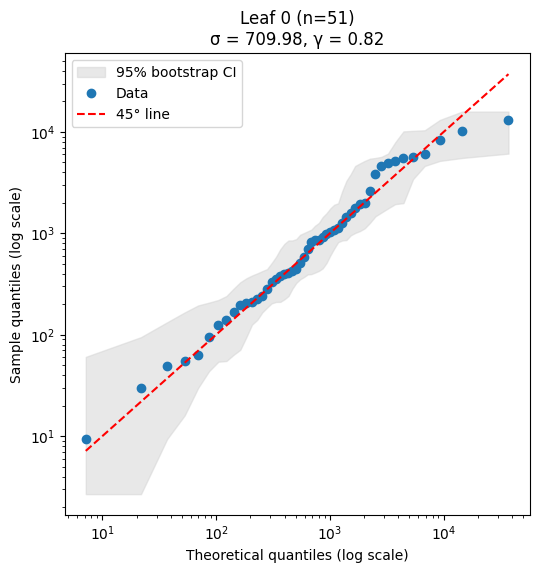

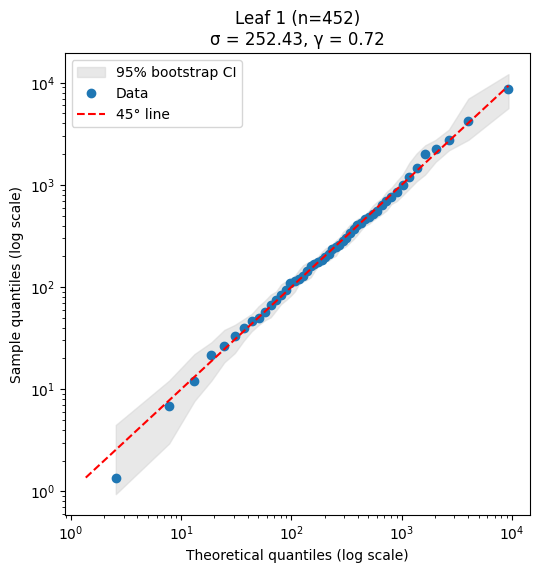

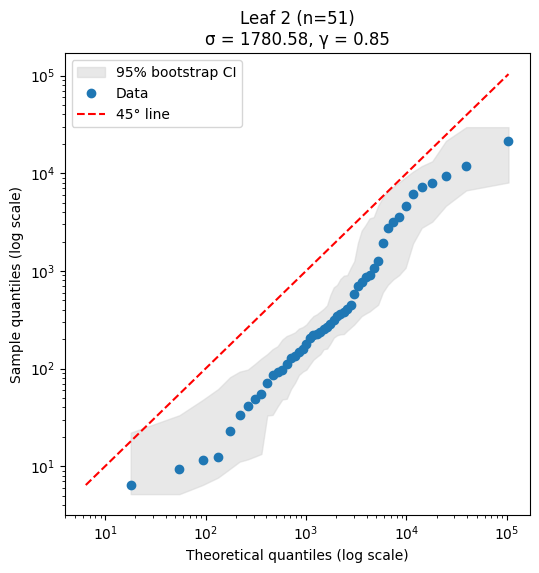

In [ ]:
graphs.plot_gp_tree_qq(gpd_tail_tree_pruned, X_tail, y_tail)
